# Final Project - Reinforcements Learning 
---
<br>

### Name and ID:
Student 1: Yarden Fogel ID: 011996279
<br>
Student 2: Sharon Koubi ID: 301315040

# MUST RUN FIRST
All the cells that need to be run before running experiments in one place.

## Installs

In [ ]:
%%capture
!sudo apt-get update
!sudo apt-get install -y xvfb ffmpeg freeglut3-dev
!pip install 'imageio==2.4.0'
!pip install gym
!pip install pygame
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install gym_sokoban
!git clone https://github.com/avivg7/sokoban-so.git
!unzip /content/sokoban-so/Compress.zip

## Imports

In [ ]:
import io
import os
import glob
import time
import math
import uuid
import base64
import shutil
import random
import warnings
from typing import Optional
from datetime import datetime
from contextlib import nullcontext
from dataclasses import dataclass, asdict
from collections import namedtuple, deque

import cv2
import torch
import pickle 
import imageio
import IPython
import pylab as pl
import numpy as np
import torch.nn as nn
from tqdm.notebook import tqdm
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchsummary import summary
from IPython.display import HTML
from IPython import display as ipythondisplay

%matplotlib inline

import gym
import pygame
import pyvirtualdisplay
from gym.utils import seeding
from gym import logger as gymlogger
from pyvirtualdisplay import Display
from gym import error, spaces, utils
gymlogger.set_level(40) # error only

from soko_pap import *

warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Download Notebook Files


Downloading all the videos for this notebook

In [ ]:
!gdown 10ORcTMZbHr8r62cVg0MKEJiSfsOYTf8u
!unzip /content/videos.zip

Downloading...
From: https://drive.google.com/uc?id=10ORcTMZbHr8r62cVg0MKEJiSfsOYTf8u
To: /content/videos.zip
100% 180k/180k [00:00<00:00, 115MB/s]
Archive:  /content/videos.zip
   creating: videos/
  inflating: videos/ex2_reward_shaping_distance_p.mp4  
  inflating: videos/ex2_reward_shaping_push_no_push_p.mp4  
  inflating: videos/ex1_dqn_agent.mp4  
  inflating: videos/ex2_dqn_agent_long_running_exp_MID.mp4  
  inflating: videos/ex2_reward_shaping_move_no_move_p.mp4  
  inflating: videos/ex2_random_agent.mp4  
  inflating: videos/ex1_dqn_agent_10Precent.mp4  
  inflating: videos/ex2_dqn_agent_long_running_exp_BEST.mp4  
  inflating: videos/ex2_reward_shaping_op0_p.mp4  
  inflating: videos/ex2_best_comb.mp4  
  inflating: videos/ex1_random_agent.mp4  


Downloading `explainer.md`

In [ ]:
!gdown 1bdf-YZBJj29VTiLpEuwBnUeI39QJ0L0g

Downloading...
From: https://drive.google.com/uc?id=1bdf-YZBJj29VTiLpEuwBnUeI39QJ0L0g
To: /content/explainer.md
100% 1.46k/1.46k [00:00<00:00, 2.44MB/s]


## Display utils
The cell below contains the video display configuration. No need to make changes here.

In [ ]:
def embed_mp4(filename):
    """Embeds an mp4 file in the notebook."""
    video = open(filename,'rb').read()
    b64 = base64.b64encode(video)
    tag = '''
    <video width="640" height="480" controls>
        <source src="data:video/mp4;base64,{0}" type="video/mp4">
    Your browser does not support the video tag.
    </video>'''.format(b64.decode())

    return IPython.display.HTML(tag)

display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

Function - given an environment it will return the indexes position and boxes locations

In [ ]:
def find_box_location(env):
    idx = np.argmax(env.room_state == 4)
    if env.room_state.flat[idx] == 4:
        return np.unravel_index(idx, env.room_state.shape)
    return None

Function - given an environment it will print us the details about observation, actions, agent's position and boxes locations

In [ ]:
def print_env_det(env):
  print(f'Observation space: {env.observation_space}'
      f'\nAction space: {env.action_space}'
      f'\nPlayer position:{env.player_position}'
      f'\nBox location: {find_box_location(env)}')

Function that writes text on an image, can be used for writing action on frame for rendering

In [ ]:
def write_on_image(image, text):
    return cv2.putText(
        img=image,
        text=text,
        org=(10, 20),
        fontFace=cv2.FONT_HERSHEY_COMPLEX_SMALL,
        fontScale=1,
        color=(255, 0, 0),
        thickness=1)

## Sokoban Env Wrapper
This class handles observation preprocessing, reward shaping and all other adaptations needed for running the game in the context of this excercise.

In [ ]:
@dataclass
class SokobanRewardShaping:
    no_move_punishment: Optional[float] = None      # Operation 0 punishment
    move_no_move_punishment: Optional[float] = None # Punishment for Push/Pull/Move but player does not move 
    push_without_pushing: Optional[float] = None    # Punishment for Push/Pull but only the player moves
    distance_box_target:  Optional[bool] = None     # Adaptive punishment w.r.t the distance between box-target

class SokobanEnvWrapper(gym.ObservationWrapper):

    MAX_STEPS = 500
    CONSTANT_SEED = 2

    def __init__(self, env, expected_shape, random_scenario, reward_shaping=SokobanRewardShaping(), seed=None):
        super().__init__(env)
        self.shape = expected_shape
        self.random_scenario = random_scenario
        self.observation_space = gym.spaces.Box(
            low=0.0,
            high=1.0,
            shape=(self.shape[2], self.shape[0], self.shape[1]),
            dtype=np.float32
        )
        self.env = env

        self.reward_shaping = reward_shaping
        self.initial_distance_box_target = np.linalg.norm(np.array(self.room_state.shape))

        self._seed = seed

    def reset(self, **kwargs):
        # if not self.random_scenario:
        #     print(np.random.get_state()[1][0])
        #     np.random.seed(SokobanEnvWrapper.CONSTANT_SEED if self._seed is None else self._seed)
        #     print(np.random.get_state()[1][0])
        #     state = super().reset(**kwargs)
        #     print(np.random.get_state()[1][0])

        # print(np.random.get_state()[1][0])
        # state = super().reset(**kwargs)
        # print(np.random.get_state()[1][0])
        # print("")

        if not self.random_scenario:
            random.seed(SokobanEnvWrapper.CONSTANT_SEED if self._seed is None else self._seed)
            _ = super().reset(**kwargs)

        state = super().reset(**kwargs)

        self.initial_distance_box_target = self.calc_distance('box', 'target')
        return state

    def step(self, action, observation_mode='rgb_array'):
        """ WA for '0' operation bug (fixing moving right -> no operation) """

        assert action in ACTION_LOOKUP

        self.num_env_steps += 1

        self.new_box_position = None
        self.old_box_position = None

        is_action_push = False
        is_action_pull = False

        moved_box = False
        if action == 0:
            moved_player = False

        # All push actions are in the range of [1, 4]
        if action == 0:
            moved_player, moved_box = False, False

        elif action < 5:
            moved_player, moved_box = self.env._push(action)
            is_action_push = True

        elif action < 9:
            moved_player = self.env._move(action)

        else:
            moved_player, moved_box = self.env._pull(action)
            is_action_pull = True

        self.env._calc_reward()

        done = self.env._check_if_done()

        # Convert the observation to RGB frame
        observation = self.observation(self.render(mode=observation_mode))

        info = {
            "action.name": ACTION_LOOKUP[action],
            "action.moved_player": moved_player,
            "action.moved_box": moved_box,
        }
        if done:
            info["maxsteps_used"] = self.env._check_if_maxsteps()
            info["all_boxes_on_target"] = self.env._check_if_all_boxes_on_target()

        ### Reward Shaping
        reward = self.reward_last

        # 1- No move operation punishment
        if action == 0 and (self.reward_shaping.no_move_punishment is not None):
            reward = self.reward_shaping.no_move_punishment

        # 2- Move/Push/Pull & no player movement punishment
        if action > 0 and (self.reward_shaping.move_no_move_punishment is not None):
            if not moved_player:
                reward = self.reward_shaping.move_no_move_punishment

        # 3- Push/Pull & player moves w/o the box punishment
        if (is_action_push or is_action_pull) and (self.reward_shaping.push_without_pushing is not None):
            if moved_player and not moved_box:
                reward = self.reward_shaping.push_without_pushing

        # 4- distance between box and target
        if self.reward_shaping.distance_box_target is not None:
            reward -= self.calc_distance('box', 'target')/self.initial_distance_box_target

        return observation, reward, done, info
        # return observation, self.reward_last, done, info TODO[sk]:remove

    def observation(self, obs):
        return self.preprocess(obs)

    def preprocess(self, frame):
        # Convert the image to grayscale
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)

        # Resize to the network input dimensions
        gray_scaled_frame = cv2.resize(gray_frame, self.shape[0:2], interpolation=cv2.INTER_LINEAR)

        # expand dimension for pytorch tensor
        exp_gray_scaled_img = np.expand_dims(gray_scaled_frame, axis=2).astype(np.uint8)

        # switch dimensions (pytorch tensor order)
        out_tensor = np.moveaxis(exp_gray_scaled_img, 2, 0)

        # normalized the tensor values to be in [0,1]
        normalized_out_tensor = out_tensor.astype(np.float32) / 255.

        return normalized_out_tensor

    def find_location(self, element):
        if element == 'box':
            element_num = 4
        elif element == 'monster':
            element_num = 5
        elif element == 'target':
            element_num = 2
        else:
            raise f"Unknown element {element}"

        idx = np.argmax(self.room_state == element_num)
        if self.room_state.flat[idx] == element_num:
            return np.unravel_index(idx, self.room_state.shape)
        return None

    def calc_distance(self, elem1, elem2):
        loc1 = self.find_location(elem1)
        loc2 = self.find_location(elem2)
        return np.linalg.norm(np.array(loc1)-np.array(loc2)) if loc1 and loc2 else 0

    @staticmethod
    def create_env(input_shape, random_scenario, reward_shaping=SokobanRewardShaping(), seed=None):
        # we will stop an episode with a different mechanism, otherwise step(...) will return done
        max_steps = SokobanEnvWrapper.MAX_STEPS + 1

        if not random_scenario:
            random.seed(SokobanEnvWrapper.CONSTANT_SEED if seed is None else seed)
        sok = PushAndPullSokobanEnv(dim_room=(7, 7), num_boxes=1 ,max_steps=max_steps)

        return SokobanEnvWrapper(sok, input_shape, random_scenario, reward_shaping, seed=seed)

### Playground
Playing with environment bug fixes and demonstrating correct movements.

Fix scenario

(2, 2)
(4, 5)
(2, 1)
3.605551275463989


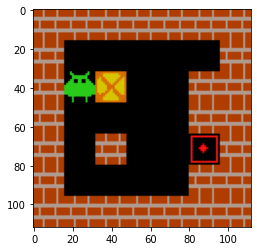

In [ ]:
sok = SokobanEnvWrapper.create_env((49,49,1), random_scenario=False)
plt.imshow(sok.render(mode='rgb_array'))
print(sok.find_location('box'))
print(sok.find_location('target'))
print(sok.find_location('monster'))
print(sok.calc_distance('box', 'target'))

(-0.1, False, {'action.name': 'no operation', 'action.moved_player': False, 'action.moved_box': False})
1


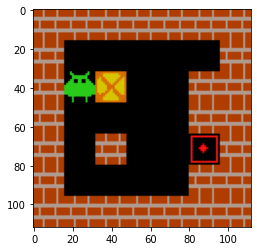

In [ ]:
print(sok.step(0)[1:4]) # No Operation
plt.imshow(sok.render(mode='rgb_array'))
print(sok.num_env_steps)

(-0.1, False, {'action.name': 'push right', 'action.moved_player': True, 'action.moved_box': True})
2
2.8284271247461903


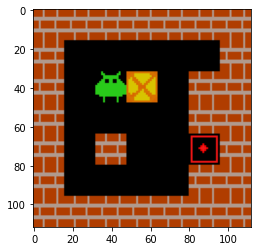

In [ ]:
print(sok.step(4)[1:4]) # Push Right
plt.imshow(sok.render(mode='rgb_array'))
print(sok.num_env_steps)
print(sok.calc_distance('box', 'target'))

(-0.1, False, {'action.name': 'push right', 'action.moved_player': True, 'action.moved_box': True})
(-0.1, False, {'action.name': 'move down', 'action.moved_player': True, 'action.moved_box': False})
(-0.1, False, {'action.name': 'move right', 'action.moved_player': True, 'action.moved_box': False})
(-0.1, False, {'action.name': 'pull down', 'action.moved_player': True, 'action.moved_box': True})
(-0.1, False, {'action.name': 'pull down', 'action.moved_player': True, 'action.moved_box': True})
7
1.0


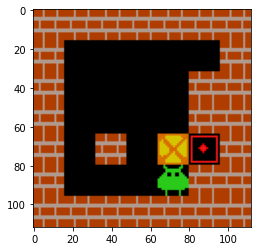

In [ ]:
print(sok.step(4)[1:4]) # Push right
print(sok.step(6)[1:4]) # down
print(sok.step(8)[1:4]) # right
print(sok.step(10)[1:4]) # pull down
print(sok.step(10)[1:4]) # pull down
plt.imshow(sok.render(mode='rgb_array'))
print(sok.num_env_steps)
print(sok.calc_distance('box', 'target'))

(-0.1, False, {'action.name': 'move left', 'action.moved_player': True, 'action.moved_box': False})
(-0.1, False, {'action.name': 'move up', 'action.moved_player': True, 'action.moved_box': False})
(10.9, True, {'action.name': 'push right', 'action.moved_player': True, 'action.moved_box': True, 'maxsteps_used': False, 'all_boxes_on_target': True})
10
0


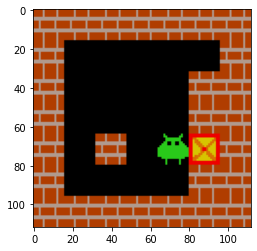

In [ ]:
print(sok.step(7)[1:4]) # Left
print(sok.step(5)[1:4]) # Up
print(sok.step(4)[1:4]) # Push Right
plt.imshow(sok.render(mode='rgb_array'))
print(sok.num_env_steps)
print(sok.calc_distance('box', 'target'))

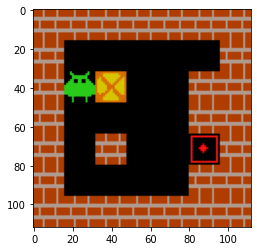

In [ ]:
sok.reset()
plt.imshow(sok.render(mode='rgb_array'))

Random scenario

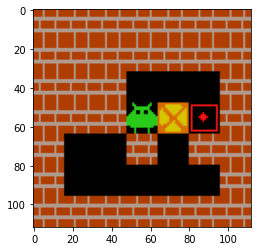

In [ ]:
sok = SokobanEnvWrapper.create_env((49,49,1), random_scenario=True)
plt.imshow(sok.render(mode='rgb_array'))

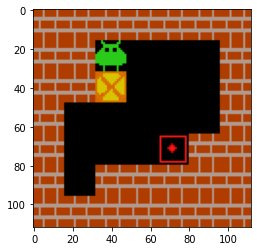

In [ ]:
sok.reset()
plt.imshow(sok.render(mode='rgb_array'))

(-0.1, False, {'action.name': 'no operation', 'action.moved_player': False, 'action.moved_box': False})


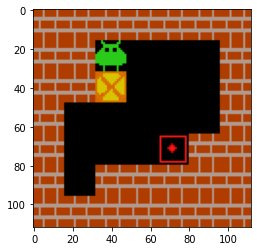

In [ ]:
print(sok.step(0)[1:4]) # No move
plt.imshow(sok.render(mode='rgb_array'))

Setting the seed

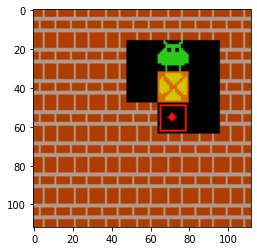

In [ ]:
sok = SokobanEnvWrapper.create_env((49,49,1), random_scenario=False, seed=2000)
plt.imshow(sok.render(mode='rgb_array'))

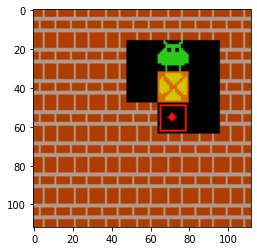

In [ ]:
sok.reset()
plt.imshow(sok.render(mode='rgb_array'))

In [ ]:
np.random.seed(7000)
np.random.get_state()[1][0]

7000

## Sokoban Solver

### DQN Implementation

#### Replay Buffer

In [ ]:
class ReplayBuffer:

    fields_for_recovery = ["seeking_position", "num_in_queue"]
    fields_for_recovery_pt = ["state_buffer", "action_buffer", "reward_buffer", "next_state_buffer", "done_buffer"]

    def __init__(self, max_memory_size, batch_size, state_space, pretrained, dump_dir):
        self.max_memory_size = max_memory_size
        self.batch_size = batch_size
        self.dump_dir = dump_dir

        if pretrained:
            self.load_pretrained()
        else:
            self.state_buffer = torch.zeros(max_memory_size, *state_space)
            self.action_buffer = torch.zeros(max_memory_size, 1)
            self.reward_buffer = torch.zeros(max_memory_size, 1)
            self.next_state_buffer = torch.zeros(max_memory_size, *state_space)
            self.done_buffer = torch.zeros(max_memory_size, 1)
            self.seeking_position = 0
            self.num_in_queue = 0

    @property
    def ready(self):
        """ Returns the queue status if is's ready to be sampled """
        return self.num_in_queue >= self.batch_size
        
    @property
    def full(self):
        """ Return if the replay buffer has been filled with samples """
        return self.num_in_queue == self.max_memory_size

    def remember(self, state, action, reward, next_state, done):
        """ Store the experiences in a buffer to use later """
        self.state_buffer[self.seeking_position] = torch.Tensor(np.array(state)).float()
        self.action_buffer[self.seeking_position] = action.float()
        self.reward_buffer[self.seeking_position] = torch.Tensor(np.array(reward)).unsqueeze(0).float()
        self.next_state_buffer[self.seeking_position] = torch.Tensor(np.array(next_state)).float()
        self.done_buffer[self.seeking_position] = torch.Tensor(np.array([int(done)])).unsqueeze(0).float()

        self.seeking_position = (self.seeking_position + 1) % self.max_memory_size  # FIFO
        self.num_in_queue = min(self.num_in_queue + 1, self.max_memory_size)
    
    def batch_experiences(self):
        """ Randomly sample 'batch size' experiences """
        idx = random.choices(range(self.num_in_queue), k=self.batch_size)
        state = self.state_buffer[idx]
        action = self.action_buffer[idx]
        reward = self.reward_buffer[idx]
        next_state = self.next_state_buffer[idx]
        done = self.done_buffer[idx]      
        return state, action, reward, next_state, done

    def store(self):
        # Saving relevant fields from this class
        for field in self.fields_for_recovery:
            with open(os.path.join(self.dump_dir, f"{field}.pkl"), "wb") as f:
                pickle.dump(getattr(self, field), f)

        for field in self.fields_for_recovery_pt:
            torch.save(getattr(self, field), os.path.join(self.dump_dir, f"{field}.pt"))

    def load_pretrained(self):
        for field in self.fields_for_recovery:
            with open(os.path.join(self.dump_dir, f"{field}.pkl"), "rb") as f:
                setattr(self, field, pickle.load(f))

        for field in self.fields_for_recovery_pt:
            setattr(self, field, torch.load(os.path.join(self.dump_dir, f"{field}.pt")))

#### DQN Architecture

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#### DQNNetwork

In [ ]:
class DQNNetwork(nn.Module):

    INPUT_SHAPE = (49, 49, 1)

    def __init__(self, n_actions):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(self.INPUT_SHAPE[2], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )

        conv_out_size = \
            int(np.prod(self.conv(torch.zeros(1, self.INPUT_SHAPE[2], *self.INPUT_SHAPE[0:2])).size()))

        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
        )

    def forward(self, x):
        conv_out = self.conv(x).view(x.size()[0], -1)
        return self.fc(conv_out)

In [ ]:
print(DQNNetwork(12).to(device))

DQNNetwork(
  (conv): Sequential(
    (0): Conv2d(1, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=12, bias=True)
  )
)


In [ ]:
summary(DQNNetwork(12).to(device), (1 ,49, 49))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 11, 11]           2,080
              ReLU-2           [-1, 32, 11, 11]               0
            Conv2d-3             [-1, 64, 4, 4]          32,832
              ReLU-4             [-1, 64, 4, 4]               0
            Conv2d-5             [-1, 64, 2, 2]          36,928
              ReLU-6             [-1, 64, 2, 2]               0
            Linear-7                  [-1, 512]         131,584
              ReLU-8                  [-1, 512]               0
            Linear-9                   [-1, 12]           6,156
Total params: 209,580
Trainable params: 209,580
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.09
Params size (MB): 0.80
Estimated Total Size (MB): 0.90
-------------------------------------------

#### DQNNetwork2

In [ ]:
class DQNNetwork2(nn.Module):

    INPUT_SHAPE = (7, 7, 1)

    def __init__(self, n_actions):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(self.INPUT_SHAPE[2], 32, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv2d(64, 512, kernel_size=3, stride=1),
            nn.ReLU()
        )

        conv_out_size = \
            int(np.prod(self.conv(torch.zeros(1, self.INPUT_SHAPE[2], *self.INPUT_SHAPE[0:2])).size()))

        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
        )

    def forward(self, x):
        conv_out = self.conv(x).view(x.size()[0], -1)
        return self.fc(conv_out)

In [ ]:
print(DQNNetwork2(12).to(device))

DQNNetwork2(
  (conv): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 512, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=12, bias=True)
  )
)


In [ ]:
summary(DQNNetwork2(12).to(device), (1 ,7, 7))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 32, 5, 5]             320
              ReLU-2             [-1, 32, 5, 5]               0
            Conv2d-3             [-1, 64, 3, 3]          18,496
              ReLU-4             [-1, 64, 3, 3]               0
            Conv2d-5            [-1, 512, 1, 1]         295,424
              ReLU-6            [-1, 512, 1, 1]               0
            Linear-7                  [-1, 512]         262,656
              ReLU-8                  [-1, 512]               0
            Linear-9                   [-1, 12]           6,156
Total params: 583,052
Trainable params: 583,052
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 2.22
Estimated Total Size (MB): 2.26
-------------------------------------------

In [ ]:
def get_network_input_shape(arch_name):
    if arch_name == "DQNNetwork":
        return DQNNetwork.INPUT_SHAPE
    if arch_name == "DQNNetwork2":
        return DQNNetwork2.INPUT_SHAPE
    
    raise f"Unknown network architecture: {arch_name}" 

#### DQN Predictor

In [ ]:
class DQNRandomPredictor:
    def __init__(self, action_space):
        self.action_space = action_space

    def act_greedy(self, state):
        return torch.tensor([[random.randrange(self.action_space)]])

    def act(self, state, eps):
        return torch.tensor([[random.randrange(self.action_space)]])

class DQNPredictor:
    """ DQNAgent that can only predict actions """
    def __init__(self, model_path, action_space, device, arch_class):
        self.model_path = model_path
        self.device = device
        self.action_space = action_space

        self.dqn = arch_class(self.action_space).to(self.device)
        self.dqn.load_state_dict(torch.load(model_path, map_location=torch.device(self.device)))

    def act_greedy(self, state):
        """ Greedy action """
        _state = torch.Tensor(np.array(state))

        with torch.no_grad():
            return torch.argmax(self.dqn(_state.to(self.device))).unsqueeze(0).unsqueeze(0).cpu()

    def act(self, state, eps):
        """ Epsilon-greedy action """
        if random.random() < eps:
            return torch.tensor([[random.randrange(self.action_space)]])

        return self.act_greedy(state)

#### DQN Agent

In [ ]:
class DQNAgent:
    def __init__(
        self,
        state_space,
        action_space,
        max_memory_size,
        batch_size,
        gamma,
        lr,
        exploration_max,
        exploration_min,
        exploration_decay,
        copy_weigths_every_steps,
        pretrained,
        dump_dir,
        optimizer,
        loss,
        nn_arch,
        *args,
        **kwargs
    ):

        # Define DQN Layers
        self.state_space = state_space
        self.action_space = action_space
        self.pretrained = pretrained
        self.dump_dir = dump_dir
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

        # DQN networks
        if nn_arch == "DQNNetwork":
            self.arch_class = DQNNetwork
        elif nn_arch == "DQNNetwork2":
            self.arch_class = DQNNetwork2
        else:
            raise f"Unknown network architecture {nn_arch}"
        self.dqn = self.arch_class(action_space).to(self.device)
        self.dqn_target = self.arch_class(action_space).to(self.device)

        if self.pretrained:
            self.load_pretrained()

        self.steps_between_copy = 0
        self.copy_weights_every_steps = copy_weigths_every_steps

        # Create Replay buffer
        self.replay_buffer = ReplayBuffer(
            max_memory_size,
            batch_size,
            self.state_space,
            self.pretrained,
            self.dump_dir
        )

        # optimizer
        if optimizer == "ADAM":
            self.optimizer = torch.optim.Adam(self.dqn.parameters(), lr=lr)
        elif optimizer == "SGD":
            self.optimizer = torch.optim.SGD(self.dqn.parameters(), lr=lr)
        else:
            raise f"Unknown optimizer function {optimizer}"
        
        # loss function
        if loss == "l1":
            self.loss = nn.SmoothL1Loss().to(self.device) # Huber loss
        elif loss == "l2":
            self.loss = nn.MSELoss().to(self.device)      # MSE
        else:
            raise f"Unknown loss function {loss}"
        
        # Learning parameters
        self.gamma = gamma
        self.exploration_max = exploration_max
        self.exploration_rate = exploration_max
        self.exploration_min = exploration_min
        self.exploration_decay = exploration_decay

        # Loaded predictors
        self.predictors = {}

    def act(self, state, overide_exploration_rate = 0.):
        """ Epsilon-greedy action """
        exploration_rate = overide_exploration_rate if overide_exploration_rate > 0. else self.exploration_rate

        if random.random() <= exploration_rate:
            return torch.tensor([[random.randrange(self.action_space)]])

        return self.act_greedy(state)

    def act_greedy(self, state):
        """ Greedy action """
        _state = torch.Tensor(np.array(state))

        with torch.no_grad():
            return torch.argmax(self.dqn(_state.to(self.device))).unsqueeze(0).unsqueeze(0).cpu()
    
    def experience_replay(self):
        if not self.replay_buffer.ready:
            return
    
        # Sample a batch of experiences
        state, action, reward, next_state, done = self.replay_buffer.batch_experiences()
        state = state.to(self.device)
        action = action.to(self.device)
        reward = reward.to(self.device)
        next_state = next_state.to(self.device)
        done = done.to(self.device)
        
        self.optimizer.zero_grad()

        # Q-Learning target is Q*(S, A) <- r + γ max_a Q'(S', a)
        with torch.no_grad(): # do not update gradients for target network
            target_values = self.dqn_target(next_state)
        target = reward + torch.mul((self.gamma * target_values.max(1).values.unsqueeze(1)), 1 - done)
        current = self.dqn(state).gather(1, action.long())
        
        loss = self.loss(current, target)
        loss.backward() # Compute gradients
        self.optimizer.step() # Backpropagate error

        self.exploration_rate *= self.exploration_decay
        self.steps_between_copy += 1
        
        # Makes sure that exploration rate is always at least 'exploration min'
        self.exploration_rate = max(self.exploration_rate, self.exploration_min)

        if self.steps_between_copy > self.copy_weights_every_steps:
            self.dqn_target.load_state_dict(self.dqn.state_dict())
            self.steps_between_copy = 0

        return loss.cpu().detach().numpy()

    def get_model_path(self, name):
        return os.path.join(self.dump_dir, f"{name}.pt")

    def get_model_state_dict(self):
        return self.dqn.state_dict()

    def save_model(self, model, name):
        self.save_model_as_state_dict(model.state_dict(), name)
        self.load_predictor_to_mem(name)

    def save_model_as_state_dict(self, model_state_dict, name):
        torch.save(model_state_dict, self.get_model_path(name))

    def load_model(self, model, name):
        model.load_state_dict(torch.load(self.get_model_path(name), map_location=torch.device(self.device)))

    def store(self):
        self.save_model(self.dqn, "DQN")
        self.save_model(self.dqn_target, "DQN_TARGET")
        self.replay_buffer.store()

    def load_pretrained(self):
        self.load_model(self.dqn, "DQN")
        self.load_model(self.dqn, "DQN_TARGET")
        
    def __call__(self, model_name):
        if model_name not in self.predictors:
            print('load predictor:' + model_name)
            self.load_predictor_to_mem(model_name)
        
        return self.predictors[model_name]

    def load_predictor_to_mem(self, model_name):
        self.predictors[model_name] = (
            DQNRandomPredictor(action_space=self.action_space) 
            if model_name == "RANDOM" else
            DQNPredictor(
                model_path=self.get_model_path(model_name),
                action_space=self.action_space,
                device=self.device,
                arch_class=self.arch_class
            )
        )

#### DQN Early Stopping
Recognizes convergence and saves the model checkpoint

In [ ]:
class EarlyStopping:
    """ Early stops the training if reward doesn't improve after a given patience. """
    def __init__(self, save_model_func, patience=7, verbose=False, delta=0, trace_func=print):
        """
        Args:
            save_model_func (caller): a function that triggers model saving
            patience (int): How long to wait after last time reward improved.
                            Default: 7
            verbose (bool): If True, prints a message for each reward improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            trace_func (function): trace print function.
                            Default: print            
        """
        self.save_model_func = save_model_func
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_reward = -np.Inf
        self.early_stop = False
        self.delta = delta
        self.trace_func = trace_func
        self.episodes = 0

    @property
    def stop(self):
        return self.early_stop

    @property
    def best_reward_episode(self):
        return self.episodes - self.counter

    def reset(self, verbose):
        self.verbose = verbose
        self.counter = 0
        self.best_reward = -np.Inf
        self.early_stop = False
        self.episodes = 0

    def __call__(self, reward, start_on_episode=-1):
        self.episodes += 1
        if self.episodes < start_on_episode:
            return False

        if reward > self.best_reward + self.delta:
            self.save_checkpoint(reward)
            self.best_reward = reward
            self.counter = 0
        else:
            self.counter += 1
            if self.verbose:
                self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True

        return self.stop

    def save_checkpoint(self, reward):
        """ Saves model when reward increased. """
        if self.verbose:
            self.trace_func(
                f'Reward increased ({self.best_reward:.6f} --> {reward:.6f}).  Saving model ...')

        self.save_model_func()


#### DQN Trainer


*   `TrainingCfg` - dataclass with set of parameters for DQN training
*   `DQNTrainer` - Class that responsible for DQN algorithm training



In [ ]:
@dataclass
class TrainingCfg:
    max_memory_size: int
    fill_replay_buffer: bool
    memory_n_good_samples: int
    batch_size: int
    gamma: float
    lr: float
    exploration_max: float
    exploration_min: float
    exploration_decay: float
    copy_weigths_every_steps: int
    early_stopping: bool
    early_stopping_patience: int
    early_stopping_start_on_episode: int
    early_stopping_delta: float
    reward_shaping: SokobanRewardShaping
    optimizer: str
    loss: str
    nn_arch: str
    random_scenario: bool
    max_episodes: int
    seed: int

    def __str__(self):
        out_str = f"{repr(self)}\n"
        for param, value in asdict(self).items():
            out_str += f"\t- {param} := {value}\n"

        return out_str

    @staticmethod
    def get_default_config():
        return TrainingCfg(
            max_memory_size=30000,
            memory_n_good_samples=10,
            batch_size=32,
            gamma=0.3,
            lr=0.00025,
            exploration_max=0.9,
            exploration_min=0.02,
            exploration_decay=0.99995,
            copy_weigths_every_steps=1000,
            early_stopping=True,
            early_stopping_patience=75,
            early_stopping_start_on_episode=30,
            early_stopping_delta=0,
            reward_shaping=SokobanRewardShaping(), # no reward shaping
            fill_replay_buffer=True,
            optimizer="ADAM", # or "SGD"
            loss="l1", # or "l2"
            nn_arch="DQNNetwork", # or "DQNNetwork2"
            random_scenario=True,
            max_episodes=250,
            seed=None
        )

In [ ]:
class DQNTrainer:

    MAX_EPISODES = 100
    fields_for_recovery = ["total_rewards", "losses", "steps", "done", "eps", "last_episode"]

    def __init__(self, random_scenario, config, pretrained="", print_params=True):
        print("Initializing DQNTrainer")
        self.random_scenario = random_scenario
        print("Game mode: " + ("RANDOM" if random_scenario else "FIX"))
        self.config = config

        if print_params:
            print(f"Config: {self.config}")

        if pretrained:
            self.dump_dir = pretrained
            print(f"Initializing DQNTrainer, previous results will be loaded from {self.dump_dir}")
        else:
            self.dump_dir = self.get_dump_dir()
            print(f"Initializing DQNTrainer, results will be written to {self.dump_dir}")
        
        self.env = SokobanEnvWrapper.create_env(
            get_network_input_shape(self.config.nn_arch),
            random_scenario,
            config.reward_shaping,
            seed=config.seed)

        self.agent = DQNAgent(
            state_space=self.env.observation_space.shape,
            action_space=self.env.action_space.n,
            dump_dir=self.dump_dir,
            pretrained=pretrained,
            **asdict(self.config)
        )

        self.total_rewards = []
        self.losses = [] # each operation that operate on this array must be nan safe!!
        self.steps = []
        self.models = []
        self.done = []
        self.eps = []
        self.last_episode = 0

        if pretrained:
            self.load_pretrained()

        if self.config.early_stopping:
            self.early_stopping = EarlyStopping(
                save_model_func=lambda: self.agent.save_model(self.agent.dqn, 'BEST'),
                patience=self.config.early_stopping_patience,
                verbose=False,
                delta=self.config.early_stopping_delta
            )

    def get_dump_dir(self):
        uid = str(uuid.uuid1()).split('-')[0]
        dump_dir = os.path.join('results', uid)
        if not os.path.exists(dump_dir):
            os.makedirs(dump_dir)
        return dump_dir

    def store(self):
        # Saving relevant fields from this class
        for field in self.fields_for_recovery:
            with open(os.path.join(self.dump_dir, f"{field}.pkl"), "wb") as f:
                pickle.dump(getattr(self, field), f)

        # Saving relevant fields of the Agent
        self.agent.store()

    def load_pretrained(self):
        for field in self.fields_for_recovery:
            with open(os.path.join(self.dump_dir, f"{field}.pkl"), "rb") as f:
                setattr(self, field, pickle.load(f))

    def fill_replay_buffer(self):
        """ This function is important when we don't want to train on Replay Buffer with only Negative rewards.
            Training on such a case can lead to reaching the Max Steps limits before the episode is done,
            hence the algorithm never gonverges since it only trains on same rewards.
        """

        print("Filling replay buffer with samples", end='')
        positive_reward_arr = []

        while (not self.agent.replay_buffer.full or len(positive_reward_arr)<self.config.memory_n_good_samples):
            print('.', end='')
            state = self.env.reset() # if we're in random scenario then a new board will be set

            while True:
                action = self.agent.act(state)
                
                state_next, reward, done, info = self.env.step(int(action[0]))
                self.agent.replay_buffer.remember(state, action, reward, state_next, done)

                if reward > 0:
                    positive_reward_arr.append((state, action, reward, state_next, done))

                state = state_next

                if done:
                    break

        # make sure the replay buffer has at least self.config.memory_n_good_samples positive rewards
        for t in positive_reward_arr:
            self.agent.replay_buffer.remember(*t)

        avg_done = torch.mean(self.agent.replay_buffer.done_buffer).float().item()
        print(f"\nReplay buffer avg Done states={avg_done}\n")

    def train(self, print_status_every=5, verbose=False, max_episodes=-1):
        # Early stopping resets
        self.early_stopping.reset(verbose)

        if self.config.fill_replay_buffer:
            self.fill_replay_buffer()

        max_episodes = self.MAX_EPISODES if max_episodes <= 0 else max_episodes

        for ep_num in tqdm(range(self.last_episode, max_episodes)):
            state = self.env.reset() # if we're in random scenario then a new board will be set

            total_reward = 0
            steps = 0
            episode_loss = []

            while True:
                action = self.agent.act(state)
                steps += 1
                
                state_next, reward, done, info = self.env.step(int(action[0]))
                total_reward += reward

                self.agent.replay_buffer.remember(state, action, reward, state_next, done)
                batch_losses = self.agent.experience_replay()

                state = state_next

                if batch_losses:
                    episode_loss.append(np.mean(batch_losses))
                else:
                    episode_loss.append(np.nan)

                if done or steps==self.env.MAX_STEPS:
                    break
            
            self.last_episode = ep_num + 1
            self.total_rewards.append(total_reward)
            self.losses.append(episode_loss) 
            self.steps.append(steps)
            self.models.append(self.agent.get_model_state_dict())
            self.done.append(done)
            self.eps.append(self.agent.exploration_rate)
            
            if verbose or (ep_num != 0 and ((ep_num+1) % print_status_every) == 0):
                self.print_stats()
            
            if self.config.early_stopping:
                avg_10_last_rewards = np.mean(self.total_rewards[max(-10, -self.last_episode):])
                if self.early_stopping(avg_10_last_rewards, self.config.early_stopping_start_on_episode):
                    print("\nEarly Stopping reached")
                    break

        if self.config.early_stopping:
            # Store mid-training model for a later comparison
            model_idx = np.floor(self.early_stopping.best_reward_episode/2).astype(int)
            self.agent.save_model_as_state_dict(self.models[model_idx], "MID")

            # Store 30%-process training model for a later comparison
            model_idx = np.floor(self.early_stopping.best_reward_episode*0.3).astype(int)
            self.agent.save_model_as_state_dict(self.models[model_idx], "30Precent")

            # Store 10%-process training model for a later comparison
            model_idx = np.floor(self.early_stopping.best_reward_episode*0.1).astype(int)
            self.agent.save_model_as_state_dict(self.models[model_idx], "10Precent")

        # clear the no-needed memory 
        self.models = []

        self.done_training()

    def train_safe(self, print_status_every=5, verbose=False, max_episodes=-1):
        """ runs 'train', and saves the training state, in case that the training stopped by the user """
        try:
            self.train(print_status_every, verbose, max_episodes)
        except KeyboardInterrupt:
            print("Requested to stop by the user")
            self.print_stats()
            self.store()

    def evaluate(self, verbose=False, agent_name="", render=False, output_file='imageio.mp4', eps_greedy=0.):           
        state = self.env.reset() # if we're in random scenario then a new board will be set

        total_reward = 0
        steps = 0
        done = False

        step_list = []
        reward_list = []

        # Get the relevant agent
        agent = self.agent(agent_name) if agent_name else self.agent

        # Get the relevant act function whether its the e-greedy or the greedy act
        act_func = agent.act_greedy if eps_greedy == 0. else (lambda state: agent.act(state, eps_greedy))

        with imageio.get_writer(output_file, fps=10) if render else nullcontext() as video:
            if render:
                video.append_data(self.env.render(mode='rgb_array'))

            while not done:
                action = act_func(state)

                steps += 1
                
                state_next, reward, done, info = self.env.step(int(action[0]))
                total_reward += reward
                
                step_list.append(steps)
                reward_list.append(reward)

                if render:
                    video.append_data(write_on_image(self.env.render(mode='rgb_array'), str(int(action[0]))))
                
                state = state_next

                if steps==self.env.MAX_STEPS:
                    break
        
        if verbose:
            mode = "(RANDOM board)" if self.random_scenario else "(FIX board)"
            solved = "solved" if done else "did not solve"
            print(f"The agent {solved} Sokoban {mode} after {steps} steps, reward={total_reward:.2f}")

        return done, steps, total_reward, step_list, reward_list

    def evaluate_over(self, n_episodes, agent_name="", eps_greedy=0.):
        reward_avg = 0.
        steps_avg = 0.
        done_avg = 0.
        rewards = []

        for i in range(n_episodes):
            done, steps, reward, _, _ = self.evaluate(agent_name=agent_name, eps_greedy=eps_greedy)
            reward_avg += reward / n_episodes
            steps_avg += steps / n_episodes
            done_avg += done / n_episodes
            rewards.append(reward)

        return rewards, reward_avg, steps_avg, done_avg

    def print_stats(self):
        print(
            f"\nEpisode {self.last_episode}:"
            f"\tlast_reward={self.total_rewards[-1]:.3f}  |  "
            f"5_rewards={np.mean(self.total_rewards[-5:]):.3f}  |  "
            f"avg_rewards={np.mean(self.total_rewards):.3f}  |  "
            f"avg_loss={np.mean([np.nanmean(episode_loss) for episode_loss in self.losses]):.10f}  |  "
            f"last_steps={self.steps[-1]}  |  "
            f"avg_steps={np.mean(self.steps):.1f}  |  "
            f"eps={self.agent.exploration_rate:.5f}"
        )

    def print_best_episode(self):
        best_episode_idx = self.early_stopping.best_reward_episode -1
        print(
            f"\nBEST Episode {self.early_stopping.best_reward_episode}:"
            f"\treward={self.total_rewards[best_episode_idx]:.3f}  |  "
            f"avg_loss={np.nanmean(self.losses[best_episode_idx]):.10f}  |  "
            f"steps={self.steps[best_episode_idx]}"
            f"  |  DONE" if self.done[best_episode_idx] else ""
        )

    def done_training(self):
        print("Done Training!")
        if self.config.early_stopping:
            self.print_best_episode()
        else:
            self.print_stats()
        self.store()

## Experimentation Utils

### Evaluator
Given a trained model, play Sokoban and evaluate performance.

In [ ]:
class Evaluator:
    def __init__(self, trainers):
        self.trainers = trainers if isinstance(trainers, dict) else {"NoName": trainers}
        self.results = {}

    def evaluate(self, n_iterations, agent_name="", plot_chart=False, chart_title="Rewards STD", chart_lim=None, verbose=True, eps_greedy=0.):
        for trainer_name, trainer in self.trainers.items():
            rewards, reward_avg, steps_avg, done_avg = trainer.evaluate_over(n_iterations, agent_name, eps_greedy=eps_greedy)

            if verbose:
                name_str = "" if trainer_name=="NoName" else f"for {trainer_name}"
                print(f"Average results {name_str} on {n_iterations} evaluations:\n"
                      f"\tReward={reward_avg:.2f} | Steps={steps_avg:.2f} | Success Rate={done_avg*100:.2f}%")
                
            self.results[trainer_name] = (rewards, reward_avg, steps_avg, done_avg)
        
        if plot_chart:
            self.average_reward_plot(chart_title, chart_lim)

        return reward_avg, steps_avg, done_avg

    def swipe_eps_greedy_agents(self, n_iterations, agent_name="", chart_title="Rewards STD", verbose=True, eps_greedy_vals=[]):
        assert len(self.trainers.keys()) == 1
        trainer = list(self.trainers.values())[0]

        for eps_greedy in eps_greedy_vals:
            rewards, reward_avg, steps_avg, done_avg = trainer.evaluate_over(n_iterations, agent_name, eps_greedy=eps_greedy)
            name_str = f"eps-greedy={eps_greedy:.2f}"
            if verbose:
                print(f"Average results {name_str} on {n_iterations} evaluations:\n"
                      f"\tReward={reward_avg:.2f} | Steps={steps_avg:.2f} | Success Rate={done_avg*100:.2f}%")

            self.results[name_str] = (rewards, reward_avg, steps_avg, done_avg)

        self.average_reward_plot(chart_title, plot_scatter=False, x_vals=eps_greedy_vals, plot_legend=False, xlabel="eps-greedy value")

    def average_reward_plot(self, title, lim=None, plot_scatter=True, x_vals=[], plot_legend=True, xlabel="", ylabel="Reward"):
        no_x_vals = x_vals==[]
        assert no_x_vals or len(x_vals)==len(self.results)

        names = []
        for i, (trainer_name, (rewards, _, _, _)) in enumerate(self.results.items()):
            plt.errorbar((x_vals[i] if not no_x_vals else i+1), np.mean(rewards), np.std(rewards), marker='x', capsize=10)
            names.append(trainer_name)

        if plot_legend and (not names[0]=="NoName"):
            plt.legend(names)

        if plot_scatter:
            for i, (_, (rewards, _, _, _)) in enumerate(self.results.items()):
                plt.scatter((i+1)*np.ones_like(rewards), rewards, color='red', marker='o')

        if lim:
            plt.ylim(lim)

        if xlabel:
            plt.xlabel(xlabel, fontsize=14)
        if ylabel:
            plt.ylabel(ylabel, fontsize=14)


        plt.title(title)

        plt.show()

    def evaluate_and_render(self, name, agent_name="", eps_greedy=0.):
        out_paths = {}
        for trainer_name, trainer in self.trainers.items():
            if not trainer_name == "NoName":
                print(trainer_name)
            out_path = os.path.join(trainer.dump_dir, f'{name}.mp4')
            _ = trainer.evaluate(verbose=True, agent_name=agent_name, render=True, output_file=out_path, eps_greedy=eps_greedy)
            out_paths[trainer_name] = out_path

        return out_path if len(self.trainers.keys()) == 1 else out_paths

    def evaluate_and_render_BEST(self, name, eps_greedy=0.):
        return self.evaluate_and_render(name, "BEST", eps_greedy)

### Visulization Helper

In [ ]:
class Visualizer:
    def plot_rewards_loss(self, trainer, title=None):
        fig, axes = plt.subplots(1, 2, figsize=(14,6))

        if title:
            fig.suptitle(title, fontsize=18)

        axes[0].plot(trainer.total_rewards)
        axes[0].plot([np.mean(trainer.total_rewards[max(0,i-10):i]) for i in range(len(trainer.total_rewards))])
        axes[0].plot([np.mean(trainer.total_rewards[0:i]) for i in range(len(trainer.total_rewards))])
        axes[0].axvline(trainer.config.early_stopping_start_on_episode, linestyle='--', color='r')
        axes[0].scatter([trainer.early_stopping.best_reward_episode], [trainer.early_stopping.best_reward], color="red") # plotting single point on best reward
        axes[0].set_ylabel(f"Reward", fontsize=14)
        axes[0].set_xlabel("Episode #", fontsize=14)
        axes[0].title.set_text('Reward / Episode')
        axes[0].legend(['Reward', 'Reward(avg of 10)', 'Avg Reward', 'Start early stopping', 'BEST'])

        loss_per_episode = [np.nanmean(episode_loss) for episode_loss in trainer.losses]
        axes[1].plot(loss_per_episode)
        axes[1].plot([np.mean(loss_per_episode[max(0,i-10):i]) for i in range(len(loss_per_episode))])
        axes[1].plot([np.mean(loss_per_episode[0:i]) for i in range(len(loss_per_episode))])
        axes[1].set_ylabel(f"Loss", fontsize=14)
        axes[1].set_xlabel("Episode #", fontsize=14)
        axes[1].title.set_text('Loss / Episode')
        axes[1].legend(['Loss per Episode', 'Loss per Episode(avg of 10)', 'Avg Loss'])

        plt.show()

### Hyper-Parameter Tuner

In [ ]:
class ParamTuner:
    def __init__(self):
        self.trainers = {}
    
    def tune_param(self, param_name, param_values, overide_params={}):
        trainers_names = []
        for value in tqdm(param_values, desc=f"Tunning '{param_name}'"):
            name = f'{param_name}={value}'
            
            # Prepare the configuration for training
            cfg = TrainingCfg.get_default_config()
            for over_param, over_value in overide_params.items():
                setattr(cfg, over_param, over_value)

            setattr(cfg, param_name, value)

            # Create a trainer
            trainer = DQNTrainer(random_scenario=cfg.random_scenario, config=cfg)
            self.trainers[name] = trainer
            trainers_names.append(name)

            # Train
            trainer.train_safe(verbose=False, max_episodes=cfg.max_episodes)

        return trainers_names

    def visualize_plots(self, trainer_names):
        for name in trainer_names:
            # Plot results
            Visualizer().plot_rewards_loss(self.trainers[name], title=name)

    def evaluate_n_episodes(self, trainer_names, n_episodes):
        param_names= list({name.split('=')[0] for name in trainer_names})
        param_trainers = {name: self.trainers[name] for name in trainer_names}

        title = f"BEST model ({param_names}) comparison, {n_episodes} evaluations"
        _ = Evaluator(param_trainers).evaluate(
            n_episodes, agent_name="BEST", plot_chart=True, chart_title=title)

### Preserving Results

In [ ]:
OUTPUT_VIDEO_DIR = 'videos'

def preserve_video(video_path):
    """ copy the video to the output videos directory """
    if not os.path.exists(OUTPUT_VIDEO_DIR):
        os.mkdir(OUTPUT_VIDEO_DIR)

    shutil.copy(video_path, OUTPUT_VIDEO_DIR)
    
def preserved_video_path(video_name):
    return os.path.join(OUTPUT_VIDEO_DIR, f'{video_name}.mp4')
    

# EX1 - FIX SCENARIO - ONE BOX


## Random Agent
To establish a baseline for performance improvement, we will begin by demonstrating the performance of a random agent over 100 iterations.

Initializing DQNTrainer
Game mode: FIX
Initializing DQNTrainer, results will be written to results/f1bc317e
load predictor:RANDOM
Average results  on 100 evaluations:
	Reward=-50.00 | Steps=500.00 | Success Rate=0.00%


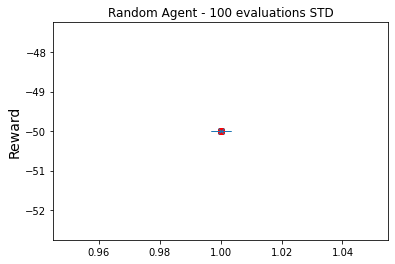

In [ ]:
cfg = TrainingCfg.get_default_config()
cfg.random_scenario = False
random_trainer_ex1 = DQNTrainer(random_scenario=False, config=cfg, print_params=False)
_ = Evaluator(random_trainer_ex1).evaluate(
    100,
    agent_name="RANDOM",
    plot_chart=True,
    chart_title="Random Agent - 100 evaluations STD")

In [ ]:
path = Evaluator(random_trainer_ex1).evaluate_and_render('ex1_random_agent', agent_name="RANDOM")

The agent did not solve Sokoban (FIX board) after 500 steps, reward=-50.00


In [ ]:
preserve_video(path)

In [ ]:
embed_mp4(preserved_video_path('ex1_random_agent'))

## {**EX1 BEST**} DQN-based Agent

In [ ]:
cfg = TrainingCfg.get_default_config()
cfg.max_memory_size=5000
cfg.gamma=0.9
cfg.lr=0.00025
cfg.exploration_decay=0.99995
cfg.copy_weigths_every_steps=50
cfg.early_stopping=True
cfg.early_stopping_patience=20
cfg.early_stopping_start_on_episode=30
cfg.random_scenario=False

trainer_ex1 = DQNTrainer(random_scenario=False, config=cfg)
trainer_ex1.train_safe()

Initializing DQNTrainer
Game mode: FIX
Config: TrainingCfg(max_memory_size=5000, fill_replay_buffer=True, memory_n_good_samples=10, batch_size=32, gamma=0.9, lr=0.00025, exploration_max=0.9, exploration_min=0.02, exploration_decay=0.99995, copy_weigths_every_steps=50, early_stopping=True, early_stopping_patience=20, early_stopping_start_on_episode=30, early_stopping_delta=0, reward_shaping=SokobanRewardShaping(no_move_punishment=None, move_no_move_punishment=None, push_without_pushing=None, distance_box_target=None), optimizer='ADAM', loss='l1', nn_arch='DQNNetwork', random_scenario=False, max_episodes=250)
	- max_memory_size := 5000
	- fill_replay_buffer := True
	- memory_n_good_samples := 10
	- batch_size := 32
	- gamma := 0.9
	- lr := 0.00025
	- exploration_max := 0.9
	- exploration_min := 0.02
	- exploration_decay := 0.99995
	- copy_weigths_every_steps := 50
	- early_stopping := True
	- early_stopping_patience := 20
	- early_stopping_start_on_episode := 30
	- early_stopping_delta :

  0%|          | 0/100 [00:00<?, ?it/s]


Episode 5:	last_reward=-50.000  |  5_rewards=-50.000  |  avg_rewards=-50.000  |  avg_loss=0.0236140043  |  last_steps=500  |  avg_steps=500.0  |  eps=0.79424

Episode 10:	last_reward=-9.300  |  5_rewards=-41.860  |  avg_rewards=-45.930  |  avg_loss=0.0193512235  |  last_steps=203  |  avg_steps=470.3  |  eps=0.71140

Episode 15:	last_reward=-50.000  |  5_rewards=-34.700  |  avg_rewards=-42.187  |  avg_loss=0.0210523233  |  last_steps=500  |  avg_steps=443.9  |  eps=0.64515

Episode 20:	last_reward=-3.400  |  5_rewards=-8.780  |  avg_rewards=-33.835  |  avg_loss=0.0263023786  |  last_steps=144  |  avg_steps=382.4  |  eps=0.61402

Episode 25:	last_reward=6.200  |  5_rewards=-3.700  |  avg_rewards=-27.808  |  avg_loss=0.0264709610  |  last_steps=48  |  avg_steps=335.3  |  eps=0.59187

Episode 30:	last_reward=5.800  |  5_rewards=6.120  |  avg_rewards=-22.153  |  avg_loss=0.0256041661  |  last_steps=52  |  avg_steps=287.5  |  eps=0.58469

Episode 35:	last_reward=5.700  |  5_rewards=5.440  |

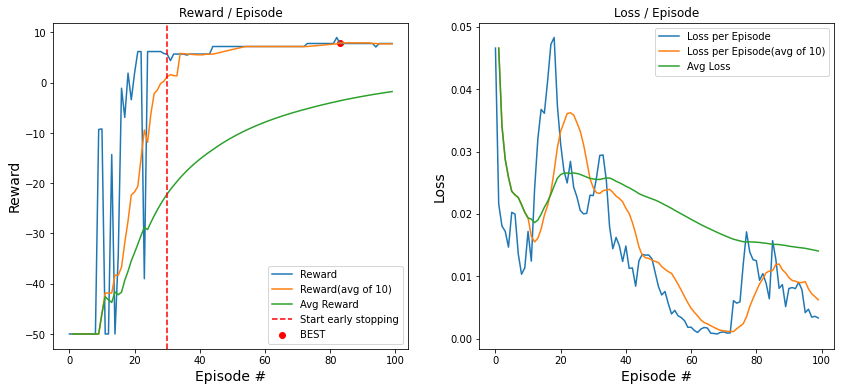

In [ ]:
Visualizer().plot_rewards_loss(trainer_ex1)

### Agent Videos

Agent at the end of the training:

In [ ]:
path = Evaluator(trainer_ex1).evaluate_and_render('ex1_dqn_agent')

The agent solved Sokoban (FIX board) after 9 steps, reward=10.10


In [ ]:
preserve_video(path)

In [ ]:
embed_mp4(preserved_video_path('ex1_dqn_agent'))

Agent at the beggining of training after (10% of epochs),

In [ ]:
path = Evaluator(trainer_ex1).evaluate_and_render('ex1_dqn_agent_10Precent', agent_name='10Precent')

load predictor:10Precent
The agent solved Sokoban (FIX board) after 9 steps, reward=10.10


In [ ]:
preserve_video(path)

In [ ]:
embed_mp4(preserved_video_path('ex1_dqn_agent_10Precent'))

At this point in time, the agent appears to be performing well. However, the exploration mode of the DQN is causing the convergence graph to be unstable.

Average results  on 100 evaluations:
	Reward=10.10 | Steps=9.00 | Success Rate=100.00%


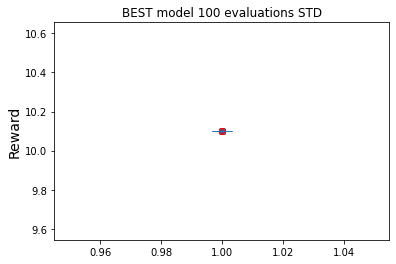

In [ ]:
_ = Evaluator(trainer_ex1).evaluate(100, plot_chart=True, chart_title="BEST model 100 evaluations STD")

Since we are playing on the same game, and DQN agent is greedy, it always will finish the game (as we can see in the plot)

## Algorithm Robustness
A domenstration that our algorithm convergence with an every specified seed for the Fix scenario.

In [ ]:
pt = ParamTuner()
seeds = np.random.randint(0, 1000, size=5)
gamma_trainers_names = pt.tune_param(
    param_name='seed',
    param_values=seeds,
    overide_params={
        'random_scenario': False,
        'max_memory_size': 5000,
        'gamma': 0.9,
        'lr': 0.00025,
        'exploration_decay': 0.99995,
        'copy_weigths_every_steps': 50,
        'early_stopping': True,
        'early_stopping_patience': 20,
        'early_stopping_start_on_episode': 30,
        }
    )

Tunning 'seed':   0%|          | 0/5 [00:00<?, ?it/s]

Initializing DQNTrainer
Game mode: FIX
Config: TrainingCfg(max_memory_size=5000, fill_replay_buffer=True, memory_n_good_samples=10, batch_size=32, gamma=0.9, lr=0.00025, exploration_max=0.9, exploration_min=0.02, exploration_decay=0.99995, copy_weigths_every_steps=50, early_stopping=True, early_stopping_patience=20, early_stopping_start_on_episode=30, early_stopping_delta=0, reward_shaping=SokobanRewardShaping(no_move_punishment=None, move_no_move_punishment=None, push_without_pushing=None, distance_box_target=None), optimizer='ADAM', loss='l1', nn_arch='DQNNetwork', random_scenario=False, max_episodes=250, seed=257)
	- max_memory_size := 5000
	- fill_replay_buffer := True
	- memory_n_good_samples := 10
	- batch_size := 32
	- gamma := 0.9
	- lr := 0.00025
	- exploration_max := 0.9
	- exploration_min := 0.02
	- exploration_decay := 0.99995
	- copy_weigths_every_steps := 50
	- early_stopping := True
	- early_stopping_patience := 20
	- early_stopping_start_on_episode := 30
	- early_stoppi

  0%|          | 0/250 [00:00<?, ?it/s]


Episode 5:	last_reward=-1.500  |  5_rewards=7.140  |  avg_rewards=7.140  |  avg_loss=0.0529352650  |  last_steps=125  |  avg_steps=38.6  |  eps=0.89136

Episode 10:	last_reward=10.700  |  5_rewards=6.860  |  avg_rewards=7.000  |  avg_loss=0.0337694436  |  last_steps=3  |  avg_steps=40.0  |  eps=0.88218

Episode 15:	last_reward=10.700  |  5_rewards=10.700  |  avg_rewards=8.233  |  avg_loss=0.0229474343  |  last_steps=3  |  avg_steps=27.7  |  eps=0.88152

Episode 20:	last_reward=10.700  |  5_rewards=10.480  |  avg_rewards=8.795  |  avg_loss=0.0188968517  |  last_steps=3  |  avg_steps=22.1  |  eps=0.88037

Episode 25:	last_reward=10.700  |  5_rewards=10.700  |  avg_rewards=9.176  |  avg_loss=0.0153706120  |  last_steps=3  |  avg_steps=18.2  |  eps=0.87971

Episode 30:	last_reward=10.700  |  5_rewards=10.700  |  avg_rewards=9.430  |  avg_loss=0.0129469298  |  last_steps=3  |  avg_steps=15.7  |  eps=0.87905

Episode 35:	last_reward=10.700  |  5_rewards=10.700  |  avg_rewards=9.611  |  avg_

  0%|          | 0/250 [00:00<?, ?it/s]


Episode 5:	last_reward=10.100  |  5_rewards=10.100  |  avg_rewards=10.100  |  avg_loss=0.6152905226  |  last_steps=9  |  avg_steps=9.0  |  eps=0.89798

Episode 10:	last_reward=10.100  |  5_rewards=10.100  |  avg_rewards=10.100  |  avg_loss=1.4729095697  |  last_steps=9  |  avg_steps=9.0  |  eps=0.89596

Episode 15:	last_reward=10.100  |  5_rewards=10.100  |  avg_rewards=10.100  |  avg_loss=1.0099624395  |  last_steps=9  |  avg_steps=9.0  |  eps=0.89395

Episode 20:	last_reward=10.100  |  5_rewards=10.100  |  avg_rewards=10.100  |  avg_loss=0.7605015635  |  last_steps=9  |  avg_steps=9.0  |  eps=0.89194

Episode 25:	last_reward=10.100  |  5_rewards=10.100  |  avg_rewards=10.100  |  avg_loss=0.6099287271  |  last_steps=9  |  avg_steps=9.0  |  eps=0.88993

Episode 30:	last_reward=10.100  |  5_rewards=10.100  |  avg_rewards=10.100  |  avg_loss=0.5092257857  |  last_steps=9  |  avg_steps=9.0  |  eps=0.88793

Episode 35:	last_reward=10.100  |  5_rewards=10.100  |  avg_rewards=10.100  |  avg

  0%|          | 0/250 [00:00<?, ?it/s]


Episode 5:	last_reward=7.000  |  5_rewards=-8.740  |  avg_rewards=-8.740  |  avg_loss=0.2535651326  |  last_steps=40  |  avg_steps=175.4  |  eps=0.86139

Episode 10:	last_reward=10.100  |  5_rewards=9.480  |  avg_rewards=0.370  |  avg_loss=0.1534239203  |  last_steps=9  |  avg_steps=95.3  |  eps=0.85812

Episode 15:	last_reward=10.100  |  5_rewards=10.100  |  avg_rewards=3.613  |  avg_loss=0.1153249964  |  last_steps=9  |  avg_steps=66.5  |  eps=0.85619

Episode 20:	last_reward=10.100  |  5_rewards=10.100  |  avg_rewards=5.235  |  avg_loss=0.0943824425  |  last_steps=9  |  avg_steps=52.1  |  eps=0.85427

Episode 25:	last_reward=10.100  |  5_rewards=10.100  |  avg_rewards=6.208  |  avg_loss=0.0818125829  |  last_steps=9  |  avg_steps=43.5  |  eps=0.85235

Episode 30:	last_reward=10.100  |  5_rewards=10.100  |  avg_rewards=6.857  |  avg_loss=0.0734918639  |  last_steps=9  |  avg_steps=37.8  |  eps=0.85043

Episode 35:	last_reward=10.100  |  5_rewards=10.100  |  avg_rewards=7.320  |  avg

  0%|          | 0/250 [00:00<?, ?it/s]


Episode 5:	last_reward=-9.400  |  5_rewards=-26.920  |  avg_rewards=-26.920  |  avg_loss=0.0622186288  |  last_steps=204  |  avg_steps=357.2  |  eps=0.82311

Episode 10:	last_reward=1.200  |  5_rewards=-1.580  |  avg_rewards=-14.250  |  avg_loss=0.0657043904  |  last_steps=98  |  avg_steps=241.5  |  eps=0.79763

Episode 15:	last_reward=4.500  |  5_rewards=2.500  |  avg_rewards=-8.667  |  avg_loss=0.0565966144  |  last_steps=65  |  avg_steps=189.3  |  eps=0.78086

Episode 20:	last_reward=4.400  |  5_rewards=3.020  |  avg_rewards=-5.745  |  avg_loss=0.0511613600  |  last_steps=66  |  avg_steps=161.9  |  eps=0.76543

Episode 25:	last_reward=4.400  |  5_rewards=4.520  |  avg_rewards=-3.692  |  avg_loss=0.0454081781  |  last_steps=66  |  avg_steps=142.5  |  eps=0.75313

Episode 30:	last_reward=4.400  |  5_rewards=4.400  |  avg_rewards=-2.343  |  avg_loss=0.0407859795  |  last_steps=66  |  avg_steps=129.8  |  eps=0.74081

Episode 35:	last_reward=4.300  |  5_rewards=4.380  |  avg_rewards=-1.

  0%|          | 0/250 [00:00<?, ?it/s]


Episode 5:	last_reward=9.800  |  5_rewards=9.800  |  avg_rewards=9.800  |  avg_loss=1.6579545736  |  last_steps=12  |  avg_steps=12.0  |  eps=0.89730

Episode 10:	last_reward=9.800  |  5_rewards=9.620  |  avg_rewards=9.710  |  avg_loss=1.1759346724  |  last_steps=12  |  avg_steps=12.9  |  eps=0.89421

Episode 15:	last_reward=9.800  |  5_rewards=9.800  |  avg_rewards=9.740  |  avg_loss=0.7906075120  |  last_steps=12  |  avg_steps=12.6  |  eps=0.89153

Episode 20:	last_reward=9.800  |  5_rewards=9.800  |  avg_rewards=9.755  |  avg_loss=0.5942238569  |  last_steps=12  |  avg_steps=12.4  |  eps=0.88886

Episode 25:	last_reward=9.800  |  5_rewards=9.800  |  avg_rewards=9.764  |  avg_loss=0.4761411250  |  last_steps=12  |  avg_steps=12.4  |  eps=0.88620

Episode 30:	last_reward=9.800  |  5_rewards=9.800  |  avg_rewards=9.770  |  avg_loss=0.3973601460  |  last_steps=12  |  avg_steps=12.3  |  eps=0.88355

Episode 35:	last_reward=9.800  |  5_rewards=9.800  |  avg_rewards=9.774  |  avg_loss=0.3

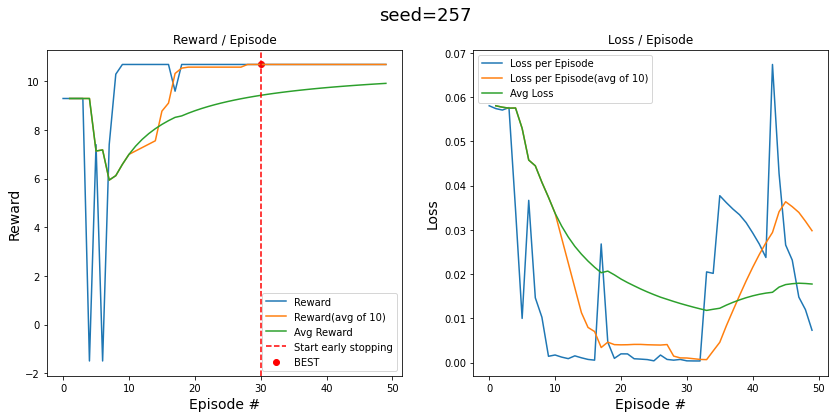

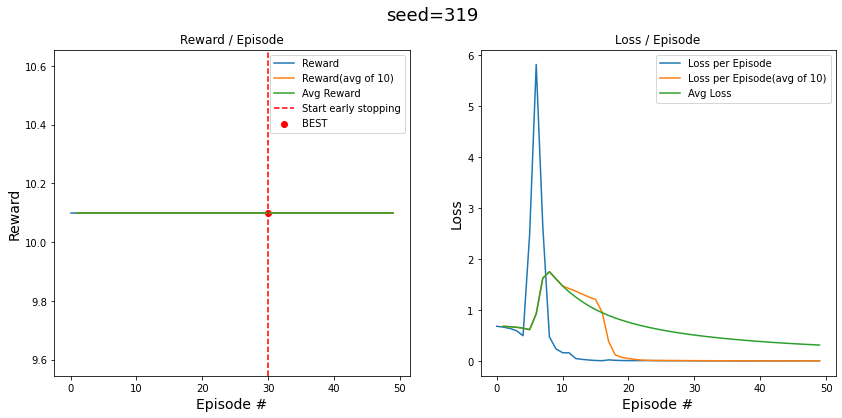

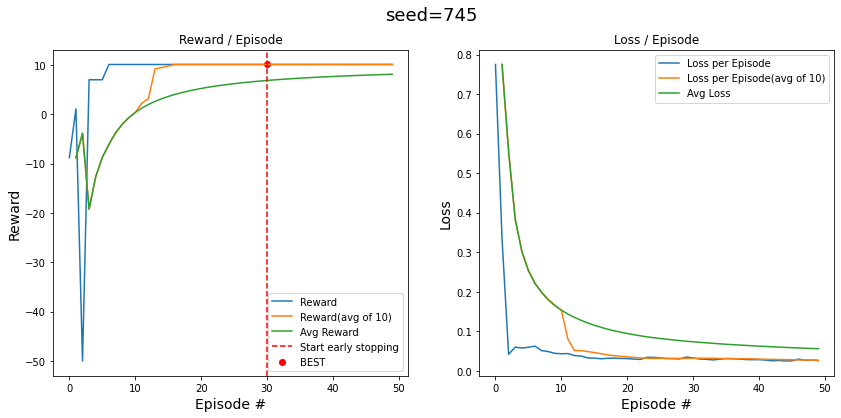

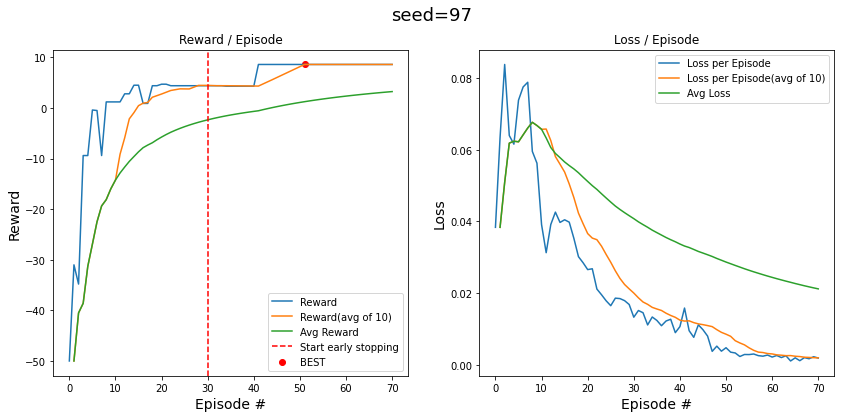

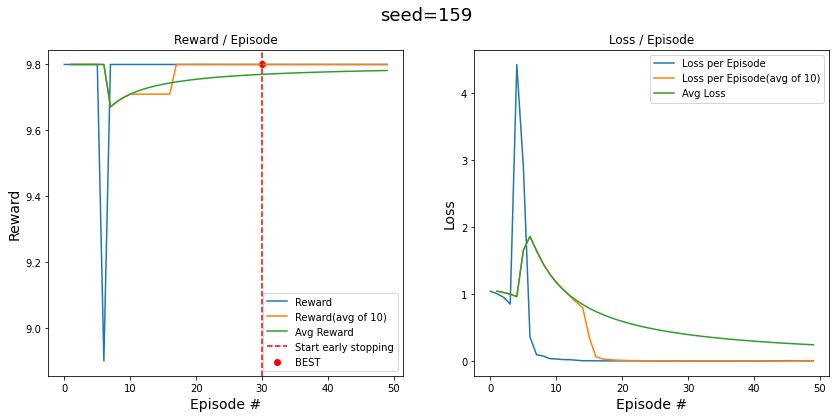

In [ ]:
pt.visualize_plots(list(pt.trainers.keys()))

Presenting the different boards:

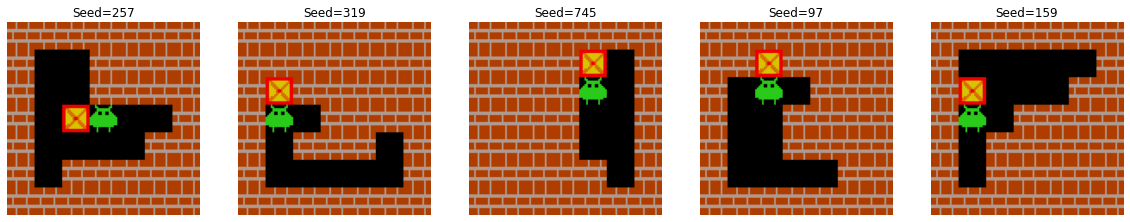

In [ ]:
fig, axs = plt.subplots(1, len(pt.trainers), figsize=(20, 4))

# loop through each image and plot it on its corresponding axis
for i, (trainer_name, trainer) in enumerate(pt.trainers.items()):
    axs[i].imshow(trainer.env.render(mode='rgb_array'))
    axs[i].axis('off')
    axs[i].set_title(f"Seed={trainer.config.seed}")

# show the plot
plt.show()

---

# EX2 - RANDOM SCENARIO - ONE BOX

## Random Agent
To establish a baseline for performance improvement, we will begin by demonstrating the performance of a random agent over 100 iterations.

Initializing DQNTrainer
Game mode: RANDOM
Initializing DQNTrainer, results will be written to results/608631e0
load predictor:RANDOM
Average results  on 100 evaluations:
	Reward=-31.72 | Steps=361.15 | Success Rate=40.00%


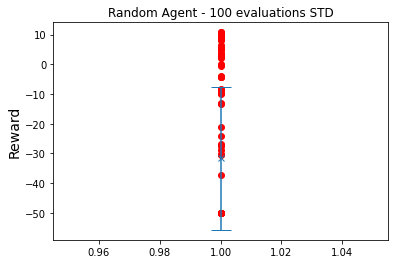

In [ ]:
cfg = TrainingCfg.get_default_config()
random_trainer_ex2 = DQNTrainer(random_scenario=True, config=cfg, print_params=False)
_ = Evaluator(random_trainer_ex2).evaluate(
    100,
    agent_name="RANDOM",
    plot_chart=True,
    chart_title="Random Agent - 100 evaluations STD")

In [ ]:
path = Evaluator(random_trainer_ex2).evaluate_and_render('ex2_random_agent', agent_name="RANDOM")

The agent solved Sokoban (RANDOM board) after 46 steps, reward=6.40


In [ ]:
preserve_video(path)

In [ ]:
embed_mp4(preserved_video_path('ex2_random_agent'))

## Parameters Tunning

#### MUST RUN FIRST

In [ ]:
pt = ParamTuner()

### γ - discount factor

In [ ]:
gamma_trainers_names = pt.tune_param(param_name='gamma', param_values=[0.1, 0.3, 0.5, 0.7, 0.9])

Tunning 'gamma':   0%|          | 0/5 [00:00<?, ?it/s]

Initializing DQNTrainer
Game mode: RANDOM
Config: TrainingCfg(max_memory_size=30000, memory_n_good_samples=10, batch_size=32, gamma=0.1, lr=0.00025, exploration_max=0.9, exploration_min=0.02, exploration_decay=0.99995, copy_weigths_every_steps=1000, early_stopping=True, early_stopping_patience=75, early_stopping_start_on_episode=30, early_stopping_delta=0)
	- max_memory_size := 30000
	- memory_n_good_samples := 10
	- batch_size := 32
	- gamma := 0.1
	- lr := 0.00025
	- exploration_max := 0.9
	- exploration_min := 0.02
	- exploration_decay := 0.99995
	- copy_weigths_every_steps := 1000
	- early_stopping := True
	- early_stopping_patience := 75
	- early_stopping_start_on_episode := 30
	- early_stopping_delta := 0

Initializing DQNTrainer, results will be written to results/fcd85352
Filling replay buffer with samples.............
Replay buffer avg Done states=0.0008333333535119891



  0%|          | 0/250 [00:00<?, ?it/s]


Episode 5:	last_reward=7.700  |  5_rewards=-21.600  |  avg_rewards=-21.600  |  avg_loss=0.0098179691  |  last_steps=33  |  avg_steps=282.0  |  eps=0.83873

Episode 10:	last_reward=5.900  |  5_rewards=-23.760  |  avg_rewards=-22.680  |  avg_loss=0.0105436202  |  last_steps=51  |  avg_steps=292.8  |  eps=0.77743

Episode 15:	last_reward=-50.000  |  5_rewards=-35.380  |  avg_rewards=-26.913  |  avg_loss=0.0099196937  |  last_steps=500  |  avg_steps=327.8  |  eps=0.70383

Episode 20:	last_reward=-50.000  |  5_rewards=-35.120  |  avg_rewards=-28.965  |  avg_loss=0.0092047201  |  last_steps=500  |  avg_steps=344.6  |  eps=0.63762

Episode 25:	last_reward=-1.200  |  5_rewards=-28.200  |  avg_rewards=-28.812  |  avg_loss=0.0090267472  |  last_steps=122  |  avg_steps=340.9  |  eps=0.58771

Episode 30:	last_reward=-50.000  |  5_rewards=-50.000  |  avg_rewards=-32.343  |  avg_loss=0.0092812236  |  last_steps=500  |  avg_steps=367.4  |  eps=0.51865

Episode 35:	last_reward=-50.000  |  5_rewards=-

  0%|          | 0/250 [00:00<?, ?it/s]


Episode 5:	last_reward=-50.000  |  5_rewards=-36.260  |  avg_rewards=-36.260  |  avg_loss=0.0084873717  |  last_steps=500  |  avg_steps=406.6  |  eps=0.81301

Episode 10:	last_reward=-50.000  |  5_rewards=-37.880  |  avg_rewards=-37.070  |  avg_loss=0.0071142903  |  last_steps=500  |  avg_steps=403.7  |  eps=0.73549

Episode 15:	last_reward=-50.000  |  5_rewards=-28.720  |  avg_rewards=-34.287  |  avg_loss=0.0063021141  |  last_steps=500  |  avg_steps=379.5  |  eps=0.67704

Episode 20:	last_reward=1.700  |  5_rewards=-24.420  |  avg_rewards=-31.820  |  avg_loss=0.0062489635  |  last_steps=93  |  avg_steps=362.2  |  eps=0.62652

Episode 25:	last_reward=7.500  |  5_rewards=-19.660  |  avg_rewards=-29.388  |  avg_loss=0.0061034989  |  last_steps=35  |  avg_steps=342.3  |  eps=0.58671

Episode 30:	last_reward=-50.000  |  5_rewards=-50.000  |  avg_rewards=-32.823  |  avg_loss=0.0065043331  |  last_steps=500  |  avg_steps=368.6  |  eps=0.51777

Episode 35:	last_reward=-50.000  |  5_rewards=

  0%|          | 0/250 [00:00<?, ?it/s]


Episode 5:	last_reward=10.700  |  5_rewards=-24.000  |  avg_rewards=-24.000  |  avg_loss=0.0055926540  |  last_steps=3  |  avg_steps=306.0  |  eps=0.83372

Episode 10:	last_reward=-50.000  |  5_rewards=-34.200  |  avg_rewards=-29.100  |  avg_loss=0.0070892824  |  last_steps=500  |  avg_steps=346.0  |  eps=0.75702

Episode 15:	last_reward=9.200  |  5_rewards=-8.840  |  avg_rewards=-22.347  |  avg_loss=0.0077693369  |  last_steps=18  |  avg_steps=289.5  |  eps=0.72436

Episode 20:	last_reward=-50.000  |  5_rewards=-38.640  |  avg_rewards=-26.420  |  avg_loss=0.0076412456  |  last_steps=500  |  avg_steps=319.2  |  eps=0.65405

Episode 25:	last_reward=-1.000  |  5_rewards=-29.760  |  avg_rewards=-27.088  |  avg_loss=0.0080217496  |  last_steps=120  |  avg_steps=323.7  |  eps=0.60051

Episode 30:	last_reward=-50.000  |  5_rewards=-50.000  |  avg_rewards=-30.907  |  avg_loss=0.0084251957  |  last_steps=500  |  avg_steps=353.1  |  eps=0.52995

Episode 35:	last_reward=-50.000  |  5_rewards=-3

  0%|          | 0/250 [00:00<?, ?it/s]


Episode 5:	last_reward=-50.000  |  5_rewards=-19.500  |  avg_rewards=-19.500  |  avg_loss=0.0064307107  |  last_steps=500  |  avg_steps=261.0  |  eps=0.84315

Episode 10:	last_reward=-50.000  |  5_rewards=-34.200  |  avg_rewards=-26.850  |  avg_loss=0.0093719447  |  last_steps=500  |  avg_steps=323.5  |  eps=0.76559

Episode 15:	last_reward=10.400  |  5_rewards=-18.640  |  avg_rewards=-24.113  |  avg_loss=0.0076270746  |  last_steps=6  |  avg_steps=299.8  |  eps=0.71877

Episode 20:	last_reward=-50.000  |  5_rewards=-35.380  |  avg_rewards=-26.930  |  avg_loss=0.0087931976  |  last_steps=500  |  avg_steps=324.3  |  eps=0.65072

Episode 25:	last_reward=-50.000  |  5_rewards=-42.920  |  avg_rewards=-30.128  |  avg_loss=0.0095425341  |  last_steps=500  |  avg_steps=349.7  |  eps=0.58131

Episode 30:	last_reward=-50.000  |  5_rewards=-45.260  |  avg_rewards=-32.650  |  avg_loss=0.0092254123  |  last_steps=500  |  avg_steps=370.5  |  eps=0.51627

Episode 35:	last_reward=-50.000  |  5_rewar

  0%|          | 0/250 [00:00<?, ?it/s]


Episode 5:	last_reward=-50.000  |  5_rewards=-50.000  |  avg_rewards=-50.000  |  avg_loss=0.0117068496  |  last_steps=500  |  avg_steps=500.0  |  eps=0.79424

Episode 10:	last_reward=-50.000  |  5_rewards=-34.500  |  avg_rewards=-42.250  |  avg_loss=0.0110024614  |  last_steps=500  |  avg_steps=444.5  |  eps=0.72064

Episode 15:	last_reward=-50.000  |  5_rewards=-46.200  |  avg_rewards=-43.567  |  avg_loss=0.0142217325  |  last_steps=500  |  avg_steps=457.7  |  eps=0.63851

Episode 20:	last_reward=-16.500  |  5_rewards=-43.300  |  avg_rewards=-43.500  |  avg_loss=0.0192524996  |  last_steps=275  |  avg_steps=457.0  |  eps=0.56986

Episode 25:	last_reward=7.000  |  5_rewards=-6.520  |  avg_rewards=-36.104  |  avg_loss=0.0238179043  |  last_steps=40  |  avg_steps=396.2  |  eps=0.54844

Episode 30:	last_reward=-50.000  |  5_rewards=-38.740  |  avg_rewards=-36.543  |  avg_loss=0.0280142371  |  last_steps=500  |  avg_steps=398.4  |  eps=0.49509

Episode 35:	last_reward=-50.000  |  5_reward

/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


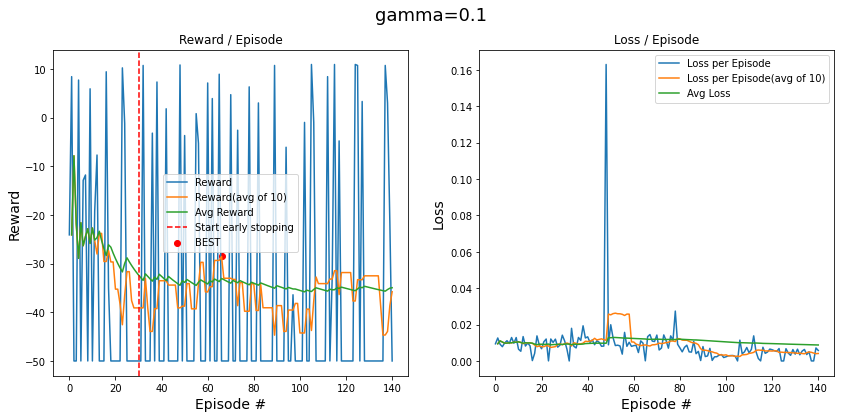

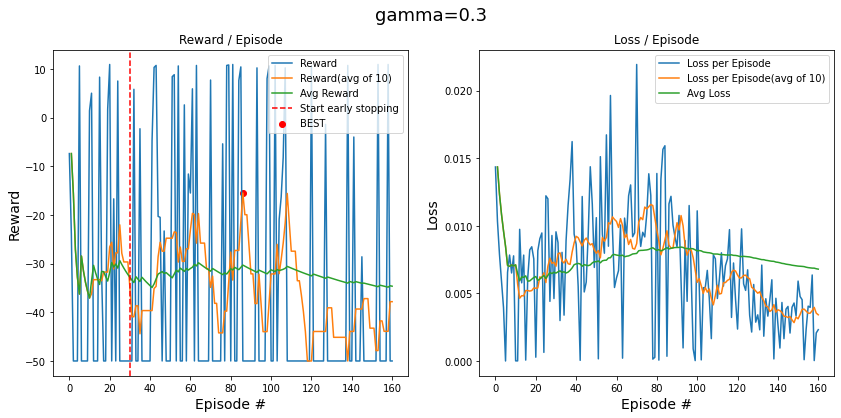

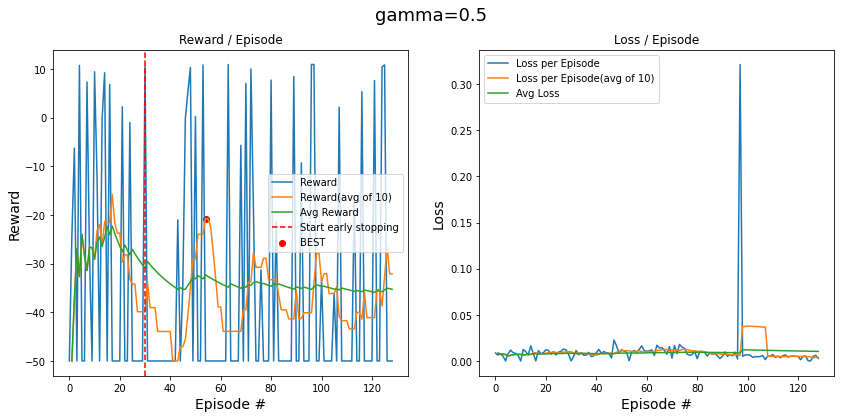

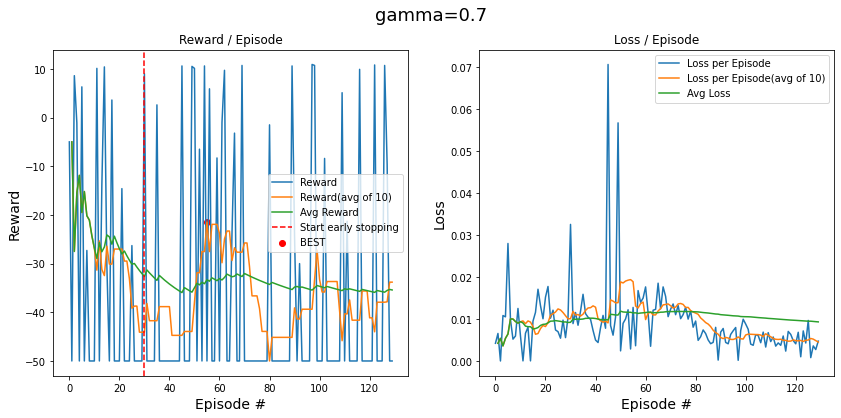

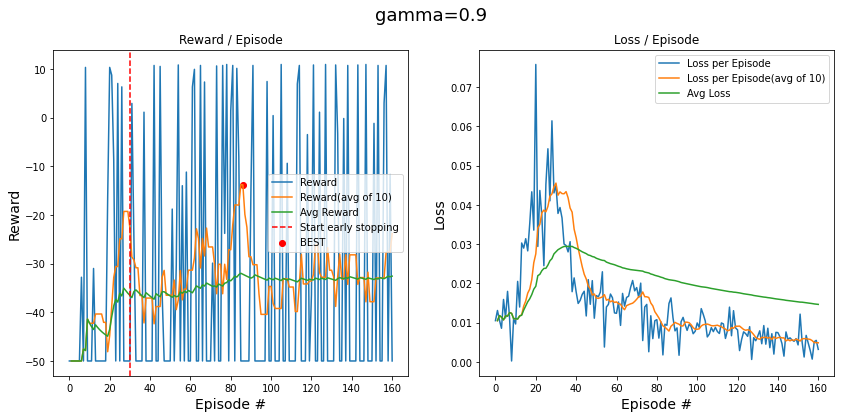

In [ ]:
pt.visualize_plots(gamma_trainers_names)

load predictor:BEST
Average results for gamma=0.1 on 100 evaluations:
	Reward=-43.32 | Steps=445.25 | Succession Rate=11.00%
load predictor:BEST
Average results for gamma=0.3 on 100 evaluations:
	Reward=-43.32 | Steps=445.30 | Succession Rate=11.00%
load predictor:BEST
Average results for gamma=0.5 on 100 evaluations:
	Reward=-44.53 | Steps=455.16 | Succession Rate=9.00%
load predictor:BEST
Average results for gamma=0.7 on 100 evaluations:
	Reward=-45.74 | Steps=465.14 | Succession Rate=7.00%
load predictor:BEST
Average results for gamma=0.9 on 100 evaluations:
	Reward=-40.88 | Steps=425.27 | Succession Rate=15.00%


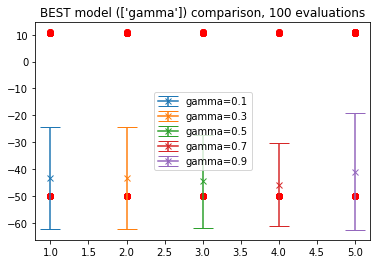

In [ ]:
pt.evaluate_n_episodes(gamma_trainers_names, n_episodes=100)

The discount factor determines the importance of future rewards relative to immediate rewards. A discount factor of 0 means the agent only cares about immediate rewards, while a discount factor of 1 means the agent cares about all future rewards equally.
In this game, reaching the terminal state is the only way the user can grab positive reward (10). Therefore, we must set the discount factor to aim to 1, in order to reach the terminal state, while the local rewards are always -0.1.

**As it can be seen from the above plots, `γ=0.9` gives us the best convergence process (according to the loss plot) and on the other hand reaches the bes success rate.**

The large discount factor helps with convergence of the value function and policy. This is because it encourages the agent to consider a wider range of future rewards, leading to a more stable and consistent estimate of the value of a state and action.

### LR -Learning Rate

In [ ]:
lr_trainers_names = pt.tune_param(param_name='lr', param_values=[0.025, 0.0025, 0.00025, 0.000025])

Tunning 'lr':   0%|          | 0/4 [00:00<?, ?it/s]

Initializing DQNTrainer
Game mode: RANDOM
Config: TrainingCfg(max_memory_size=30000, memory_n_good_samples=10, batch_size=32, gamma=0.3, lr=0.025, exploration_max=0.9, exploration_min=0.02, exploration_decay=0.99995, copy_weigths_every_steps=1000, early_stopping=True, early_stopping_patience=75, early_stopping_start_on_episode=30, early_stopping_delta=0)
	- max_memory_size := 30000
	- memory_n_good_samples := 10
	- batch_size := 32
	- gamma := 0.3
	- lr := 0.025
	- exploration_max := 0.9
	- exploration_min := 0.02
	- exploration_decay := 0.99995
	- copy_weigths_every_steps := 1000
	- early_stopping := True
	- early_stopping_patience := 75
	- early_stopping_start_on_episode := 30
	- early_stopping_delta := 0

Initializing DQNTrainer, results will be written to results/14e77be6
Filling replay buffer with samples..............
Replay buffer avg Done states=0.0008666666690260172



  0%|          | 0/250 [00:00<?, ?it/s]


Episode 5:	last_reward=2.800  |  5_rewards=-8.120  |  avg_rewards=-8.120  |  avg_loss=0.6067807674  |  last_steps=82  |  avg_steps=169.2  |  eps=0.86272

Episode 10:	last_reward=-50.000  |  5_rewards=-34.880  |  avg_rewards=-21.500  |  avg_loss=0.3087354898  |  last_steps=500  |  avg_steps=281.0  |  eps=0.78203

Episode 15:	last_reward=-50.000  |  5_rewards=-36.040  |  avg_rewards=-26.347  |  avg_loss=0.2111396641  |  last_steps=500  |  avg_steps=322.1  |  eps=0.70683

Episode 20:	last_reward=9.900  |  5_rewards=-5.800  |  avg_rewards=-21.210  |  avg_loss=0.1617027372  |  last_steps=11  |  avg_steps=278.1  |  eps=0.68149

Episode 25:	last_reward=-50.000  |  5_rewards=-31.200  |  avg_rewards=-23.208  |  avg_loss=0.1323171109  |  last_steps=500  |  avg_steps=293.7  |  eps=0.62346

Episode 30:	last_reward=-50.000  |  5_rewards=-50.000  |  avg_rewards=-27.673  |  avg_loss=0.1126020327  |  last_steps=500  |  avg_steps=328.1  |  eps=0.55020

Episode 35:	last_reward=-50.000  |  5_rewards=-43

  0%|          | 0/250 [00:00<?, ?it/s]


Episode 5:	last_reward=-31.200  |  5_rewards=-22.440  |  avg_rewards=-22.440  |  avg_loss=0.0074228197  |  last_steps=422  |  avg_steps=290.4  |  eps=0.83697

Episode 10:	last_reward=-50.000  |  5_rewards=-22.840  |  avg_rewards=-22.640  |  avg_loss=0.0088872220  |  last_steps=500  |  avg_steps=292.4  |  eps=0.77758

Episode 15:	last_reward=9.500  |  5_rewards=-26.860  |  avg_rewards=-24.047  |  avg_loss=0.0110910805  |  last_steps=15  |  avg_steps=299.1  |  eps=0.71913

Episode 20:	last_reward=10.300  |  5_rewards=-27.640  |  avg_rewards=-24.945  |  avg_loss=0.0108746048  |  last_steps=7  |  avg_steps=309.9  |  eps=0.66013

Episode 25:	last_reward=-50.000  |  5_rewards=-38.720  |  avg_rewards=-27.700  |  avg_loss=0.0120075550  |  last_steps=500  |  avg_steps=329.8  |  eps=0.59594

Episode 30:	last_reward=-50.000  |  5_rewards=-19.860  |  avg_rewards=-26.393  |  avg_loss=0.0120469183  |  last_steps=500  |  avg_steps=318.9  |  eps=0.55779

Episode 35:	last_reward=-50.000  |  5_rewards=

  0%|          | 0/250 [00:00<?, ?it/s]


Episode 5:	last_reward=9.900  |  5_rewards=-18.460  |  avg_rewards=-18.460  |  avg_loss=0.0167616587  |  last_steps=11  |  avg_steps=250.6  |  eps=0.84534

Episode 10:	last_reward=9.000  |  5_rewards=-27.860  |  avg_rewards=-23.160  |  avg_loss=0.0172148235  |  last_steps=20  |  avg_steps=286.6  |  eps=0.77984

Episode 15:	last_reward=-15.800  |  5_rewards=-34.100  |  avg_rewards=-26.807  |  avg_loss=0.0192557536  |  last_steps=268  |  avg_steps=319.4  |  eps=0.70828

Episode 20:	last_reward=10.900  |  5_rewards=-5.580  |  avg_rewards=-21.500  |  avg_loss=0.0174273737  |  last_steps=1  |  avg_steps=275.5  |  eps=0.68327

Episode 25:	last_reward=-50.000  |  5_rewards=-41.740  |  avg_rewards=-25.548  |  avg_loss=0.0173208211  |  last_steps=500  |  avg_steps=308.3  |  eps=0.61219

Episode 30:	last_reward=-50.000  |  5_rewards=-33.360  |  avg_rewards=-26.850  |  avg_loss=0.0175894573  |  last_steps=500  |  avg_steps=319.8  |  eps=0.55704

Episode 35:	last_reward=-4.700  |  5_rewards=-20.7

  0%|          | 0/250 [00:00<?, ?it/s]


Episode 5:	last_reward=3.300  |  5_rewards=-9.620  |  avg_rewards=-9.620  |  avg_loss=0.0073344437  |  last_steps=77  |  avg_steps=184.2  |  eps=0.85949

Episode 10:	last_reward=-50.000  |  5_rewards=-33.000  |  avg_rewards=-21.310  |  avg_loss=0.0074332482  |  last_steps=500  |  avg_steps=279.1  |  eps=0.78277

Episode 15:	last_reward=-50.000  |  5_rewards=-13.520  |  avg_rewards=-18.713  |  avg_loss=0.0061858660  |  last_steps=500  |  avg_steps=253.1  |  eps=0.74437

Episode 20:	last_reward=10.400  |  5_rewards=-37.920  |  avg_rewards=-23.515  |  avg_loss=0.0063823550  |  last_steps=6  |  avg_steps=290.1  |  eps=0.67333

Episode 25:	last_reward=-50.000  |  5_rewards=-45.120  |  avg_rewards=-27.836  |  avg_loss=0.0069895592  |  last_steps=500  |  avg_steps=326.8  |  eps=0.59821

Episode 30:	last_reward=-50.000  |  5_rewards=-38.640  |  avg_rewards=-29.637  |  avg_loss=0.0080453772  |  last_steps=500  |  avg_steps=340.4  |  eps=0.54014

Episode 35:	last_reward=-50.000  |  5_rewards=-2

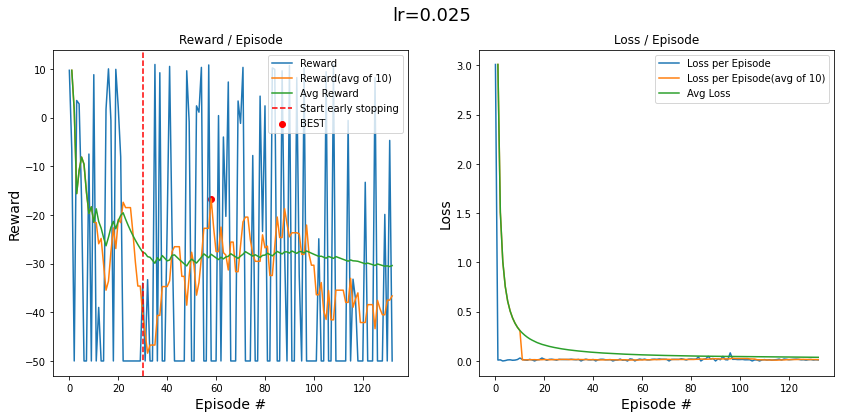

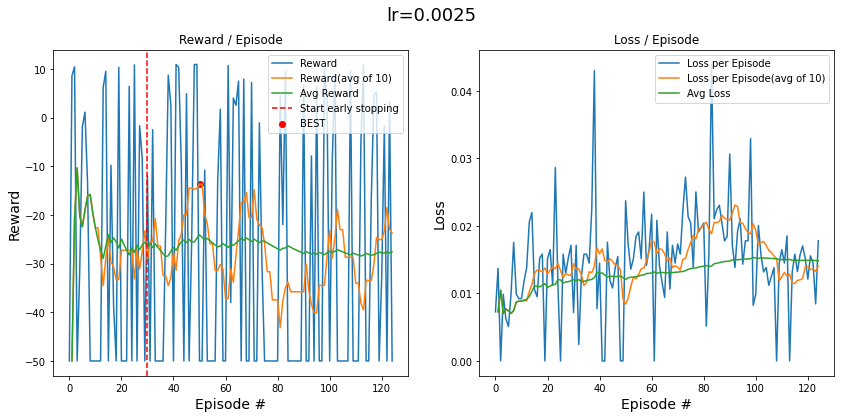

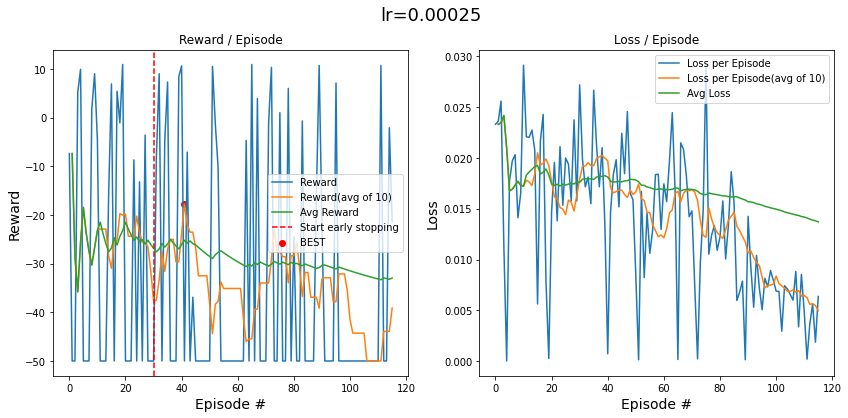

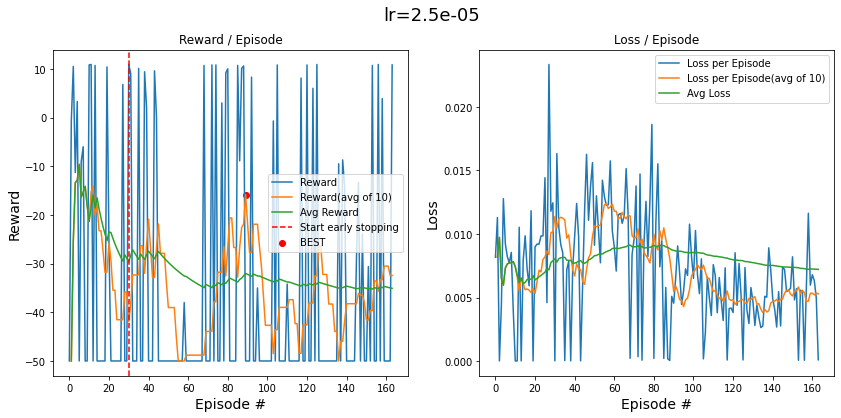

In [ ]:
pt.visualize_plots(lr_trainers_names)

load predictor:BEST
Average results for lr=0.025 on 100 evaluations:
	Reward=-46.35 | Steps=470.11 | Succession Rate=6.00%
load predictor:BEST
Average results for lr=0.0025 on 100 evaluations:
	Reward=-42.72 | Steps=440.35 | Succession Rate=12.00%
load predictor:BEST
Average results for lr=0.00025 on 100 evaluations:
	Reward=-45.14 | Steps=460.20 | Succession Rate=8.00%
load predictor:BEST
Average results for lr=2.5e-05 on 100 evaluations:
	Reward=-40.89 | Steps=425.35 | Succession Rate=15.00%


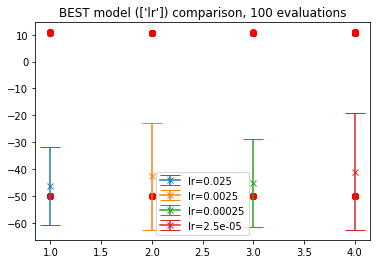

In [ ]:
pt.evaluate_n_episodes(lr_trainers_names, n_episodes=100)

Learning rate 0.025, 0.0025 didn't converge.

### Replay Buffer Size

In [ ]:
r_b_size_trainers_names = pt.tune_param(param_name='max_memory_size', param_values=[1000, 10000, 30000, 50000])

Tunning 'max_memory_size':   0%|          | 0/4 [00:00<?, ?it/s]

Initializing DQNTrainer
Game mode: RANDOM
Config: TrainingCfg(max_memory_size=1000, memory_n_good_samples=10, batch_size=32, gamma=0.3, lr=0.00025, exploration_max=0.9, exploration_min=0.02, exploration_decay=0.99995, copy_weigths_every_steps=1000, early_stopping=True, early_stopping_patience=75, early_stopping_start_on_episode=30, early_stopping_delta=0)
	- max_memory_size := 1000
	- memory_n_good_samples := 10
	- batch_size := 32
	- gamma := 0.3
	- lr := 0.00025
	- exploration_max := 0.9
	- exploration_min := 0.02
	- exploration_decay := 0.99995
	- copy_weigths_every_steps := 1000
	- early_stopping := True
	- early_stopping_patience := 75
	- early_stopping_start_on_episode := 30
	- early_stopping_delta := 0

Initializing DQNTrainer, results will be written to results/d786eede
Filling replay buffer with samples..........
Replay buffer avg Done states=0.013000000268220901



  0%|          | 0/250 [00:00<?, ?it/s]


Episode 5:	last_reward=-50.000  |  5_rewards=-50.000  |  avg_rewards=-50.000  |  avg_loss=0.0370726064  |  last_steps=500  |  avg_steps=500.0  |  eps=0.79424

Episode 10:	last_reward=-11.200  |  5_rewards=-7.640  |  avg_rewards=-28.820  |  avg_loss=0.0246206149  |  last_steps=222  |  avg_steps=332.2  |  eps=0.76226

Episode 15:	last_reward=8.500  |  5_rewards=-27.240  |  avg_rewards=-28.293  |  avg_loss=0.0248956904  |  last_steps=25  |  avg_steps=334.3  |  eps=0.70043

Episode 20:	last_reward=-50.000  |  5_rewards=-26.300  |  avg_rewards=-27.795  |  avg_loss=0.0205946937  |  last_steps=500  |  avg_steps=327.4  |  eps=0.64868

Episode 25:	last_reward=0.700  |  5_rewards=-24.140  |  avg_rewards=-27.064  |  avg_loss=0.0183076803  |  last_steps=103  |  avg_steps=323.4  |  eps=0.60069

Episode 30:	last_reward=-23.800  |  5_rewards=-44.760  |  avg_rewards=-30.013  |  avg_loss=0.0161815882  |  last_steps=348  |  avg_steps=347.8  |  eps=0.53415

Episode 35:	last_reward=-50.000  |  5_rewards=

  0%|          | 0/250 [00:00<?, ?it/s]


Episode 5:	last_reward=-50.000  |  5_rewards=-50.000  |  avg_rewards=-50.000  |  avg_loss=0.0112347361  |  last_steps=500  |  avg_steps=500.0  |  eps=0.79424

Episode 10:	last_reward=5.600  |  5_rewards=-38.880  |  avg_rewards=-44.440  |  avg_loss=0.0079212682  |  last_steps=54  |  avg_steps=455.4  |  eps=0.71672

Episode 15:	last_reward=7.500  |  5_rewards=-27.460  |  avg_rewards=-38.780  |  avg_loss=0.0078991335  |  last_steps=35  |  avg_steps=409.8  |  eps=0.66185

Episode 20:	last_reward=-50.000  |  5_rewards=-25.380  |  avg_rewards=-35.430  |  avg_loss=0.0099324249  |  last_steps=500  |  avg_steps=387.3  |  eps=0.61099

Episode 25:	last_reward=-1.700  |  5_rewards=-4.780  |  avg_rewards=-29.300  |  avg_loss=0.0092597948  |  last_steps=127  |  avg_steps=337.0  |  eps=0.59060

Episode 30:	last_reward=-1.100  |  5_rewards=-40.220  |  avg_rewards=-31.120  |  avg_loss=0.0096548954  |  last_steps=121  |  avg_steps=351.5  |  eps=0.53117

Episode 35:	last_reward=-50.000  |  5_rewards=-40

  0%|          | 0/250 [00:00<?, ?it/s]


Episode 5:	last_reward=-0.500  |  5_rewards=-9.880  |  avg_rewards=-9.880  |  avg_loss=0.0110132247  |  last_steps=115  |  avg_steps=186.8  |  eps=0.85894

Episode 10:	last_reward=-50.000  |  5_rewards=-15.620  |  avg_rewards=-12.750  |  avg_loss=0.0096038952  |  last_steps=500  |  avg_steps=204.5  |  eps=0.81252

Episode 15:	last_reward=-50.000  |  5_rewards=-28.000  |  avg_rewards=-17.833  |  avg_loss=0.0091594420  |  last_steps=500  |  avg_steps=244.3  |  eps=0.74930

Episode 20:	last_reward=-6.300  |  5_rewards=-18.980  |  avg_rewards=-18.120  |  avg_loss=0.0096155154  |  last_steps=173  |  avg_steps=247.2  |  eps=0.70288

Episode 25:	last_reward=-50.000  |  5_rewards=-50.000  |  avg_rewards=-24.496  |  avg_loss=0.0097360956  |  last_steps=500  |  avg_steps=297.8  |  eps=0.62029

Episode 30:	last_reward=-1.200  |  5_rewards=-23.400  |  avg_rewards=-24.313  |  avg_loss=0.0100714080  |  last_steps=122  |  avg_steps=298.1  |  eps=0.57547

Episode 35:	last_reward=-10.700  |  5_rewards

  0%|          | 0/250 [00:00<?, ?it/s]


Episode 5:	last_reward=-50.000  |  5_rewards=-41.500  |  avg_rewards=-41.500  |  avg_loss=0.0047109337  |  last_steps=500  |  avg_steps=437.0  |  eps=0.80685

Episode 10:	last_reward=-50.000  |  5_rewards=-20.820  |  avg_rewards=-31.160  |  avg_loss=0.0043961266  |  last_steps=500  |  avg_steps=355.6  |  eps=0.75340

Episode 15:	last_reward=-50.000  |  5_rewards=-34.320  |  avg_rewards=-32.213  |  avg_loss=0.0042187488  |  last_steps=500  |  avg_steps=366.1  |  eps=0.68388

Episode 20:	last_reward=7.300  |  5_rewards=-20.740  |  avg_rewards=-29.345  |  avg_loss=0.0049614268  |  last_steps=37  |  avg_steps=342.9  |  eps=0.63870

Episode 25:	last_reward=-50.000  |  5_rewards=-37.840  |  avg_rewards=-31.044  |  avg_loss=0.0048066815  |  last_steps=500  |  avg_steps=354.4  |  eps=0.57786

Episode 30:	last_reward=-4.600  |  5_rewards=-29.880  |  avg_rewards=-30.850  |  avg_loss=0.0048347008  |  last_steps=156  |  avg_steps=352.5  |  eps=0.53040

Episode 35:	last_reward=5.800  |  5_rewards=

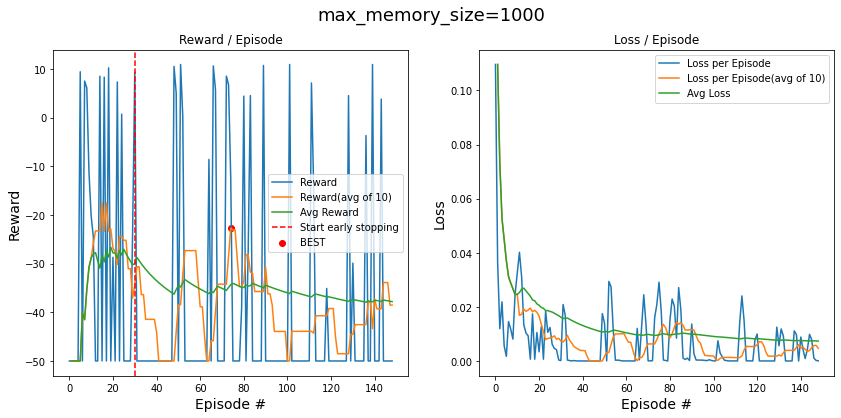

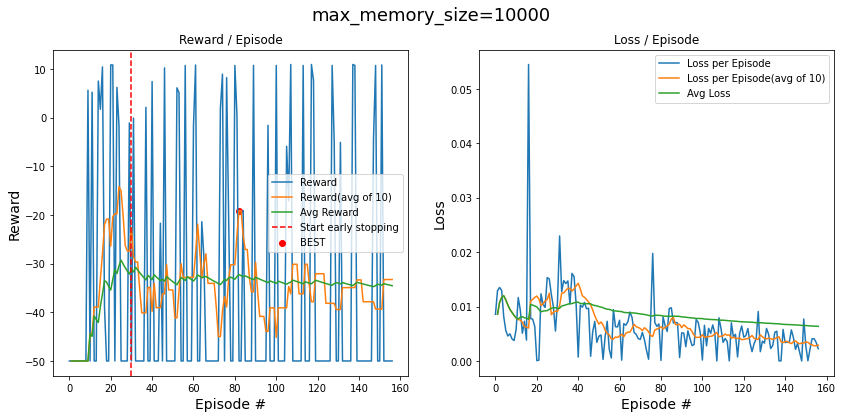

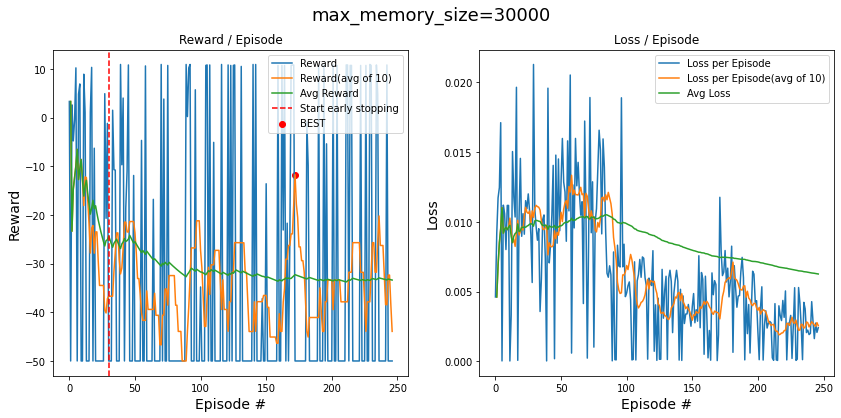

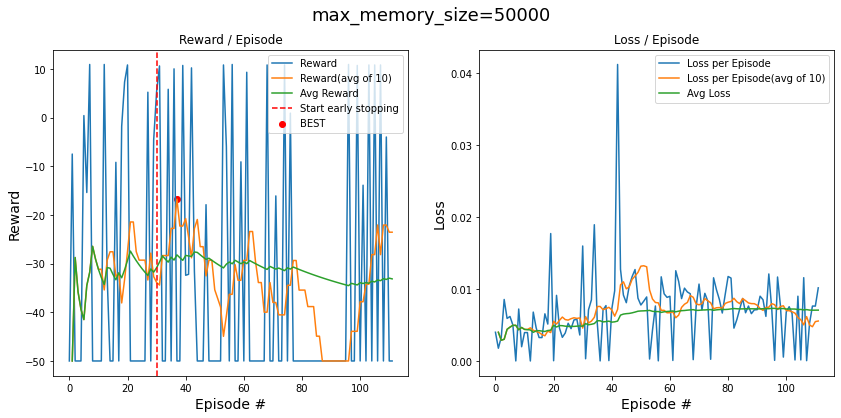

In [ ]:
pt.visualize_plots(r_b_size_trainers_names)

load predictor:BEST
Average results for max_memory_size=1000 on 100 evaluations:
	Reward=-42.10 | Steps=435.33 | Succession Rate=13.00%
load predictor:BEST
Average results for max_memory_size=10000 on 100 evaluations:
	Reward=-39.67 | Steps=415.41 | Succession Rate=17.00%
load predictor:BEST
Average results for max_memory_size=30000 on 100 evaluations:
	Reward=-40.28 | Steps=420.40 | Succession Rate=16.00%
load predictor:BEST
Average results for max_memory_size=50000 on 100 evaluations:
	Reward=-45.13 | Steps=460.14 | Succession Rate=8.00%


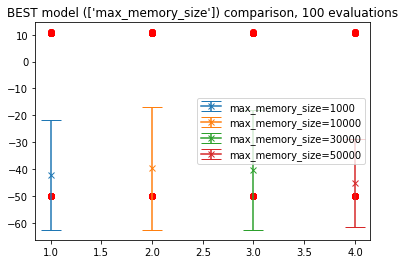

In [ ]:
pt.evaluate_n_episodes(r_b_size_trainers_names, n_episodes=100)

he replay buffer plays a crucial role in the training process, as a larger buffer with a greater variety of stored samples led to improved DQN performance.

### Batch Size

In [ ]:
batch_size_trainers_names = pt.tune_param(param_name='batch_size', param_values=[1, 16, 32, 256])

Tunning 'batch_size':   0%|          | 0/4 [00:00<?, ?it/s]

Initializing DQNTrainer
Game mode: RANDOM
Config: TrainingCfg(max_memory_size=30000, memory_n_good_samples=10, batch_size=1, gamma=0.3, lr=0.00025, exploration_max=0.9, exploration_min=0.02, exploration_decay=0.99995, copy_weigths_every_steps=1000, early_stopping=True, early_stopping_patience=75, early_stopping_start_on_episode=30, early_stopping_delta=0)
	- max_memory_size := 30000
	- memory_n_good_samples := 10
	- batch_size := 1
	- gamma := 0.3
	- lr := 0.00025
	- exploration_max := 0.9
	- exploration_min := 0.02
	- exploration_decay := 0.99995
	- copy_weigths_every_steps := 1000
	- early_stopping := True
	- early_stopping_patience := 75
	- early_stopping_start_on_episode := 30
	- early_stopping_delta := 0

Initializing DQNTrainer, results will be written to results/e5efa766
Filling replay buffer with samples..........
Replay buffer avg Done states=0.0006000000284984708



  0%|          | 0/250 [00:00<?, ?it/s]


Episode 5:	last_reward=-50.000  |  5_rewards=-28.280  |  avg_rewards=-28.280  |  avg_loss=0.0042735143  |  last_steps=500  |  avg_steps=326.8  |  eps=0.82939

Episode 10:	last_reward=4.900  |  5_rewards=-39.020  |  avg_rewards=-33.650  |  avg_loss=0.0042580371  |  last_steps=61  |  avg_steps=369.5  |  eps=0.74818

Episode 15:	last_reward=-9.200  |  5_rewards=-11.900  |  avg_rewards=-26.400  |  avg_loss=0.0028428952  |  last_steps=202  |  avg_steps=315.3  |  eps=0.71044

Episode 20:	last_reward=6.900  |  5_rewards=-2.400  |  avg_rewards=-20.400  |  avg_loss=0.0021347923  |  last_steps=41  |  avg_steps=270.0  |  eps=0.68704

Episode 25:	last_reward=-50.000  |  5_rewards=-37.580  |  avg_rewards=-23.836  |  avg_loss=0.0025579166  |  last_steps=500  |  avg_steps=300.0  |  eps=0.61859

Episode 30:	last_reward=-50.000  |  5_rewards=-23.780  |  avg_rewards=-23.827  |  avg_loss=0.0035429855  |  last_steps=500  |  avg_steps=300.6  |  eps=0.57334

Episode 35:	last_reward=-22.400  |  5_rewards=-2

  0%|          | 0/250 [00:00<?, ?it/s]


Episode 5:	last_reward=-24.400  |  5_rewards=-44.880  |  avg_rewards=-44.880  |  avg_loss=0.0092919478  |  last_steps=354  |  avg_steps=470.8  |  eps=0.80006

Episode 10:	last_reward=9.900  |  5_rewards=-32.520  |  avg_rewards=-38.700  |  avg_loss=0.0076832613  |  last_steps=11  |  avg_steps=420.0  |  eps=0.72952

Episode 15:	last_reward=-8.300  |  5_rewards=-25.380  |  avg_rewards=-34.260  |  avg_loss=0.0095868744  |  last_steps=193  |  avg_steps=386.6  |  eps=0.67347

Episode 20:	last_reward=-17.000  |  5_rewards=-36.760  |  avg_rewards=-34.885  |  avg_loss=0.0096873762  |  last_steps=280  |  avg_steps=392.9  |  eps=0.60761

Episode 25:	last_reward=-4.100  |  5_rewards=-21.200  |  avg_rewards=-32.148  |  avg_loss=0.0100044869  |  last_steps=151  |  avg_steps=369.9  |  eps=0.56682

Episode 30:	last_reward=-50.000  |  5_rewards=-17.400  |  avg_rewards=-29.690  |  avg_loss=0.0117729185  |  last_steps=500  |  avg_steps=348.2  |  eps=0.53381

Episode 35:	last_reward=-50.000  |  5_rewards

  0%|          | 0/250 [00:00<?, ?it/s]


Episode 5:	last_reward=5.300  |  5_rewards=-17.340  |  avg_rewards=-17.340  |  avg_loss=0.0107930899  |  last_steps=57  |  avg_steps=239.4  |  eps=0.84771

Episode 10:	last_reward=6.600  |  5_rewards=-8.380  |  avg_rewards=-12.860  |  avg_loss=0.0077389218  |  last_steps=44  |  avg_steps=205.6  |  eps=0.81207

Episode 15:	last_reward=10.000  |  5_rewards=-25.840  |  avg_rewards=-17.187  |  avg_loss=0.0073270737  |  last_steps=10  |  avg_steps=237.9  |  eps=0.75294

Episode 20:	last_reward=4.700  |  5_rewards=-4.820  |  avg_rewards=-14.095  |  avg_loss=0.0095354589  |  last_steps=63  |  avg_steps=212.4  |  eps=0.72774

Episode 25:	last_reward=-50.000  |  5_rewards=-25.600  |  avg_rewards=-16.396  |  avg_loss=0.0101794805  |  last_steps=500  |  avg_steps=234.4  |  eps=0.67145

Episode 30:	last_reward=-50.000  |  5_rewards=-21.400  |  avg_rewards=-17.230  |  avg_loss=0.0101287328  |  last_steps=500  |  avg_steps=242.0  |  eps=0.62605

Episode 35:	last_reward=-50.000  |  5_rewards=-45.520

  0%|          | 0/250 [00:00<?, ?it/s]


Episode 5:	last_reward=-50.000  |  5_rewards=-50.000  |  avg_rewards=-50.000  |  avg_loss=0.0055780383  |  last_steps=500  |  avg_steps=500.0  |  eps=0.79424

Episode 10:	last_reward=-50.000  |  5_rewards=-26.760  |  avg_rewards=-38.380  |  avg_loss=0.0048647905  |  last_steps=500  |  avg_steps=416.8  |  eps=0.73069

Episode 15:	last_reward=7.000  |  5_rewards=-28.560  |  avg_rewards=-35.107  |  avg_loss=0.0047521465  |  last_steps=40  |  avg_steps=387.7  |  eps=0.67289

Episode 20:	last_reward=-50.000  |  5_rewards=-35.680  |  avg_rewards=-35.250  |  avg_loss=0.0050269552  |  last_steps=500  |  avg_steps=391.0  |  eps=0.60874

Episode 25:	last_reward=-50.000  |  5_rewards=-37.820  |  avg_rewards=-35.764  |  avg_loss=0.0045877872  |  last_steps=500  |  avg_steps=392.8  |  eps=0.55078

Episode 30:	last_reward=-50.000  |  5_rewards=-50.000  |  avg_rewards=-38.137  |  avg_loss=0.0043242192  |  last_steps=500  |  avg_steps=410.7  |  eps=0.48606

Episode 35:	last_reward=-32.200  |  5_rewar

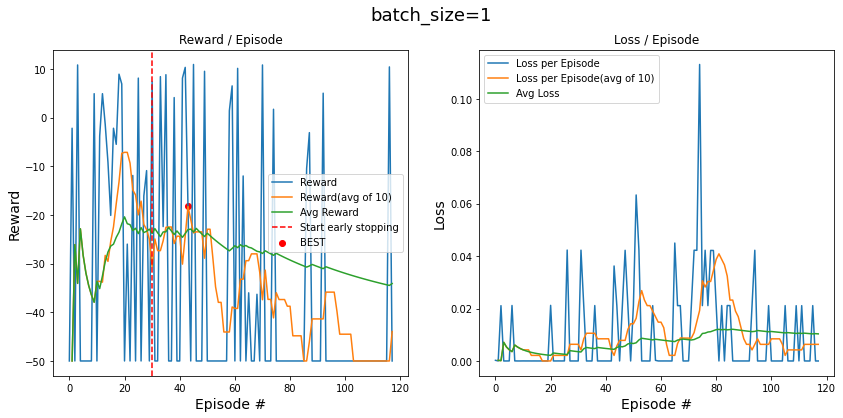

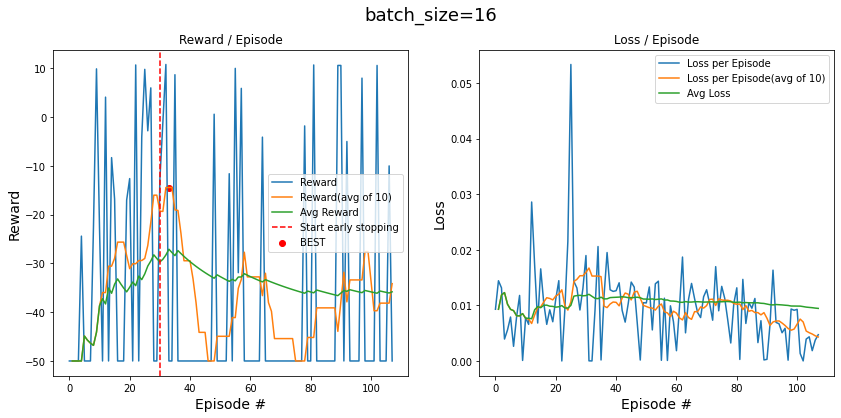

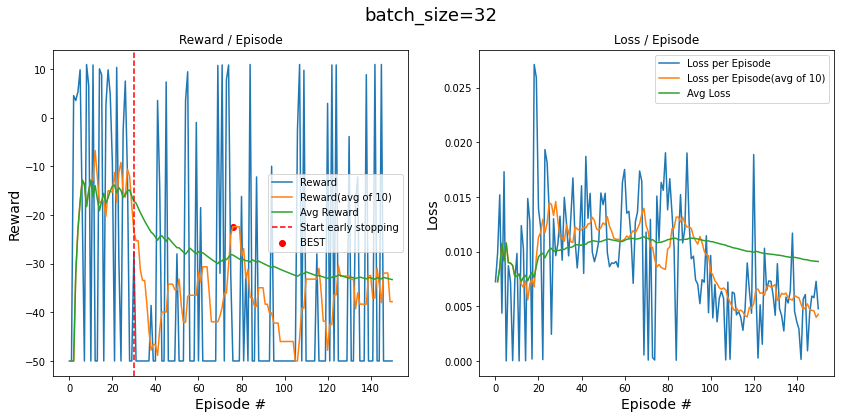

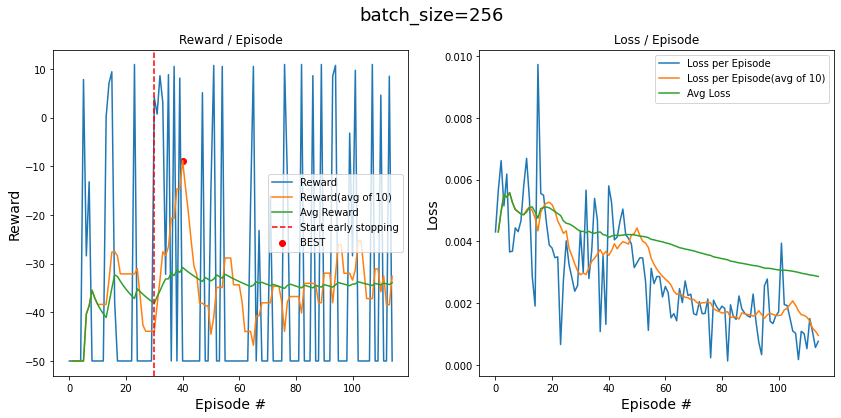

In [ ]:
pt.visualize_plots(batch_size_trainers_names)

load predictor:BEST
Average results for batch_size=1 on 100 evaluations:
	Reward=-48.18 | Steps=485.07 | Succession Rate=3.00%
load predictor:BEST
Average results for batch_size=16 on 100 evaluations:
	Reward=-44.53 | Steps=455.15 | Succession Rate=9.00%
load predictor:BEST
Average results for batch_size=32 on 100 evaluations:
	Reward=-44.53 | Steps=455.16 | Succession Rate=9.00%
load predictor:BEST
Average results for batch_size=256 on 100 evaluations:
	Reward=-45.13 | Steps=460.12 | Succession Rate=8.00%


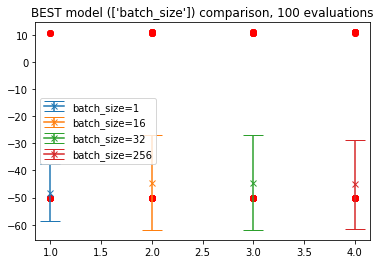

In [ ]:
pt.evaluate_n_episodes(batch_size_trainers_names, n_episodes=100)

There's a balance between the batch size and the GPU memory, we'll stay with 32.

### ε - greedy (max)
Maximum exploration rate (At the beginning of the training).

In [ ]:
e_max_trainers_names = pt.tune_param(
    param_name='exploration_max',
    param_values=[0.3, 0.5, 0.9],
    overide_params={'fill_replay_buffer':False}
    )

Tunning 'exploration_max':   0%|          | 0/3 [00:00<?, ?it/s]

Initializing DQNTrainer
Game mode: RANDOM
Config: TrainingCfg(max_memory_size=30000, fill_replay_buffer=False, memory_n_good_samples=10, batch_size=32, gamma=0.3, lr=0.00025, exploration_max=0.3, exploration_min=0.02, exploration_decay=0.99995, copy_weigths_every_steps=1000, early_stopping=True, early_stopping_patience=75, early_stopping_start_on_episode=30, early_stopping_delta=0, reward_shaping=SokobanRewardShaping(no_move_punishment=None, move_no_move_punishment=None, push_without_pushing=None, distance_box_target=None), optimizer='ADAM', loss='l1', nn_arch='DQNNetwork', random_scenario=True, max_episodes=250)
	- max_memory_size := 30000
	- fill_replay_buffer := False
	- memory_n_good_samples := 10
	- batch_size := 32
	- gamma := 0.3
	- lr := 0.00025
	- exploration_max := 0.3
	- exploration_min := 0.02
	- exploration_decay := 0.99995
	- copy_weigths_every_steps := 1000
	- early_stopping := True
	- early_stopping_patience := 75
	- early_stopping_start_on_episode := 30
	- early_stoppi

  0%|          | 0/250 [00:00<?, ?it/s]


Episode 5:	last_reward=-50.000  |  5_rewards=-50.000  |  avg_rewards=-50.000  |  avg_loss=0.0000203063  |  last_steps=500  |  avg_steps=500.0  |  eps=0.26516

Episode 10:	last_reward=-50.000  |  5_rewards=-50.000  |  avg_rewards=-50.000  |  avg_loss=0.0000104414  |  last_steps=500  |  avg_steps=500.0  |  eps=0.23400

Episode 15:	last_reward=-11.200  |  5_rewards=-24.160  |  avg_rewards=-41.387  |  avg_loss=0.0002306561  |  last_steps=222  |  avg_steps=435.9  |  eps=0.21668

Episode 20:	last_reward=-50.000  |  5_rewards=-42.240  |  avg_rewards=-41.600  |  avg_loss=0.0012396833  |  last_steps=500  |  avg_steps=438.0  |  eps=0.19390

Episode 25:	last_reward=-50.000  |  5_rewards=-50.000  |  avg_rewards=-43.280  |  avg_loss=0.0015415602  |  last_steps=500  |  avg_steps=450.4  |  eps=0.17111

Episode 30:	last_reward=-4.900  |  5_rewards=-23.280  |  avg_rewards=-39.947  |  avg_loss=0.0018069996  |  last_steps=159  |  avg_steps=425.1  |  eps=0.15880

Episode 35:	last_reward=-50.000  |  5_rew

  0%|          | 0/250 [00:00<?, ?it/s]


Episode 5:	last_reward=6.800  |  5_rewards=-38.640  |  avg_rewards=-38.640  |  avg_loss=0.0000224529  |  last_steps=42  |  avg_steps=408.4  |  eps=0.45217

Episode 10:	last_reward=10.700  |  5_rewards=-33.860  |  avg_rewards=-36.250  |  avg_loss=0.0038846970  |  last_steps=3  |  avg_steps=395.5  |  eps=0.41092

Episode 15:	last_reward=-32.800  |  5_rewards=-46.560  |  avg_rewards=-39.687  |  avg_loss=0.0042775916  |  last_steps=438  |  avg_steps=426.2  |  eps=0.36376

Episode 20:	last_reward=-50.000  |  5_rewards=-50.000  |  avg_rewards=-42.265  |  avg_loss=0.0046810392  |  last_steps=500  |  avg_steps=444.6  |  eps=0.32102

Episode 25:	last_reward=-50.000  |  5_rewards=-38.960  |  avg_rewards=-41.604  |  avg_loss=0.0041841179  |  last_steps=500  |  avg_steps=438.0  |  eps=0.28963

Episode 30:	last_reward=-50.000  |  5_rewards=-43.140  |  avg_rewards=-41.860  |  avg_loss=0.0041719202  |  last_steps=500  |  avg_steps=440.6  |  eps=0.25859

Episode 35:	last_reward=-50.000  |  5_rewards=

  0%|          | 0/250 [00:00<?, ?it/s]


Episode 5:	last_reward=1.900  |  5_rewards=-32.560  |  avg_rewards=-32.560  |  avg_loss=0.0020312552  |  last_steps=91  |  avg_steps=369.6  |  eps=0.82184

Episode 10:	last_reward=-50.000  |  5_rewards=-27.360  |  avg_rewards=-29.960  |  avg_loss=0.0069430437  |  last_steps=500  |  avg_steps=354.6  |  eps=0.75494

Episode 15:	last_reward=10.800  |  5_rewards=-23.760  |  avg_rewards=-27.893  |  avg_loss=0.0081195209  |  last_steps=2  |  avg_steps=344.9  |  eps=0.69592

Episode 20:	last_reward=10.600  |  5_rewards=-33.900  |  avg_rewards=-29.395  |  avg_loss=0.0084484315  |  last_steps=4  |  avg_steps=354.4  |  eps=0.63238

Episode 25:	last_reward=-50.000  |  5_rewards=-37.860  |  avg_rewards=-31.088  |  avg_loss=0.0083145066  |  last_steps=500  |  avg_steps=363.7  |  eps=0.57211

Episode 30:	last_reward=-50.000  |  5_rewards=-50.000  |  avg_rewards=-34.240  |  avg_loss=0.0080011259  |  last_steps=500  |  avg_steps=386.4  |  eps=0.50488

Episode 35:	last_reward=-37.800  |  5_rewards=-31

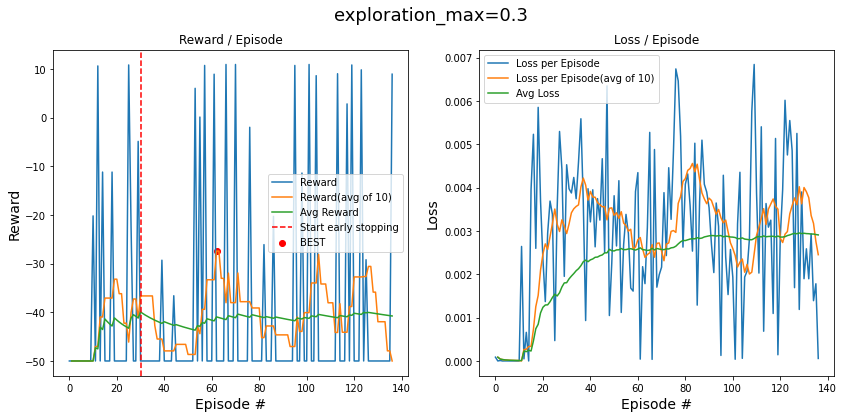

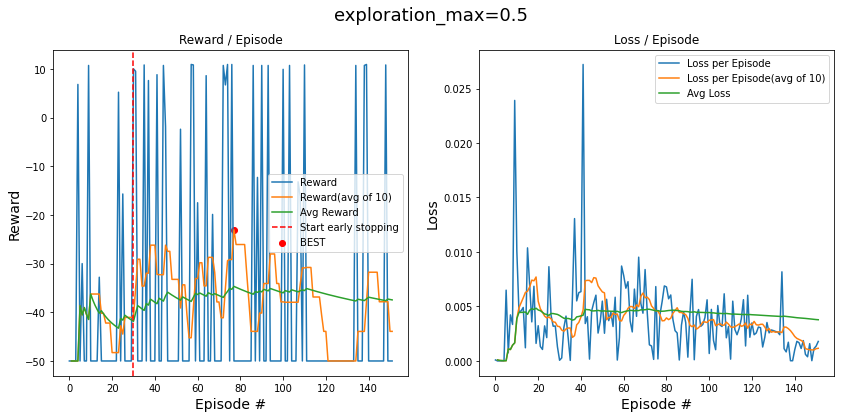

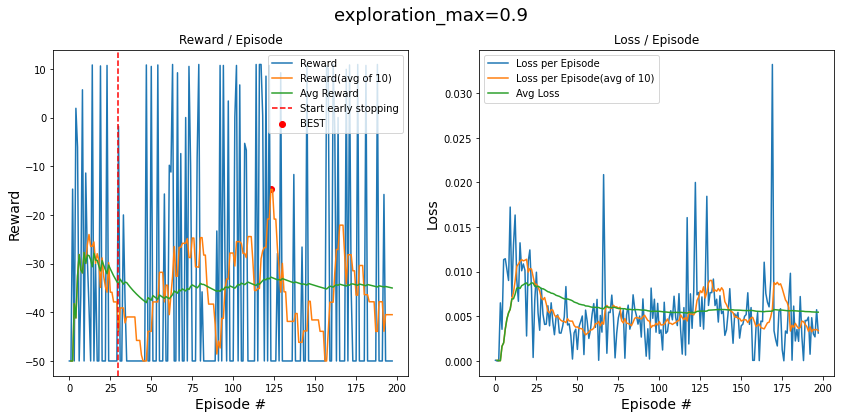

In [ ]:
pt.visualize_plots(e_max_trainers_names)

Average results for exploration_max=0.3 on 100 evaluations:
	Reward=-45.14 | Steps=460.19 | Success Rate=8.00%
Average results for exploration_max=0.5 on 100 evaluations:
	Reward=-42.70 | Steps=440.21 | Success Rate=12.00%
Average results for exploration_max=0.9 on 100 evaluations:
	Reward=-43.92 | Steps=450.23 | Success Rate=10.00%


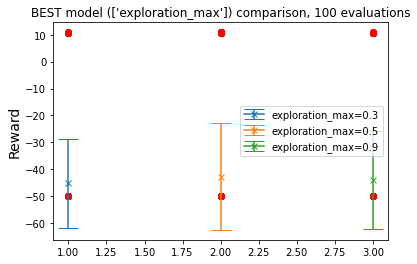

In [ ]:
pt.evaluate_n_episodes(e_max_trainers_names, n_episodes=100)

We can see from the results that when ε-max is less than 0.9, there is no enough exploration at the beggining of the training. Therefore the loss reward convergence plots look not good, and the success rate is low.

### ε - greedy (min)
Minimum exploration rate, after applying the decay factor.

In [ ]:
e_min_trainers_names = pt.tune_param(param_name='exploration_min', param_values=[0.02, 0.3, 0.7])

Tunning 'exploration_min':   0%|          | 0/3 [00:00<?, ?it/s]

Initializing DQNTrainer
Game mode: RANDOM
Config: TrainingCfg(max_memory_size=30000, memory_n_good_samples=10, batch_size=32, gamma=0.3, lr=0.00025, exploration_max=0.9, exploration_min=0.02, exploration_decay=0.99995, copy_weigths_every_steps=1000, early_stopping=True, early_stopping_patience=75, early_stopping_start_on_episode=30, early_stopping_delta=0)
	- max_memory_size := 30000
	- memory_n_good_samples := 10
	- batch_size := 32
	- gamma := 0.3
	- lr := 0.00025
	- exploration_max := 0.9
	- exploration_min := 0.02
	- exploration_decay := 0.99995
	- copy_weigths_every_steps := 1000
	- early_stopping := True
	- early_stopping_patience := 75
	- early_stopping_start_on_episode := 30
	- early_stopping_delta := 0

Initializing DQNTrainer, results will be written to results/4b27e386
Filling replay buffer with samples..........
Replay buffer avg Done states=0.0005000000237487257



  0%|          | 0/250 [00:00<?, ?it/s]


Episode 5:	last_reward=-50.000  |  5_rewards=-50.000  |  avg_rewards=-50.000  |  avg_loss=0.0048795664  |  last_steps=500  |  avg_steps=500.0  |  eps=0.79424

Episode 10:	last_reward=-50.000  |  5_rewards=-38.260  |  avg_rewards=-44.130  |  avg_loss=0.0056171492  |  last_steps=500  |  avg_steps=463.3  |  eps=0.71390

Episode 15:	last_reward=-50.000  |  5_rewards=-34.380  |  avg_rewards=-40.880  |  avg_loss=0.0052521243  |  last_steps=500  |  avg_steps=438.1  |  eps=0.64793

Episode 20:	last_reward=-50.000  |  5_rewards=-21.880  |  avg_rewards=-36.130  |  avg_loss=0.0085950037  |  last_steps=500  |  avg_steps=399.8  |  eps=0.60340

Episode 25:	last_reward=-50.000  |  5_rewards=-50.000  |  avg_rewards=-38.904  |  avg_loss=0.0081337467  |  last_steps=500  |  avg_steps=419.8  |  eps=0.53250

Episode 30:	last_reward=-22.400  |  5_rewards=-28.220  |  avg_rewards=-37.123  |  avg_loss=0.0075905784  |  last_steps=334  |  avg_steps=407.9  |  eps=0.48810

Episode 35:	last_reward=10.800  |  5_rew

  0%|          | 0/250 [00:00<?, ?it/s]


Episode 5:	last_reward=-50.000  |  5_rewards=-23.660  |  avg_rewards=-23.660  |  avg_loss=0.0042308569  |  last_steps=500  |  avg_steps=302.6  |  eps=0.83443

Episode 10:	last_reward=-12.700  |  5_rewards=-6.840  |  avg_rewards=-15.250  |  avg_loss=0.0042802235  |  last_steps=237  |  avg_steps=229.5  |  eps=0.80243

Episode 15:	last_reward=7.600  |  5_rewards=-19.540  |  avg_rewards=-16.680  |  avg_loss=0.0056207376  |  last_steps=34  |  avg_steps=247.5  |  eps=0.74754

Episode 20:	last_reward=-50.000  |  5_rewards=-47.140  |  avg_rewards=-24.295  |  avg_loss=0.0059673381  |  last_steps=500  |  avg_steps=308.9  |  eps=0.66079

Episode 25:	last_reward=10.800  |  5_rewards=-37.840  |  avg_rewards=-27.004  |  avg_loss=0.0060757436  |  last_steps=2  |  avg_steps=327.2  |  eps=0.59785

Episode 30:	last_reward=-35.300  |  5_rewards=-47.060  |  avg_rewards=-30.347  |  avg_loss=0.0061335652  |  last_steps=463  |  avg_steps=354.8  |  eps=0.52857

Episode 35:	last_reward=-50.000  |  5_rewards=-

  0%|          | 0/250 [00:00<?, ?it/s]


Episode 5:	last_reward=-16.500  |  5_rewards=-43.300  |  avg_rewards=-43.300  |  avg_loss=0.0065543549  |  last_steps=275  |  avg_steps=455.0  |  eps=0.80323

Episode 10:	last_reward=-6.400  |  5_rewards=-41.280  |  avg_rewards=-42.290  |  avg_loss=0.0074609257  |  last_steps=174  |  avg_steps=444.9  |  eps=0.72050

Episode 15:	last_reward=8.200  |  5_rewards=-22.240  |  avg_rewards=-35.607  |  avg_loss=0.0084028030  |  last_steps=28  |  avg_steps=392.7  |  eps=0.70000

Episode 20:	last_reward=-7.600  |  5_rewards=-31.340  |  avg_rewards=-34.540  |  avg_loss=0.0086326022  |  last_steps=186  |  avg_steps=383.9  |  eps=0.70000

Episode 25:	last_reward=-50.000  |  5_rewards=-43.760  |  avg_rewards=-36.384  |  avg_loss=0.0085028522  |  last_steps=500  |  avg_steps=399.0  |  eps=0.70000

Episode 30:	last_reward=-27.900  |  5_rewards=-31.000  |  avg_rewards=-35.487  |  avg_loss=0.0084983092  |  last_steps=389  |  avg_steps=395.2  |  eps=0.70000

Episode 35:	last_reward=-50.000  |  5_rewards

/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


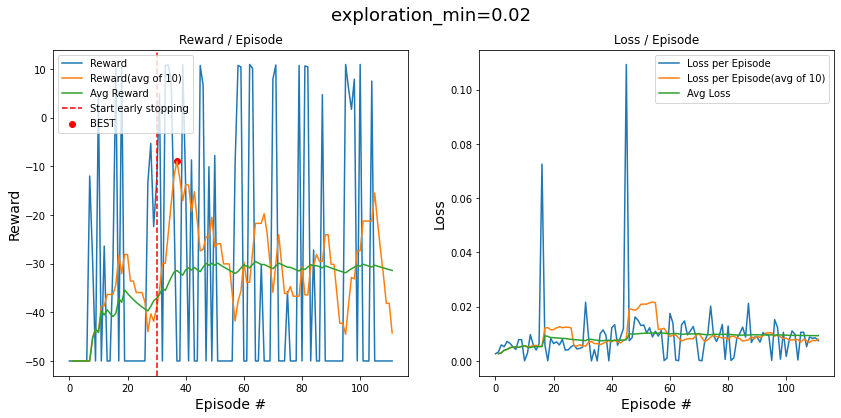

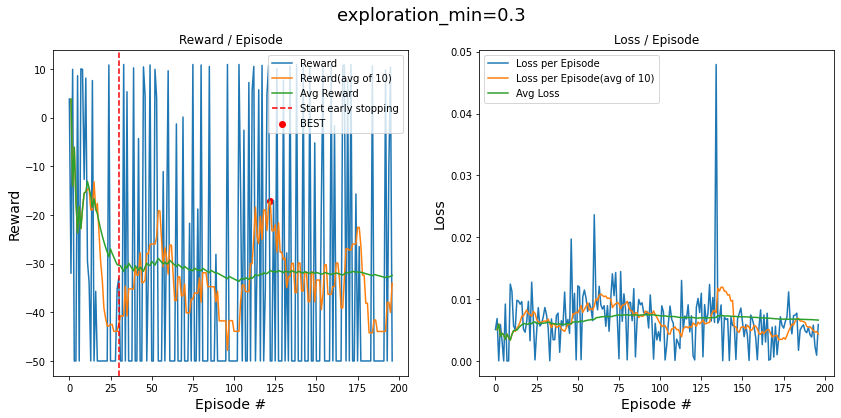

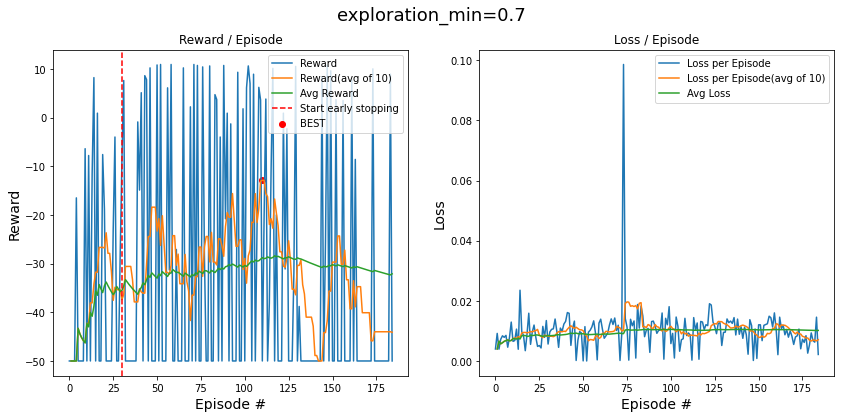

In [ ]:
pt.visualize_plots(e_min_trainers_names)

load predictor:BEST
Average results for exploration_min=0.02 on 100 evaluations:
	Reward=-40.28 | Steps=420.36 | Succession Rate=16.00%
load predictor:BEST
Average results for exploration_min=0.3 on 100 evaluations:
	Reward=-42.70 | Steps=440.22 | Succession Rate=12.00%
load predictor:BEST
Average results for exploration_min=0.7 on 100 evaluations:
	Reward=-41.49 | Steps=430.30 | Succession Rate=14.00%


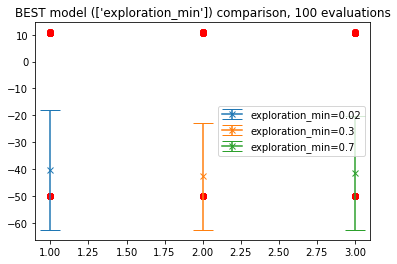

In [ ]:
pt.evaluate_n_episodes(e_min_trainers_names, n_episodes=100)

### ɛ decay factor
Every "experience replay" step we multiply the exploration rate by this value. It is going to be the most important parameter for the experiments.

In [ ]:
e_decay_trainers_names = pt.tune_param(param_name='exploration_decay', param_values=[0.99, 0.9999, 0.99999])

Tunning 'exploration_decay':   0%|          | 0/3 [00:00<?, ?it/s]

Initializing DQNTrainer
Game mode: RANDOM
Config: TrainingCfg(max_memory_size=30000, memory_n_good_samples=10, batch_size=32, gamma=0.3, lr=0.00025, exploration_max=0.9, exploration_min=0.02, exploration_decay=0.99, copy_weigths_every_steps=1000, early_stopping=True, early_stopping_patience=75, early_stopping_start_on_episode=30, early_stopping_delta=0)
	- max_memory_size := 30000
	- memory_n_good_samples := 10
	- batch_size := 32
	- gamma := 0.3
	- lr := 0.00025
	- exploration_max := 0.9
	- exploration_min := 0.02
	- exploration_decay := 0.99
	- copy_weigths_every_steps := 1000
	- early_stopping := True
	- early_stopping_patience := 75
	- early_stopping_start_on_episode := 30
	- early_stopping_delta := 0

Initializing DQNTrainer, results will be written to results/05c36d32
Filling replay buffer with samples.............
Replay buffer avg Done states=0.0008666666690260172



  0%|          | 0/250 [00:00<?, ?it/s]


Episode 5:	last_reward=-50.000  |  5_rewards=-30.700  |  avg_rewards=-30.700  |  avg_loss=0.0089474609  |  last_steps=500  |  avg_steps=351.0  |  eps=0.02000

Episode 10:	last_reward=-50.000  |  5_rewards=-30.220  |  avg_rewards=-30.460  |  avg_loss=0.0077434829  |  last_steps=500  |  avg_steps=348.6  |  eps=0.02000

Episode 15:	last_reward=-50.000  |  5_rewards=-29.840  |  avg_rewards=-30.253  |  avg_loss=0.0082409577  |  last_steps=500  |  avg_steps=346.5  |  eps=0.02000

Episode 20:	last_reward=-50.000  |  5_rewards=-50.000  |  avg_rewards=-35.190  |  avg_loss=0.0085764546  |  last_steps=500  |  avg_steps=384.9  |  eps=0.02000

Episode 25:	last_reward=-50.000  |  5_rewards=-41.000  |  avg_rewards=-36.352  |  avg_loss=0.0084028449  |  last_steps=500  |  avg_steps=394.3  |  eps=0.02000

Episode 30:	last_reward=10.900  |  5_rewards=-21.780  |  avg_rewards=-33.923  |  avg_loss=0.0078101372  |  last_steps=1  |  avg_steps=375.9  |  eps=0.02000

Episode 35:	last_reward=-50.000  |  5_rewar

  0%|          | 0/250 [00:00<?, ?it/s]


Episode 5:	last_reward=-50.000  |  5_rewards=-26.440  |  avg_rewards=-26.440  |  avg_loss=0.0131143536  |  last_steps=500  |  avg_steps=330.4  |  eps=0.76295

Episode 10:	last_reward=8.700  |  5_rewards=-1.240  |  avg_rewards=-13.840  |  avg_loss=0.0142602902  |  last_steps=23  |  avg_steps=226.4  |  eps=0.71765

Episode 15:	last_reward=-7.100  |  5_rewards=-24.240  |  avg_rewards=-17.307  |  avg_loss=0.0154406456  |  last_steps=181  |  avg_steps=253.7  |  eps=0.61509

Episode 20:	last_reward=7.800  |  5_rewards=-11.400  |  avg_rewards=-15.830  |  avg_loss=0.0169724412  |  last_steps=32  |  avg_steps=240.8  |  eps=0.55600

Episode 25:	last_reward=-50.000  |  5_rewards=-44.280  |  avg_rewards=-21.520  |  avg_loss=0.0165297631  |  last_steps=500  |  avg_steps=285.6  |  eps=0.44070

Episode 30:	last_reward=-50.000  |  5_rewards=-28.120  |  avg_rewards=-22.620  |  avg_loss=0.0156927798  |  last_steps=500  |  avg_steps=292.2  |  eps=0.37456

Episode 35:	last_reward=10.900  |  5_rewards=-25

  0%|          | 0/250 [00:00<?, ?it/s]


Episode 5:	last_reward=-50.000  |  5_rewards=-20.460  |  avg_rewards=-20.460  |  avg_loss=0.0111544458  |  last_steps=500  |  avg_steps=270.6  |  eps=0.88790

Episode 10:	last_reward=-50.000  |  5_rewards=-22.720  |  avg_rewards=-21.590  |  avg_loss=0.0128555996  |  last_steps=500  |  avg_steps=281.9  |  eps=0.87498

Episode 15:	last_reward=-32.800  |  5_rewards=-39.000  |  avg_rewards=-27.393  |  avg_loss=0.0131977061  |  last_steps=438  |  avg_steps=332.6  |  eps=0.85620

Episode 20:	last_reward=-50.000  |  5_rewards=-20.820  |  avg_rewards=-25.750  |  avg_loss=0.0119155617  |  last_steps=500  |  avg_steps=318.0  |  eps=0.84454

Episode 25:	last_reward=-50.000  |  5_rewards=-38.240  |  avg_rewards=-28.248  |  avg_loss=0.0118498281  |  last_steps=500  |  avg_steps=335.3  |  eps=0.82764

Episode 30:	last_reward=7.100  |  5_rewards=-26.420  |  avg_rewards=-27.943  |  avg_loss=0.0121704657  |  last_steps=39  |  avg_steps=330.8  |  eps=0.81498

Episode 35:	last_reward=-20.400  |  5_rewar

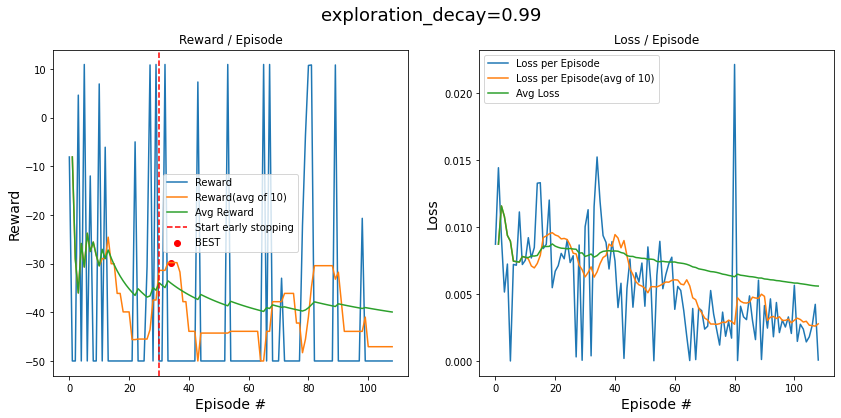

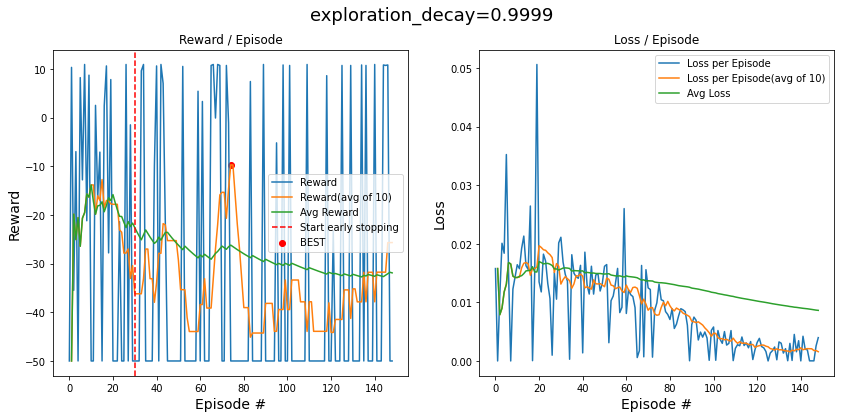

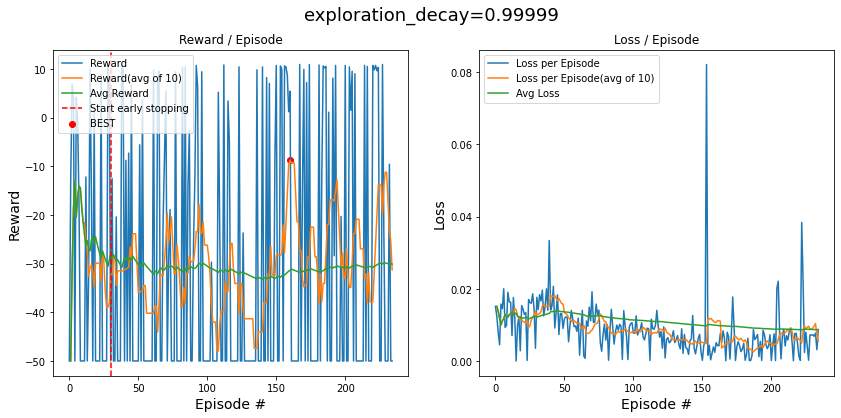

In [ ]:
pt.visualize_plots(e_decay_trainers_names)

load predictor:BEST
Average results for exploration_decay=0.99 on 100 evaluations:
	Reward=-47.56 | Steps=480.04 | Succession Rate=4.00%
load predictor:BEST
Average results for exploration_decay=0.9999 on 100 evaluations:
	Reward=-42.10 | Steps=435.34 | Succession Rate=13.00%
load predictor:BEST
Average results for exploration_decay=0.99999 on 100 evaluations:
	Reward=-43.31 | Steps=445.19 | Succession Rate=11.00%


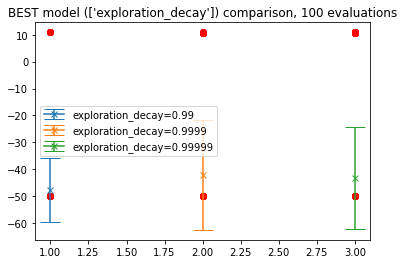

In [ ]:
pt.evaluate_n_episodes(e_decay_trainers_names, n_episodes=100)

0.99 led to short time of exploration, thus we degraded the performance.
On the other hand, 0.99999 kept the algorithm in an exploration mode for more time than it needed.

### Copy weights
from dqn network to target network every n steps

In [ ]:
copy_trainers_names = pt.tune_param(param_name='copy_weigths_every_steps', param_values=[100, 250, 500, 2000, 10000])

Tunning 'copy_weigths_every_steps':   0%|          | 0/5 [00:00<?, ?it/s]

Initializing DQNTrainer
Game mode: RANDOM
Config: TrainingCfg(max_memory_size=30000, memory_n_good_samples=10, batch_size=32, gamma=0.3, lr=0.00025, exploration_max=0.9, exploration_min=0.02, exploration_decay=0.99995, copy_weigths_every_steps=100, early_stopping=True, early_stopping_patience=75, early_stopping_start_on_episode=30, early_stopping_delta=0)
	- max_memory_size := 30000
	- memory_n_good_samples := 10
	- batch_size := 32
	- gamma := 0.3
	- lr := 0.00025
	- exploration_max := 0.9
	- exploration_min := 0.02
	- exploration_decay := 0.99995
	- copy_weigths_every_steps := 100
	- early_stopping := True
	- early_stopping_patience := 75
	- early_stopping_start_on_episode := 30
	- early_stopping_delta := 0

Initializing DQNTrainer, results will be written to results/86203162
Filling replay buffer with samples..................
Replay buffer avg Done states=0.0012000000569969416



  0%|          | 0/250 [00:00<?, ?it/s]


Episode 5:	last_reward=-8.700  |  5_rewards=-37.400  |  avg_rewards=-37.400  |  avg_loss=0.0103757856  |  last_steps=197  |  avg_steps=418.0  |  eps=0.81070

Episode 10:	last_reward=-50.000  |  5_rewards=-34.800  |  avg_rewards=-36.100  |  avg_loss=0.0112295495  |  last_steps=500  |  avg_steps=405.0  |  eps=0.73501

Episode 15:	last_reward=2.100  |  5_rewards=-30.360  |  avg_rewards=-34.187  |  avg_loss=0.0108102709  |  last_steps=89  |  avg_steps=385.9  |  eps=0.67384

Episode 20:	last_reward=-50.000  |  5_rewards=-50.000  |  avg_rewards=-38.140  |  avg_loss=0.0107859969  |  last_steps=500  |  avg_steps=414.4  |  eps=0.59466

Episode 25:	last_reward=-50.000  |  5_rewards=-50.000  |  avg_rewards=-40.512  |  avg_loss=0.0106385089  |  last_steps=500  |  avg_steps=431.5  |  eps=0.52478

Episode 30:	last_reward=-50.000  |  5_rewards=-50.000  |  avg_rewards=-42.093  |  avg_loss=0.0107108420  |  last_steps=500  |  avg_steps=442.9  |  eps=0.46312

Episode 35:	last_reward=-50.000  |  5_reward

  0%|          | 0/250 [00:00<?, ?it/s]


Episode 5:	last_reward=-50.000  |  5_rewards=-21.760  |  avg_rewards=-21.760  |  avg_loss=0.0063625677  |  last_steps=500  |  avg_steps=283.6  |  eps=0.83840

Episode 10:	last_reward=-50.000  |  5_rewards=-16.380  |  avg_rewards=-19.070  |  avg_loss=0.0058287894  |  last_steps=500  |  avg_steps=256.7  |  eps=0.79159

Episode 15:	last_reward=-15.500  |  5_rewards=-32.180  |  avg_rewards=-23.440  |  avg_loss=0.0070711556  |  last_steps=265  |  avg_steps=293.1  |  eps=0.72241

Episode 20:	last_reward=-50.000  |  5_rewards=-27.360  |  avg_rewards=-24.420  |  avg_loss=0.0084497705  |  last_steps=500  |  avg_steps=299.2  |  eps=0.66727

Episode 25:	last_reward=-50.000  |  5_rewards=-50.000  |  avg_rewards=-29.536  |  avg_loss=0.0082556382  |  last_steps=500  |  avg_steps=339.4  |  eps=0.58886

Episode 30:	last_reward=-50.000  |  5_rewards=-50.000  |  avg_rewards=-32.947  |  avg_loss=0.0084892903  |  last_steps=500  |  avg_steps=366.1  |  eps=0.51966

Episode 35:	last_reward=-50.000  |  5_re

  0%|          | 0/250 [00:00<?, ?it/s]


Episode 5:	last_reward=-50.000  |  5_rewards=-35.880  |  avg_rewards=-35.880  |  avg_loss=0.0152646434  |  last_steps=500  |  avg_steps=402.8  |  eps=0.81378

Episode 10:	last_reward=4.100  |  5_rewards=-10.140  |  avg_rewards=-23.010  |  avg_loss=0.0117596714  |  last_steps=69  |  avg_steps=296.1  |  eps=0.77615

Episode 15:	last_reward=9.700  |  5_rewards=-17.100  |  avg_rewards=-21.040  |  avg_loss=0.0144797843  |  last_steps=13  |  avg_steps=276.4  |  eps=0.73149

Episode 20:	last_reward=-50.000  |  5_rewards=-41.180  |  avg_rewards=-26.075  |  avg_loss=0.0149697307  |  last_steps=500  |  avg_steps=315.8  |  eps=0.65631

Episode 25:	last_reward=10.900  |  5_rewards=-28.900  |  avg_rewards=-26.640  |  avg_loss=0.0142215444  |  last_steps=1  |  avg_steps=319.2  |  eps=0.60389

Episode 30:	last_reward=-50.000  |  5_rewards=-38.360  |  avg_rewards=-28.593  |  avg_loss=0.0143443588  |  last_steps=500  |  avg_steps=333.6  |  eps=0.54565

Episode 35:	last_reward=-50.000  |  5_rewards=-37

  0%|          | 0/250 [00:00<?, ?it/s]


Episode 5:	last_reward=-38.800  |  5_rewards=-24.920  |  avg_rewards=-24.920  |  avg_loss=0.0086537078  |  last_steps=498  |  avg_steps=315.2  |  eps=0.83180

Episode 10:	last_reward=-22.900  |  5_rewards=-25.960  |  avg_rewards=-25.440  |  avg_loss=0.0125329699  |  last_steps=339  |  avg_steps=320.4  |  eps=0.76677

Episode 15:	last_reward=-50.000  |  5_rewards=-29.840  |  avg_rewards=-26.907  |  avg_loss=0.0126491096  |  last_steps=500  |  avg_steps=327.7  |  eps=0.70387

Episode 20:	last_reward=-1.000  |  5_rewards=-33.740  |  avg_rewards=-28.615  |  avg_loss=0.0120684970  |  last_steps=120  |  avg_steps=341.1  |  eps=0.63985

Episode 25:	last_reward=7.100  |  5_rewards=-14.920  |  avg_rewards=-25.876  |  avg_loss=0.0145608103  |  last_steps=39  |  avg_steps=316.0  |  eps=0.60634

Episode 30:	last_reward=-31.100  |  5_rewards=-27.700  |  avg_rewards=-26.180  |  avg_loss=0.0139414752  |  last_steps=421  |  avg_steps=320.5  |  eps=0.55651

Episode 35:	last_reward=10.900  |  5_rewards

  0%|          | 0/250 [00:00<?, ?it/s]


Episode 5:	last_reward=-50.000  |  5_rewards=-26.320  |  avg_rewards=-26.320  |  avg_loss=0.0031679566  |  last_steps=500  |  avg_steps=307.2  |  eps=0.83347

Episode 10:	last_reward=-50.000  |  5_rewards=-37.680  |  avg_rewards=-32.000  |  avg_loss=0.0052675940  |  last_steps=500  |  avg_steps=364.0  |  eps=0.75024

Episode 15:	last_reward=4.600  |  5_rewards=-39.080  |  avg_rewards=-34.360  |  avg_loss=0.0050329715  |  last_steps=64  |  avg_steps=380.3  |  eps=0.67667

Episode 20:	last_reward=9.500  |  5_rewards=-22.120  |  avg_rewards=-31.300  |  avg_loss=0.0062923036  |  last_steps=15  |  avg_steps=357.0  |  eps=0.62979

Episode 25:	last_reward=-50.000  |  5_rewards=-27.080  |  avg_rewards=-30.456  |  avg_loss=0.0066118096  |  last_steps=500  |  avg_steps=348.6  |  eps=0.58212

Episode 30:	last_reward=6.200  |  5_rewards=-9.120  |  avg_rewards=-26.900  |  avg_loss=0.0063372594  |  last_steps=48  |  avg_steps=320.3  |  eps=0.55662

Episode 35:	last_reward=8.700  |  5_rewards=-24.22

load predictor:BEST
Average results for copy_weigths_every_steps=100 on 100 evaluations:
	Reward=-46.96 | Steps=475.11 | Succession Rate=5.00%
load predictor:BEST
Average results for copy_weigths_every_steps=500 on 100 evaluations:
	Reward=-40.88 | Steps=425.30 | Succession Rate=15.00%
load predictor:BEST
Average results for copy_weigths_every_steps=2000 on 100 evaluations:
	Reward=-41.49 | Steps=430.27 | Succession Rate=14.00%
load predictor:BEST
Average results for copy_weigths_every_steps=10000 on 100 evaluations:
	Reward=-46.96 | Steps=475.09 | Succession Rate=5.00%


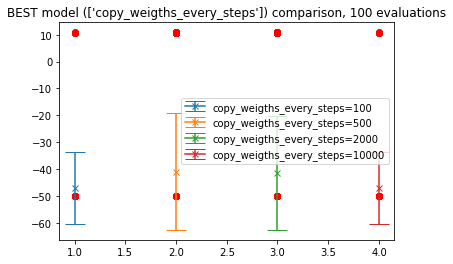

In [ ]:
pt.evaluate_n_episodes(copy_trainers_names, n_episodes=100)

Best value for this parameter according to this experiment is somewhere between 500 to 2000.

## Best Hyper-Parameters and Intermidiate Conclusion
Following to the previous parameters tunning session, we'd like to run an experiment with all the best hyper-parameters:

- `batch_size=32`
- `gamma=0.9`
- `lr=0.00025`
- `exploration_max=0.9`
- `exploration_min=0.02`
- `exploration_decay=0.99995`
- `copy_weigths_every_steps=500`

In [ ]:
cfg = TrainingCfg.get_default_config()

cfg.max_memory_size=10000
cfg.fill_replay_buffer = False
cfg.batch_size=32
cfg.gamma=0.9
cfg.lr=0.00025
cfg.exploration_max=0.9
cfg.exploration_min=0.02
cfg.exploration_decay=0.99995
cfg.copy_weigths_every_steps=500
cfg.early_stopping_patience=200
cfg.early_stopping_start_on_episode=50

trainer_best_comb = DQNTrainer(random_scenario=True, config=cfg)
trainer_best_comb.train_safe(verbose=False, max_episodes=300)

Initializing DQNTrainer
Game mode: RANDOM
Config: TrainingCfg(max_memory_size=10000, fill_replay_buffer=False, memory_n_good_samples=10, batch_size=32, gamma=0.9, lr=0.00025, exploration_max=0.9, exploration_min=0.02, exploration_decay=0.99995, copy_weigths_every_steps=500, early_stopping=True, early_stopping_patience=200, early_stopping_start_on_episode=50, early_stopping_delta=0, reward_shaping=SokobanRewardShaping(no_move_punishment=None, move_no_move_punishment=None, push_without_pushing=None), optimizer='ADAM', loss='l1', nn_arch='DQNNetwork', random_scenario=True, max_episodes=250)
	- max_memory_size := 10000
	- fill_replay_buffer := False
	- memory_n_good_samples := 10
	- batch_size := 32
	- gamma := 0.9
	- lr := 0.00025
	- exploration_max := 0.9
	- exploration_min := 0.02
	- exploration_decay := 0.99995
	- copy_weigths_every_steps := 500
	- early_stopping := True
	- early_stopping_patience := 200
	- early_stopping_start_on_episode := 50
	- early_stopping_delta := 0
	- reward_sh

  0%|          | 0/300 [00:00<?, ?it/s]


Episode 5:	last_reward=-8.600  |  5_rewards=-25.600  |  avg_rewards=-25.600  |  avg_loss=0.0449677525  |  last_steps=196  |  avg_steps=322.0  |  eps=0.83168

Episode 10:	last_reward=10.900  |  5_rewards=-17.720  |  avg_rewards=-21.660  |  avg_loss=0.0463819323  |  last_steps=1  |  avg_steps=282.6  |  eps=0.78262

Episode 15:	last_reward=-50.000  |  5_rewards=-29.480  |  avg_rewards=-24.267  |  avg_loss=0.0448421879  |  last_steps=500  |  avg_steps=301.3  |  eps=0.71906

Episode 20:	last_reward=10.700  |  5_rewards=-25.760  |  avg_rewards=-24.640  |  avg_loss=0.0382991452  |  last_steps=3  |  avg_steps=301.4  |  eps=0.66683

Episode 25:	last_reward=-9.200  |  5_rewards=-29.860  |  avg_rewards=-25.684  |  avg_loss=0.0345628295  |  last_steps=202  |  avg_steps=314.0  |  eps=0.60874

Episode 30:	last_reward=-50.000  |  5_rewards=-40.540  |  avg_rewards=-28.160  |  avg_loss=0.0311168412  |  last_steps=500  |  avg_steps=332.9  |  eps=0.54705

Episode 35:	last_reward=-16.800  |  5_rewards=-3

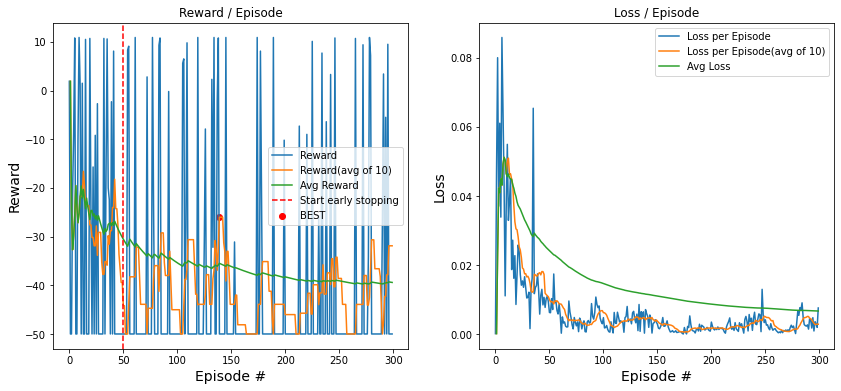

In [ ]:
Visualizer().plot_rewards_loss(trainer_best_comb)

Average results  on 100 evaluations:
	Reward=-46.35 | Steps=470.10 | Succession Rate=6.00%


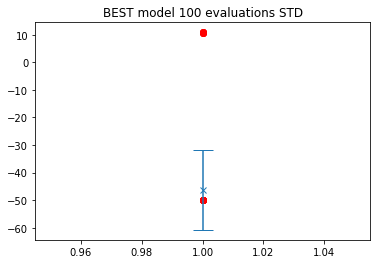

In [ ]:
_ = Evaluator(trainer_best_comb).evaluate(100, plot_chart=True, chart_title="BEST model 100 evaluations STD")

Based on the results of this experiment, **it is clear that there has been a degradation in the performance of the agent**. In order to address this issue, we will need to change our strategy, as we have identified the following problem:

The network output is deterministic, which means that given a particular state, the network will always return the same best action. This becomes a problem if the agent becomes stuck in a particular state, because in a greedy policy, the agent will not be able to escape this state.

To address this issue, we can try implementing **reward shaping**. Reward shaping involves modifying the rewards given to the agent at each time step, in order to punish the agent for doing operations that will cause him to get stuck in a particular state.

See a demonstation of that issue

In [ ]:
path = Evaluator(trainer_best_comb).evaluate_and_render_BEST('ex2_best_comb')

The agent did not solve Sokoban (RANDOM board) after 500 steps, reward=-50.00


In [ ]:
preserve_video(path) ## this operation is used for saving a video for a future loading

In [ ]:
embed_mp4(preserved_video_path('ex2_best_comb'))

## Reward Shaping

#### Punishment: No Movement Operation
A punishment for selecting operation 0

In [ ]:
cfg = TrainingCfg.get_default_config()
cfg.reward_shaping.no_move_punishment = -1.
cfg.early_stopping_patience = 200

trainer_rs = DQNTrainer(random_scenario=True, config=cfg)
trainer_rs.train_safe(verbose=False, max_episodes=300)

Initializing DQNTrainer
Game mode: RANDOM
Config: TrainingCfg(max_memory_size=30000, memory_n_good_samples=10, batch_size=32, gamma=0.3, lr=0.00025, exploration_max=0.9, exploration_min=0.02, exploration_decay=0.99995, copy_weigths_every_steps=1000, early_stopping=True, early_stopping_patience=200, early_stopping_start_on_episode=30, early_stopping_delta=0, reward_shaping=SokobanRewardShaping(no_move_punishment=-1.0, move_no_move_punishment=None, push_without_pushing=None))
	- max_memory_size := 30000
	- memory_n_good_samples := 10
	- batch_size := 32
	- gamma := 0.3
	- lr := 0.00025
	- exploration_max := 0.9
	- exploration_min := 0.02
	- exploration_decay := 0.99995
	- copy_weigths_every_steps := 1000
	- early_stopping := True
	- early_stopping_patience := 200
	- early_stopping_start_on_episode := 30
	- early_stopping_delta := 0
	- reward_shaping := {'no_move_punishment': -1.0, 'move_no_move_punishment': None, 'push_without_pushing': None}

Initializing DQNTrainer, results will be wri

  0%|          | 0/300 [00:00<?, ?it/s]


Episode 5:	last_reward=10.800  |  5_rewards=-30.960  |  avg_rewards=-30.960  |  avg_loss=0.0160687882  |  last_steps=2  |  avg_steps=231.6  |  eps=0.84937

Episode 10:	last_reward=-76.100  |  5_rewards=-51.720  |  avg_rewards=-41.340  |  avg_loss=0.0120043624  |  last_steps=500  |  avg_steps=301.9  |  eps=0.77390

Episode 15:	last_reward=-77.000  |  5_rewards=-64.140  |  avg_rewards=-48.940  |  avg_loss=0.0103959125  |  last_steps=500  |  avg_steps=342.6  |  eps=0.69606

Episode 20:	last_reward=-75.200  |  5_rewards=-59.620  |  avg_rewards=-51.610  |  avg_loss=0.0098312236  |  last_steps=500  |  avg_steps=359.8  |  eps=0.62806

Episode 25:	last_reward=-3.100  |  5_rewards=-44.040  |  avg_rewards=-50.096  |  avg_loss=0.0092777256  |  last_steps=87  |  avg_steps=354.8  |  eps=0.57760

Episode 30:	last_reward=-73.400  |  5_rewards=-50.580  |  avg_rewards=-50.177  |  avg_loss=0.0098901289  |  last_steps=500  |  avg_steps=361.8  |  eps=0.52305

Episode 35:	last_reward=-63.500  |  5_rewards

/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


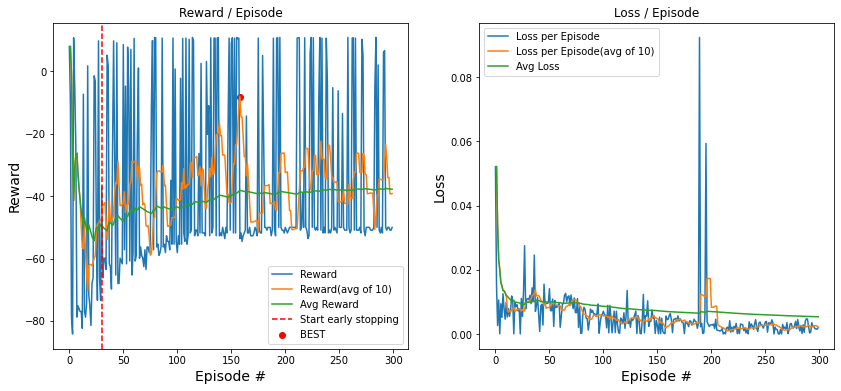

In [ ]:
Visualizer().plot_rewards_loss(trainer_rs)

In [ ]:
path = Evaluator(trainer_rs).evaluate_and_render_BEST('ex2_reward_shaping_op0_p')

/usr/local/lib/python3.9/dist-packages/imageio/plugins/ffmpeg.py:727: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  self._proc.stdin.write(im.tostring())


load predictor:BEST
The agent did not solve Sokoban (RANDOM board) after 500 steps, reward=-50.00


In [ ]:
preserve_video(path) ## this operation is used for saving a video for a future loading

While training we manage to avoid pressing 0 operation, altough the issue of getting stuck has not been addressed yet.

In [ ]:
embed_mp4(preserved_video_path('ex2_reward_shaping_op0_p'))

#### Punishment: Player no movement
Penalize the player whenever it fails to execute a specified action on a given state. The underlying principle of this strategy is to ensure that the agent moves with each step/action to complete the game within the minimum number of steps possible.

This strategy has the potential to address the issue of getting stuck.

In [ ]:
cfg = TrainingCfg.get_default_config()
cfg.reward_shaping.no_move_punishment = -1.
cfg.reward_shaping.move_no_move_punishment = -1.
cfg.early_stopping_patience = 200

trainer_rs = DQNTrainer(random_scenario=True, config=cfg)
trainer_rs.train_safe(verbose=False, max_episodes=300)

Initializing DQNTrainer
Game mode: RANDOM
Config: TrainingCfg(max_memory_size=30000, fill_replay_buffer=True, memory_n_good_samples=10, batch_size=32, gamma=0.3, lr=0.00025, exploration_max=0.9, exploration_min=0.02, exploration_decay=0.99995, copy_weigths_every_steps=1000, early_stopping=True, early_stopping_patience=200, early_stopping_start_on_episode=30, early_stopping_delta=0, reward_shaping=SokobanRewardShaping(no_move_punishment=-1.0, move_no_move_punishment=-1.0, push_without_pushing=None), optimizer='ADAM', loss='l1', nn_arch='DQNNetwork', random_scenario=True, max_episodes=250)
	- max_memory_size := 30000
	- fill_replay_buffer := True
	- memory_n_good_samples := 10
	- batch_size := 32
	- gamma := 0.3
	- lr := 0.00025
	- exploration_max := 0.9
	- exploration_min := 0.02
	- exploration_decay := 0.99995
	- copy_weigths_every_steps := 1000
	- early_stopping := True
	- early_stopping_patience := 200
	- early_stopping_start_on_episode := 30
	- early_stopping_delta := 0
	- reward_sh

  0%|          | 0/300 [00:00<?, ?it/s]


Episode 5:	last_reward=-217.400  |  5_rewards=-172.920  |  avg_rewards=-172.920  |  avg_loss=0.0683474764  |  last_steps=500  |  avg_steps=347.6  |  eps=0.82509

Episode 10:	last_reward=9.400  |  5_rewards=-136.820  |  avg_rewards=-154.870  |  avg_loss=0.0458283350  |  last_steps=7  |  avg_steps=348.0  |  eps=0.75626

Episode 15:	last_reward=1.400  |  5_rewards=-116.700  |  avg_rewards=-142.147  |  avg_loss=0.0355406813  |  last_steps=15  |  avg_steps=341.1  |  eps=0.69686

Episode 20:	last_reward=-197.600  |  5_rewards=-203.000  |  avg_rewards=-157.360  |  avg_loss=0.0301805343  |  last_steps=500  |  avg_steps=380.8  |  eps=0.61498

Episode 25:	last_reward=-3.900  |  5_rewards=-114.940  |  avg_rewards=-148.876  |  avg_loss=0.0268911868  |  last_steps=32  |  avg_steps=385.9  |  eps=0.55556

Episode 30:	last_reward=-85.900  |  5_rewards=-57.620  |  avg_rewards=-133.667  |  avg_loss=0.0242562406  |  last_steps=294  |  avg_steps=359.1  |  eps=0.52517

Episode 35:	last_reward=-163.400  | 

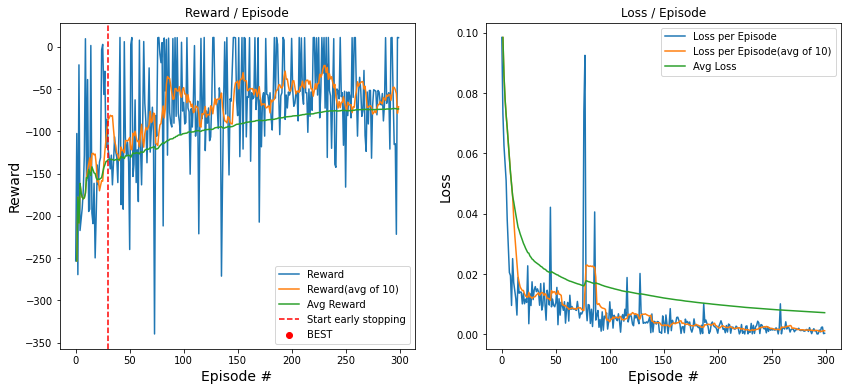

In [ ]:
Visualizer().plot_rewards_loss(trainer_rs)

In [ ]:
path = Evaluator(trainer_rs).evaluate_and_render_BEST('ex2_reward_shaping_move_no_move_p')

The agent did not solve Sokoban (RANDOM board) after 500 steps, reward=-50.00


In [ ]:
preserve_video(path) ## this operation is used for saving a video for a future loading

In [ ]:
embed_mp4(preserved_video_path('ex2_reward_shaping_move_no_move_p'))

It appears that the agent does attempt to avoid staying in one place, although it may still get stuck in the same loop.

#### Punishment: Push/Pull w/o box movement
Only the player moves (i.e. selecting push/pull instead of move).

In [ ]:
cfg = TrainingCfg.get_default_config()
cfg.reward_shaping.no_move_punishment = -1.
cfg.reward_shaping.move_no_move_punishment = -1.
cfg.reward_shaping.push_without_pushing = -1.
cfg.early_stopping_patience = 200

trainer_rs = DQNTrainer(random_scenario=True, config=cfg)
trainer_rs.train_safe(verbose=False, max_episodes=300)

Initializing DQNTrainer
Game mode: RANDOM
Config: TrainingCfg(max_memory_size=30000, fill_replay_buffer=True, memory_n_good_samples=10, batch_size=32, gamma=0.3, lr=0.00025, exploration_max=0.9, exploration_min=0.02, exploration_decay=0.99995, copy_weigths_every_steps=1000, early_stopping=True, early_stopping_patience=200, early_stopping_start_on_episode=30, early_stopping_delta=0, reward_shaping=SokobanRewardShaping(no_move_punishment=-1.0, move_no_move_punishment=-1.0, push_without_pushing=-1.0), optimizer='ADAM', loss='l1', nn_arch='DQNNetwork', random_scenario=True, max_episodes=250)
	- max_memory_size := 30000
	- fill_replay_buffer := True
	- memory_n_good_samples := 10
	- batch_size := 32
	- gamma := 0.3
	- lr := 0.00025
	- exploration_max := 0.9
	- exploration_min := 0.02
	- exploration_decay := 0.99995
	- copy_weigths_every_steps := 1000
	- early_stopping := True
	- early_stopping_patience := 200
	- early_stopping_start_on_episode := 30
	- early_stopping_delta := 0
	- reward_sh

  0%|          | 0/300 [00:00<?, ?it/s]


Episode 5:	last_reward=-372.200  |  5_rewards=-247.920  |  avg_rewards=-247.920  |  avg_loss=0.0697283521  |  last_steps=500  |  avg_steps=325.4  |  eps=0.82968

Episode 10:	last_reward=-7.200  |  5_rewards=-238.140  |  avg_rewards=-243.030  |  avg_loss=0.0529433265  |  last_steps=29  |  avg_steps=323.5  |  eps=0.76559

Episode 15:	last_reward=-295.700  |  5_rewards=-256.760  |  avg_rewards=-247.607  |  avg_loss=0.0474097580  |  last_steps=500  |  avg_steps=353.5  |  eps=0.69041

Episode 20:	last_reward=-292.100  |  5_rewards=-292.780  |  avg_rewards=-258.900  |  avg_loss=0.0427298136  |  last_steps=500  |  avg_steps=387.4  |  eps=0.61093

Episode 25:	last_reward=-258.800  |  5_rewards=-233.880  |  avg_rewards=-253.896  |  avg_loss=0.0390520841  |  last_steps=500  |  avg_steps=400.1  |  eps=0.54579

Episode 30:	last_reward=-233.600  |  5_rewards=-233.820  |  avg_rewards=-250.550  |  avg_loss=0.0356186032  |  last_steps=500  |  avg_steps=416.3  |  eps=0.48199

Episode 35:	last_reward=-

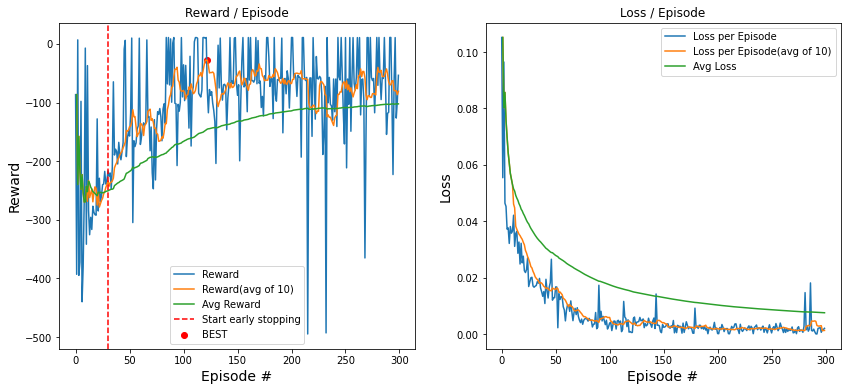

In [ ]:
Visualizer().plot_rewards_loss(trainer_rs)

We have observed **overfitting** when exploration is stopped. To mitigate this, we will set the exploration_min to 0.1.

Average results  on 100 evaluations:
	Reward=-139.04 | Steps=365.61 | Succession Rate=27.00%


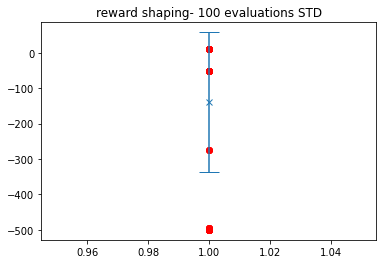

In [ ]:
_ = Evaluator(trainer_rs).evaluate(100, plot_chart=True, chart_title="reward shaping- 100 evaluations STD")

Average results  on 100 evaluations:
	Reward=-107.48 | Steps=400.52 | Succession Rate=20.00%


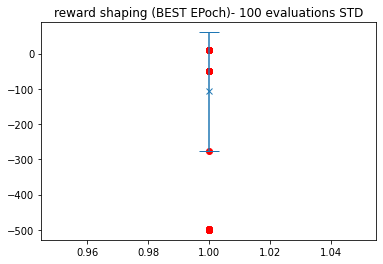

In [ ]:
_ = Evaluator(trainer_rs).evaluate(100, agent_name="BEST", plot_chart=True, chart_title="reward shaping (BEST EPoch)- 100 evaluations STD")

In [ ]:
path = Evaluator(trainer_rs).evaluate_and_render_BEST('ex2_reward_shaping_push_no_push_p')

The agent did not solve Sokoban (RANDOM board) after 500 steps, reward=-50.00


In [ ]:
preserve_video(path)

In [ ]:
embed_mp4(preserved_video_path('ex2_reward_shaping_push_no_push_p'))

Although reward shaping has improved the success rate to some extent, it is still unable to handle loops.

#### Punishment: Distance Box-Target
Give an adaptive punishment with respect to this distance.

In [ ]:
cfg = TrainingCfg.get_default_config()
cfg.reward_shaping.no_move_punishment = -1.
cfg.reward_shaping.move_no_move_punishment = -1.
cfg.reward_shaping.push_without_pushing = -1.
cfg.reward_shaping.distance_box_target = True
cfg.early_stopping_patience = 100
cfg.early_stopping_start_on_episode = 100

trainer_rs_dist = DQNTrainer(random_scenario=True, config=cfg)
trainer_rs_dist.train_safe(verbose=False, max_episodes=300)

Initializing DQNTrainer
Game mode: RANDOM
Config: TrainingCfg(max_memory_size=30000, fill_replay_buffer=True, memory_n_good_samples=10, batch_size=32, gamma=0.3, lr=0.00025, exploration_max=0.9, exploration_min=0.02, exploration_decay=0.99995, copy_weigths_every_steps=1000, early_stopping=True, early_stopping_patience=100, early_stopping_start_on_episode=100, early_stopping_delta=0, reward_shaping=SokobanRewardShaping(no_move_punishment=-1.0, move_no_move_punishment=-1.0, push_without_pushing=-1.0, distance_box_target=True), optimizer='ADAM', loss='l1', nn_arch='DQNNetwork', random_scenario=True, max_episodes=250)
	- max_memory_size := 30000
	- fill_replay_buffer := True
	- memory_n_good_samples := 10
	- batch_size := 32
	- gamma := 0.3
	- lr := 0.00025
	- exploration_max := 0.9
	- exploration_min := 0.02
	- exploration_decay := 0.99995
	- copy_weigths_every_steps := 1000
	- early_stopping := True
	- early_stopping_patience := 100
	- early_stopping_start_on_episode := 100
	- early_stop

  0%|          | 0/300 [00:00<?, ?it/s]


Episode 5:	last_reward=-234.600  |  5_rewards=-546.165  |  avg_rewards=-546.165  |  avg_loss=0.1318507195  |  last_steps=157  |  avg_steps=349.2  |  eps=0.82476

Episode 10:	last_reward=-38.600  |  5_rewards=-577.149  |  avg_rewards=-561.657  |  avg_loss=0.0901870057  |  last_steps=28  |  avg_steps=343.3  |  eps=0.75804

Episode 15:	last_reward=-662.801  |  5_rewards=-675.640  |  avg_rewards=-599.651  |  avg_loss=0.0726903602  |  last_steps=500  |  avg_steps=378.5  |  eps=0.67755

Episode 20:	last_reward=-614.500  |  5_rewards=-530.076  |  avg_rewards=-582.258  |  avg_loss=0.0624587126  |  last_steps=500  |  avg_steps=367.6  |  eps=0.62315

Episode 25:	last_reward=-713.010  |  5_rewards=-765.290  |  avg_rewards=-618.864  |  avg_loss=0.0555613525  |  last_steps=500  |  avg_steps=394.1  |  eps=0.54993

Episode 30:	last_reward=-71.000  |  5_rewards=-536.419  |  avg_rewards=-605.123  |  avg_loss=0.0503588058  |  last_steps=67  |  avg_steps=388.9  |  eps=0.50219

Episode 35:	last_reward=-6

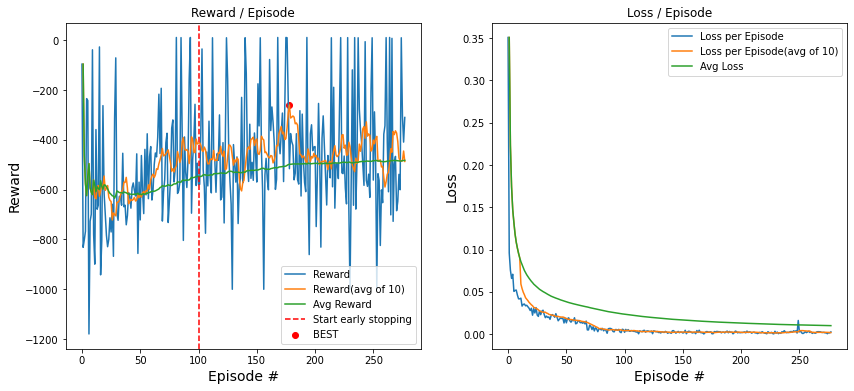

In [ ]:
Visualizer().plot_rewards_loss(trainer_rs_dist)

Average results  on 100 evaluations:
	Reward=-481.26 | Steps=320.77 | Succession Rate=36.00%


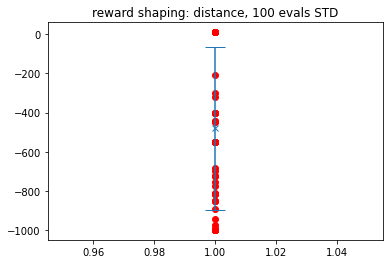

In [ ]:
_ = Evaluator(trainer_rs_dist).evaluate(100, plot_chart=True, chart_title="reward shaping: distance, 100 evals STD")

Average results  on 100 evaluations:
	Reward=-602.98 | Steps=425.31 | Success Rate=15.00%


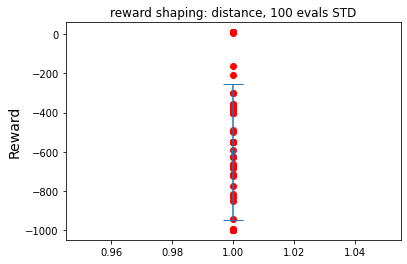

In [ ]:
_ = Evaluator(trainer_rs_dist).evaluate(100, plot_chart=True, chart_title="reward shaping: distance, 100 evals STD")

In [ ]:
path = Evaluator(trainer_rs_dist).evaluate_and_render('ex2_reward_shaping_distance_p')

The agent did not solve Sokoban (RANDOM board) after 500 steps, reward=-910.67


In [ ]:
preserve_video(path)

In [ ]:
embed_mp4(preserved_video_path('ex2_reward_shaping_distance_p'))

Although the success rate has been improved, it is still unable to handle loops. We will address this issue in during the next session.

## ε-greedy Agent
We have observed that reward shaping significantly improves the performance of our agent. However, we have also noticed that our agent still struggles with getting stuck in circles. To address this issue, we would like to incorporate some exploration into our agent's behavior.

Exploration can help it break out of this loop by encouraging it to try new and potentially more effective actions. This can lead to better decision-making and overall improved performance.

Let's load the best model we achieved so far:

In [ ]:
cfg = TrainingCfg.get_default_config()
cfg.reward_shaping.no_move_punishment = -1.
cfg.reward_shaping.move_no_move_punishment = -1.
cfg.reward_shaping.push_without_pushing = -1.
cfg.reward_shaping.distance_box_target = True

trainer_rs_dist_ = DQNTrainer(random_scenario=True, config=cfg, pretrained=r'results/96b7a1c8')

Initializing DQNTrainer
Game mode: RANDOM
Config: TrainingCfg(max_memory_size=30000, fill_replay_buffer=True, memory_n_good_samples=10, batch_size=32, gamma=0.3, lr=0.00025, exploration_max=0.9, exploration_min=0.02, exploration_decay=0.99995, copy_weigths_every_steps=1000, early_stopping=True, early_stopping_patience=75, early_stopping_start_on_episode=30, early_stopping_delta=0, reward_shaping=SokobanRewardShaping(no_move_punishment=-1.0, move_no_move_punishment=-1.0, push_without_pushing=-1.0, distance_box_target=True), optimizer='ADAM', loss='l1', nn_arch='DQNNetwork', random_scenario=True, max_episodes=250)
	- max_memory_size := 30000
	- fill_replay_buffer := True
	- memory_n_good_samples := 10
	- batch_size := 32
	- gamma := 0.3
	- lr := 0.00025
	- exploration_max := 0.9
	- exploration_min := 0.02
	- exploration_decay := 0.99995
	- copy_weigths_every_steps := 1000
	- early_stopping := True
	- early_stopping_patience := 75
	- early_stopping_start_on_episode := 30
	- early_stopping

Running a swipe over the ε-greedy values for the **agent**:

Average results eps-greedy=0.00 on 100 evaluations:
	Reward=-533.16 | Steps=355.77 | Success Rate=29.00%
Average results eps-greedy=0.10 on 100 evaluations:
	Reward=-447.05 | Steps=327.17 | Success Rate=38.00%
Average results eps-greedy=0.20 on 100 evaluations:
	Reward=-492.42 | Steps=383.16 | Success Rate=26.00%
Average results eps-greedy=0.30 on 100 evaluations:
	Reward=-476.43 | Steps=350.12 | Success Rate=32.00%
Average results eps-greedy=0.40 on 100 evaluations:
	Reward=-484.58 | Steps=346.19 | Success Rate=34.00%
Average results eps-greedy=0.50 on 100 evaluations:
	Reward=-421.17 | Steps=304.82 | Success Rate=43.00%
Average results eps-greedy=0.60 on 100 evaluations:
	Reward=-479.84 | Steps=318.02 | Success Rate=43.00%
Average results eps-greedy=0.70 on 100 evaluations:
	Reward=-449.35 | Steps=299.18 | Success Rate=48.00%
Average results eps-greedy=0.80 on 100 evaluations:
	Reward=-464.55 | Steps=298.54 | Success Rate=50.00%
Average results eps-greedy=0.90 on 100 evaluations:
	Re

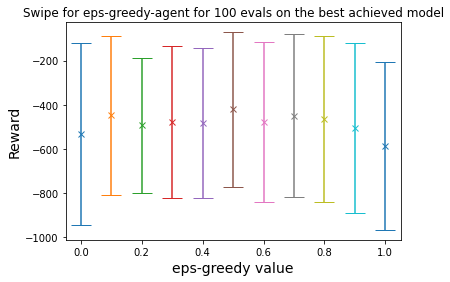

In [ ]:
eps_greedy_vals = np.arange(start=0, stop=1.01, step=0.1, dtype=float)
_ = Evaluator(trainer_rs_dist_).swipe_eps_greedy_agents(
    n_iterations=100,
    chart_title="Swipe for eps-greedy-agent for 100 evals on the best achieved model",
    eps_greedy_vals=eps_greedy_vals
    )

The results indicate that the success rate increases when using the fully-random algorithm (`ɛ=1.0`). However, our goal is to develop an agent that can solve a random board in the minimum number of steps possible. To achieve this, we combined `ɛ=0.9` with the best algorithm we have achieved thus far, resulting in the most promising results with **a success rate of 54%** and **an average of approximately 299 steps**.

## Long-running Experiment
One major issue with all the trained models mentioned above is that they were stopped prematurely due to limited computing resources. We observed that the algorithms did not converge as effectively as in the EX1. To address this, we took the best parameters we had obtained thus far, combined with reward shaping, and trained the algorithm for an extended number of epochs. Since we have more epochs available in this session, we would like to increase the exploration phase by adjusting the corresponding parameters.

#### {**EX2 BEST**} Experiment #1

In [ ]:
cfg = TrainingCfg.get_default_config()
cfg.reward_shaping.no_move_punishment = -1.
cfg.reward_shaping.move_no_move_punishment = -1.
cfg.reward_shaping.push_without_pushing = -1.
cfg.reward_shaping.distance_box_target = True
cfg.early_stopping_patience = 200
cfg.early_stopping_start_on_episode = 200
cfg.exploration_min = 0.1
cfg.exploration_decay=0.99999

trainer_rs_dist_explor = DQNTrainer(random_scenario=True, config=cfg)
trainer_rs_dist_explor.train_safe(verbose=False, max_episodes=1000)

Initializing DQNTrainer
Game mode: RANDOM
Config: TrainingCfg(max_memory_size=30000, fill_replay_buffer=True, memory_n_good_samples=10, batch_size=32, gamma=0.3, lr=0.00025, exploration_max=0.9, exploration_min=0.1, exploration_decay=0.99999, copy_weigths_every_steps=1000, early_stopping=True, early_stopping_patience=200, early_stopping_start_on_episode=200, early_stopping_delta=0, reward_shaping=SokobanRewardShaping(no_move_punishment=-1.0, move_no_move_punishment=-1.0, push_without_pushing=-1.0, distance_box_target=True), optimizer='ADAM', loss='l1', nn_arch='DQNNetwork', random_scenario=True, max_episodes=250)
	- max_memory_size := 30000
	- fill_replay_buffer := True
	- memory_n_good_samples := 10
	- batch_size := 32
	- gamma := 0.3
	- lr := 0.00025
	- exploration_max := 0.9
	- exploration_min := 0.1
	- exploration_decay := 0.99999
	- copy_weigths_every_steps := 1000
	- early_stopping := True
	- early_stopping_patience := 200
	- early_stopping_start_on_episode := 200
	- early_stoppi

  0%|          | 0/1000 [00:00<?, ?it/s]


Episode 5:	last_reward=-839.878  |  5_rewards=-427.680  |  avg_rewards=-427.680  |  avg_loss=0.1877022982  |  last_steps=500  |  avg_steps=260.4  |  eps=0.88836

Episode 10:	last_reward=-124.384  |  5_rewards=-604.085  |  avg_rewards=-515.883  |  avg_loss=0.1197439283  |  last_steps=103  |  avg_steps=301.7  |  eps=0.87325

Episode 15:	last_reward=-925.486  |  5_rewards=-585.237  |  avg_rewards=-539.001  |  avg_loss=0.0989161879  |  last_steps=500  |  avg_steps=311.6  |  eps=0.85890

Episode 20:	last_reward=-792.900  |  5_rewards=-738.722  |  avg_rewards=-588.931  |  avg_loss=0.0851325840  |  last_steps=500  |  avg_steps=352.9  |  eps=0.83868

Episode 25:	last_reward=-946.000  |  5_rewards=-803.953  |  avg_rewards=-631.935  |  avg_loss=0.0748758018  |  last_steps=407  |  avg_steps=378.6  |  eps=0.81873

Episode 30:	last_reward=-772.837  |  5_rewards=-626.311  |  avg_rewards=-630.998  |  avg_loss=0.0683408678  |  last_steps=500  |  avg_steps=379.7  |  eps=0.80310

Episode 35:	last_rewar

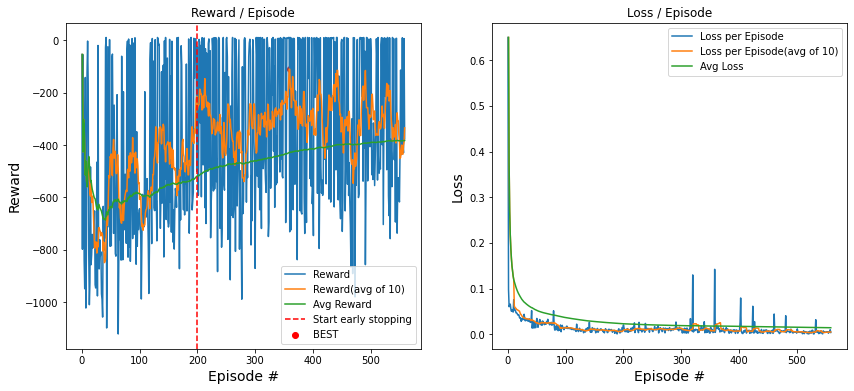

In [ ]:
Visualizer().plot_rewards_loss(trainer_rs_dist_explor)

Let's observe how the model trained up-to the final epoch performs with different values of epsilon-greediness:

Average results eps-greedy=0.00 on 100 evaluations:
	Reward=-426.46 | Steps=330.81 | Success Rate=34.00%
Average results eps-greedy=0.10 on 100 evaluations:
	Reward=-384.40 | Steps=303.12 | Success Rate=40.00%
Average results eps-greedy=0.20 on 100 evaluations:
	Reward=-326.60 | Steps=292.48 | Success Rate=43.00%
Average results eps-greedy=0.30 on 100 evaluations:
	Reward=-397.60 | Steps=292.86 | Success Rate=46.00%
Average results eps-greedy=0.40 on 100 evaluations:
	Reward=-404.73 | Steps=317.28 | Success Rate=40.00%
Average results eps-greedy=0.50 on 100 evaluations:
	Reward=-315.81 | Steps=246.22 | Success Rate=56.00%
Average results eps-greedy=0.60 on 100 evaluations:
	Reward=-422.16 | Steps=304.44 | Success Rate=46.00%
Average results eps-greedy=0.70 on 100 evaluations:
	Reward=-464.78 | Steps=319.00 | Success Rate=42.00%
Average results eps-greedy=0.80 on 100 evaluations:
	Reward=-472.02 | Steps=297.79 | Success Rate=51.00%
Average results eps-greedy=0.90 on 100 evaluations:
	Re

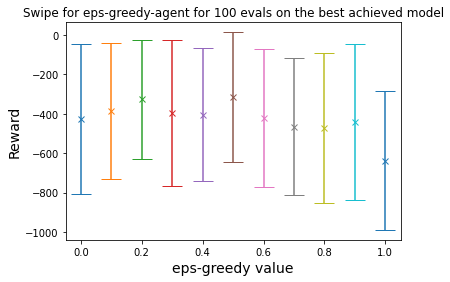

In [ ]:
eps_greedy_vals = np.arange(start=0, stop=1.01, step=0.1, dtype=float)
_ = Evaluator(trainer_rs_dist_explor).swipe_eps_greedy_agents(
    n_iterations=100,
    chart_title="Swipe for eps-greedy-agent for 100 evals on the best achieved model",
    eps_greedy_vals=eps_greedy_vals
    )

The model from the end of the training, together with 0.5-greedy led into the best results of:
***Success Rate of 56%, with 246 avg steps for solving 100 random boards***.
We'd like to observe the performance of the model taken from the best 10 epochs during the training

Average results eps-greedy=0.00 on 100 evaluations:
	Reward=-424.13 | Steps=306.02 | Success Rate=39.00%
Average results eps-greedy=0.10 on 100 evaluations:
	Reward=-397.60 | Steps=325.22 | Success Rate=37.00%
Average results eps-greedy=0.20 on 100 evaluations:
	Reward=-318.71 | Steps=289.76 | Success Rate=45.00%
Average results eps-greedy=0.30 on 100 evaluations:
	Reward=-344.75 | Steps=302.86 | Success Rate=42.00%
Average results eps-greedy=0.40 on 100 evaluations:
	Reward=-372.36 | Steps=291.39 | Success Rate=44.00%
Average results eps-greedy=0.50 on 100 evaluations:
	Reward=-350.48 | Steps=262.30 | Success Rate=52.00%
Average results eps-greedy=0.60 on 100 evaluations:
	Reward=-412.38 | Steps=293.68 | Success Rate=46.00%
Average results eps-greedy=0.70 on 100 evaluations:
	Reward=-422.79 | Steps=272.76 | Success Rate=52.00%
Average results eps-greedy=0.80 on 100 evaluations:
	Reward=-448.70 | Steps=275.54 | Success Rate=56.00%
Average results eps-greedy=0.90 on 100 evaluations:
	Re

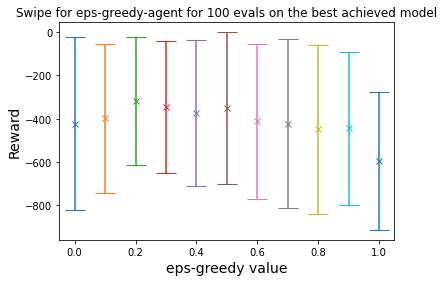

In [ ]:
eps_greedy_vals = np.arange(start=0, stop=1.01, step=0.1, dtype=float)
_ = Evaluator(trainer_rs_dist_explor).swipe_eps_greedy_agents(
    agent_name="BEST",
    n_iterations=100,
    chart_title="Swipe for eps-greedy-agent for 100 evals on the best achieved model",
    eps_greedy_vals=eps_greedy_vals
    )

So far, the best epoch model, together with 0.5-greedy led into the best results of:
Success Rate of 52%, with 260 avg steps for solving 100 random boards.

##### Agent Videos

Agent at the end of training

In [ ]:
path = Evaluator(trainer_rs_dist_explor).evaluate_and_render(
    'ex2_dqn_agent_long_running_exp_BEST', agent_name="BEST", eps_greedy=0.5)

The agent solved Sokoban (RANDOM board) after 67 steps, reward=-110.57


In [ ]:
preserve_video(path)

In [ ]:
embed_mp4(preserved_video_path('ex2_dqn_agent_long_running_exp_BEST'))

Agent at the middle of training after (50% of epochs)

In [ ]:
path = Evaluator(trainer_rs_dist_explor).evaluate_and_render(
    'ex2_dqn_agent_long_running_exp_MID', agent_name="MID", eps_greedy=0.5)

load predictor:MID
The agent solved Sokoban (RANDOM board) after 143 steps, reward=-179.81


In [ ]:
preserve_video(path)

In [ ]:
embed_mp4(preserved_video_path('ex2_dqn_agent_long_running_exp_MID'))

#### Experiment #2
Same expiremnt with `γ=0.9`

In [ ]:
cfg = TrainingCfg.get_default_config()
cfg.reward_shaping.no_move_punishment = -1.
cfg.reward_shaping.move_no_move_punishment = -1.
cfg.reward_shaping.push_without_pushing = -1.
cfg.reward_shaping.distance_box_target = True
cfg.early_stopping_patience = 200
cfg.early_stopping_start_on_episode = 200
cfg.exploration_min = 0.1
cfg.exploration_decay=0.99999
cfg.gamma=0.9

trainer_rs_dist_explor_gamma = DQNTrainer(random_scenario=True, config=cfg)
trainer_rs_dist_explor_gamma.train_safe(verbose=False, max_episodes=1000)

Initializing DQNTrainer
Game mode: RANDOM
Config: TrainingCfg(max_memory_size=30000, fill_replay_buffer=True, memory_n_good_samples=10, batch_size=32, gamma=0.9, lr=0.00025, exploration_max=0.9, exploration_min=0.1, exploration_decay=0.99999, copy_weigths_every_steps=1000, early_stopping=True, early_stopping_patience=200, early_stopping_start_on_episode=200, early_stopping_delta=0, reward_shaping=SokobanRewardShaping(no_move_punishment=-1.0, move_no_move_punishment=-1.0, push_without_pushing=-1.0, distance_box_target=True), optimizer='ADAM', loss='l1', nn_arch='DQNNetwork', random_scenario=True, max_episodes=250)
	- max_memory_size := 30000
	- fill_replay_buffer := True
	- memory_n_good_samples := 10
	- batch_size := 32
	- gamma := 0.9
	- lr := 0.00025
	- exploration_max := 0.9
	- exploration_min := 0.1
	- exploration_decay := 0.99999
	- copy_weigths_every_steps := 1000
	- early_stopping := True
	- early_stopping_patience := 200
	- early_stopping_start_on_episode := 200
	- early_stoppi

  0%|          | 0/1000 [00:00<?, ?it/s]


Episode 5:	last_reward=-708.094  |  5_rewards=-772.350  |  avg_rewards=-772.350  |  avg_loss=0.0637725815  |  last_steps=500  |  avg_steps=483.2  |  eps=0.87852

Episode 10:	last_reward=-703.224  |  5_rewards=-508.559  |  avg_rewards=-640.454  |  avg_loss=0.0549695268  |  last_steps=500  |  avg_steps=409.0  |  eps=0.86393

Episode 15:	last_reward=-822.797  |  5_rewards=-652.698  |  avg_rewards=-644.536  |  avg_loss=0.0529511422  |  last_steps=500  |  avg_steps=398.3  |  eps=0.84780

Episode 20:	last_reward=-971.291  |  5_rewards=-678.337  |  avg_rewards=-652.986  |  avg_loss=0.0532621257  |  last_steps=500  |  avg_steps=397.6  |  eps=0.83120

Episode 25:	last_reward=-877.200  |  5_rewards=-615.655  |  avg_rewards=-645.520  |  avg_loss=0.0549720898  |  last_steps=500  |  avg_steps=389.1  |  eps=0.81657

Episode 30:	last_reward=-898.114  |  5_rewards=-655.823  |  avg_rewards=-647.237  |  avg_loss=0.0575027354  |  last_steps=500  |  avg_steps=386.8  |  eps=0.80140

Episode 35:	last_rewar

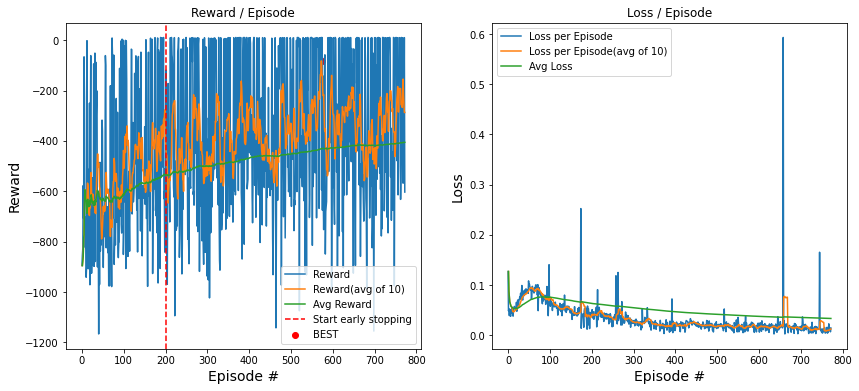

In [ ]:
Visualizer().plot_rewards_loss(trainer_rs_dist_explor_gamma)

Average results eps-greedy=0.00 on 100 evaluations:
	Reward=-560.74 | Steps=365.63 | Success Rate=27.00%
Average results eps-greedy=0.10 on 100 evaluations:
	Reward=-407.94 | Steps=322.56 | Success Rate=37.00%
Average results eps-greedy=0.20 on 100 evaluations:
	Reward=-407.45 | Steps=315.97 | Success Rate=39.00%
Average results eps-greedy=0.30 on 100 evaluations:
	Reward=-416.76 | Steps=306.73 | Success Rate=43.00%
Average results eps-greedy=0.40 on 100 evaluations:
	Reward=-394.90 | Steps=284.36 | Success Rate=48.00%
Average results eps-greedy=0.50 on 100 evaluations:
	Reward=-453.50 | Steps=312.49 | Success Rate=42.00%
Average results eps-greedy=0.60 on 100 evaluations:
	Reward=-488.95 | Steps=327.63 | Success Rate=39.00%
Average results eps-greedy=0.70 on 100 evaluations:
	Reward=-467.35 | Steps=310.31 | Success Rate=46.00%
Average results eps-greedy=0.80 on 100 evaluations:
	Reward=-482.22 | Steps=305.21 | Success Rate=47.00%
Average results eps-greedy=0.90 on 100 evaluations:
	Re

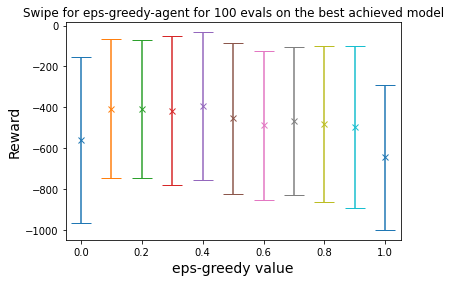

In [ ]:
eps_greedy_vals = np.arange(start=0, stop=1.01, step=0.1, dtype=float)
_ = Evaluator(trainer_rs_dist_explor_gamma).swipe_eps_greedy_agents(
    n_iterations=100,
    chart_title="Swipe for eps-greedy-agent for 100 evals on the best achieved model",
    eps_greedy_vals=eps_greedy_vals
    )

Average results eps-greedy=0.00 on 100 evaluations:
	Reward=-499.64 | Steps=330.92 | Success Rate=34.00%
Average results eps-greedy=0.10 on 100 evaluations:
	Reward=-341.69 | Steps=282.74 | Success Rate=46.00%
Average results eps-greedy=0.20 on 100 evaluations:
	Reward=-343.52 | Steps=264.90 | Success Rate=50.00%
Average results eps-greedy=0.30 on 100 evaluations:
	Reward=-405.60 | Steps=309.01 | Success Rate=42.00%
Average results eps-greedy=0.40 on 100 evaluations:
	Reward=-373.81 | Steps=272.96 | Success Rate=49.00%
Average results eps-greedy=0.50 on 100 evaluations:
	Reward=-415.22 | Steps=289.85 | Success Rate=46.00%
Average results eps-greedy=0.60 on 100 evaluations:
	Reward=-434.97 | Steps=293.48 | Success Rate=47.00%
Average results eps-greedy=0.70 on 100 evaluations:
	Reward=-454.79 | Steps=293.95 | Success Rate=52.00%
Average results eps-greedy=0.80 on 100 evaluations:
	Reward=-443.23 | Steps=281.39 | Success Rate=51.00%
Average results eps-greedy=0.90 on 100 evaluations:
	Re

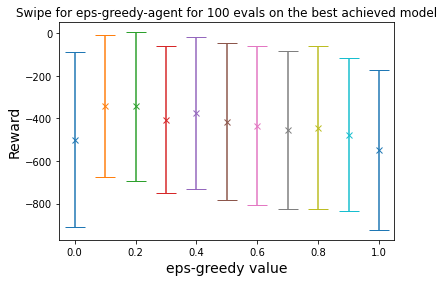

In [ ]:
eps_greedy_vals = np.arange(start=0, stop=1.01, step=0.1, dtype=float)
_ = Evaluator(trainer_rs_dist_explor_gamma).swipe_eps_greedy_agents(
    agent_name="BEST",
    n_iterations=100,
    chart_title="Swipe for eps-greedy-agent for 100 evals on the best achieved model",
    eps_greedy_vals=eps_greedy_vals
    )

## Architecture
We're trying a few more architecture twicks for squeezing a few more reward point.

### Loss
Trying the effect of MSE loss on the training.

In [ ]:
cfg = TrainingCfg.get_default_config()
cfg.reward_shaping.no_move_punishment = -1.
cfg.reward_shaping.move_no_move_punishment = -1.
cfg.reward_shaping.push_without_pushing = -1.
cfg.reward_shaping.distance_box_target = True
cfg.early_stopping_patience = 100
cfg.early_stopping_start_on_episode = 100
cfg.loss = 'l2'

trainer_l2 = DQNTrainer(random_scenario=True, config=cfg)
trainer_l2.train_safe(verbose=False, max_episodes=300)

Initializing DQNTrainer
Game mode: RANDOM
Config: TrainingCfg(max_memory_size=30000, fill_replay_buffer=True, memory_n_good_samples=10, batch_size=32, gamma=0.3, lr=0.00025, exploration_max=0.9, exploration_min=0.02, exploration_decay=0.99995, copy_weigths_every_steps=1000, early_stopping=True, early_stopping_patience=100, early_stopping_start_on_episode=100, early_stopping_delta=0, reward_shaping=SokobanRewardShaping(no_move_punishment=-1.0, move_no_move_punishment=-1.0, push_without_pushing=-1.0, distance_box_target=True), optimizer='ADAM', loss='l2', nn_arch='DQNNetwork', random_scenario=True, max_episodes=250)
	- max_memory_size := 30000
	- fill_replay_buffer := True
	- memory_n_good_samples := 10
	- batch_size := 32
	- gamma := 0.3
	- lr := 0.00025
	- exploration_max := 0.9
	- exploration_min := 0.02
	- exploration_decay := 0.99995
	- copy_weigths_every_steps := 1000
	- early_stopping := True
	- early_stopping_patience := 100
	- early_stopping_start_on_episode := 100
	- early_stop

  0%|          | 0/300 [00:00<?, ?it/s]


Episode 5:	last_reward=-681.231  |  5_rewards=-781.065  |  avg_rewards=-781.065  |  avg_loss=0.2583965957  |  last_steps=500  |  avg_steps=424.6  |  eps=0.80936

Episode 10:	last_reward=-730.300  |  5_rewards=-531.736  |  avg_rewards=-656.400  |  avg_loss=0.2278847247  |  last_steps=321  |  avg_steps=370.1  |  eps=0.74795

Episode 15:	last_reward=-1019.000  |  5_rewards=-564.183  |  avg_rewards=-625.661  |  avg_loss=0.2082458287  |  last_steps=500  |  avg_steps=359.4  |  eps=0.68735

Episode 20:	last_reward=-692.700  |  5_rewards=-787.622  |  avg_rewards=-666.151  |  avg_loss=0.2049036324  |  last_steps=500  |  avg_steps=394.6  |  eps=0.60658

Episode 25:	last_reward=-910.900  |  5_rewards=-707.376  |  avg_rewards=-674.396  |  avg_loss=0.1952496171  |  last_steps=500  |  avg_steps=405.1  |  eps=0.54239

Episode 30:	last_reward=-556.767  |  5_rewards=-589.826  |  avg_rewards=-660.301  |  avg_loss=0.1826473624  |  last_steps=500  |  avg_steps=420.9  |  eps=0.47865

Episode 35:	last_rewa

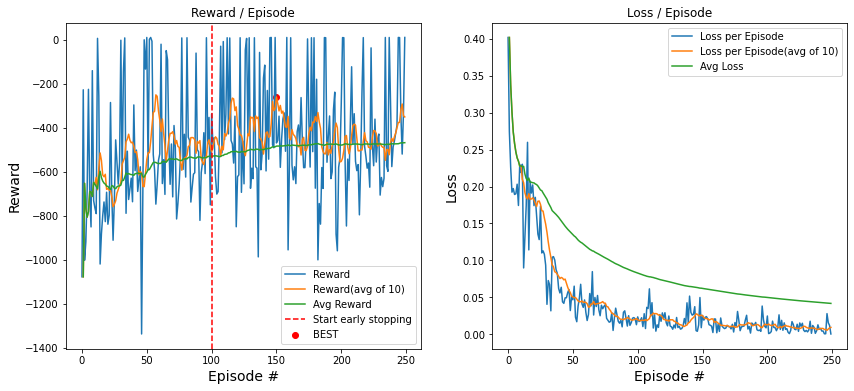

In [ ]:
Visualizer().plot_rewards_loss(trainer_l2)

Average results eps-greedy=0.00 on 100 evaluations:
	Reward=-590.88 | Steps=360.56 | Success Rate=28.00%
Average results eps-greedy=0.10 on 100 evaluations:
	Reward=-476.28 | Steps=348.98 | Success Rate=37.00%
Average results eps-greedy=0.20 on 100 evaluations:
	Reward=-448.52 | Steps=322.36 | Success Rate=41.00%
Average results eps-greedy=0.30 on 100 evaluations:
	Reward=-428.38 | Steps=308.13 | Success Rate=43.00%
Average results eps-greedy=0.40 on 100 evaluations:
	Reward=-501.40 | Steps=336.09 | Success Rate=38.00%
Average results eps-greedy=0.50 on 100 evaluations:
	Reward=-538.78 | Steps=342.52 | Success Rate=36.00%
Average results eps-greedy=0.60 on 100 evaluations:
	Reward=-500.74 | Steps=318.83 | Success Rate=43.00%
Average results eps-greedy=0.70 on 100 evaluations:
	Reward=-526.91 | Steps=345.69 | Success Rate=40.00%
Average results eps-greedy=0.80 on 100 evaluations:
	Reward=-479.27 | Steps=306.90 | Success Rate=47.00%
Average results eps-greedy=0.90 on 100 evaluations:
	Re

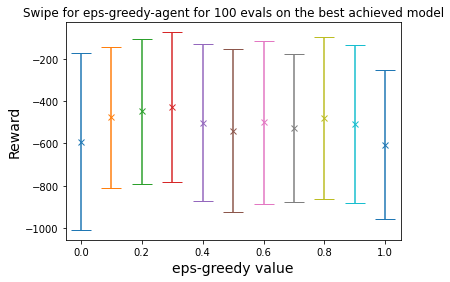

In [ ]:
eps_greedy_vals = np.arange(start=0, stop=1.01, step=0.1, dtype=float)
_ = Evaluator(trainer_l2).swipe_eps_greedy_agents(
    agent_name="BEST",
    n_iterations=100,
    chart_title="Swipe for eps-greedy-agent for 100 evals on the best achieved model",
    eps_greedy_vals=eps_greedy_vals
    )

Nothing special here.

### Optimizer

In [ ]:
cfg = TrainingCfg.get_default_config()
cfg.reward_shaping.no_move_punishment = -1.
cfg.reward_shaping.move_no_move_punishment = -1.
cfg.reward_shaping.push_without_pushing = -1.
cfg.reward_shaping.distance_box_target = True
cfg.early_stopping_patience = 100
cfg.early_stopping_start_on_episode = 100
cfg.optimizer = 'SGD'

trainer_sgd = DQNTrainer(random_scenario=True, config=cfg)
trainer_sgd.train_safe(verbose=False, max_episodes=300)

Initializing DQNTrainer
Game mode: RANDOM
Config: TrainingCfg(max_memory_size=30000, fill_replay_buffer=True, memory_n_good_samples=10, batch_size=32, gamma=0.3, lr=0.00025, exploration_max=0.9, exploration_min=0.02, exploration_decay=0.99995, copy_weigths_every_steps=1000, early_stopping=True, early_stopping_patience=100, early_stopping_start_on_episode=100, early_stopping_delta=0, reward_shaping=SokobanRewardShaping(no_move_punishment=-1.0, move_no_move_punishment=-1.0, push_without_pushing=-1.0, distance_box_target=True), optimizer='SGD', loss='l1', nn_arch='DQNNetwork', random_scenario=True, max_episodes=250)
	- max_memory_size := 30000
	- fill_replay_buffer := True
	- memory_n_good_samples := 10
	- batch_size := 32
	- gamma := 0.3
	- lr := 0.00025
	- exploration_max := 0.9
	- exploration_min := 0.02
	- exploration_decay := 0.99995
	- copy_weigths_every_steps := 1000
	- early_stopping := True
	- early_stopping_patience := 100
	- early_stopping_start_on_episode := 100
	- early_stopp

  0%|          | 0/300 [00:00<?, ?it/s]


Episode 5:	last_reward=-50.362  |  5_rewards=-241.192  |  avg_rewards=-241.192  |  avg_loss=1.2564761639  |  last_steps=40  |  avg_steps=147.0  |  eps=0.86752

Episode 10:	last_reward=-684.569  |  5_rewards=-712.369  |  avg_rewards=-476.781  |  avg_loss=1.2444708347  |  last_steps=291  |  avg_steps=260.2  |  eps=0.79020

Episode 15:	last_reward=-930.834  |  5_rewards=-662.934  |  avg_rewards=-538.832  |  avg_loss=1.2181874514  |  last_steps=500  |  avg_steps=310.9  |  eps=0.71283

Episode 20:	last_reward=-702.259  |  5_rewards=-794.168  |  avg_rewards=-602.666  |  avg_loss=1.1214349270  |  last_steps=500  |  avg_steps=342.4  |  eps=0.63902

Episode 25:	last_reward=-768.767  |  5_rewards=-653.919  |  avg_rewards=-612.916  |  avg_loss=0.9307918549  |  last_steps=500  |  avg_steps=358.1  |  eps=0.57521

Episode 30:	last_reward=-804.511  |  5_rewards=-606.165  |  avg_rewards=-611.791  |  avg_loss=0.8041676879  |  last_steps=500  |  avg_steps=360.4  |  eps=0.52418

Episode 35:	last_reward=

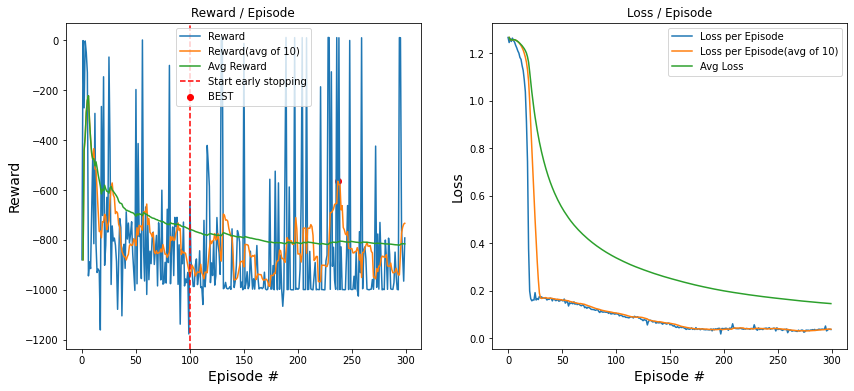

In [ ]:
Visualizer().plot_rewards_loss(trainer_sgd)

There's no convergens for SGD optimizer

### DQNNetwork2

In [ ]:
cfg = TrainingCfg.get_default_config()
cfg.reward_shaping.no_move_punishment = -1.
cfg.reward_shaping.move_no_move_punishment = -1.
cfg.reward_shaping.push_without_pushing = -1.
cfg.reward_shaping.distance_box_target = True
cfg.early_stopping_patience = 200
cfg.early_stopping_start_on_episode = 600
cfg.exploration_min = 0.1
cfg.exploration_decay=0.99999
cfg.batch_size=256
cfg.nn_arch = "DQNNetwork2"

trainer_dqn2 = DQNTrainer(random_scenario=True, config=cfg)
trainer_dqn2.train_safe(verbose=False, max_episodes=1000)

Initializing DQNTrainer
Game mode: RANDOM
Config: TrainingCfg(max_memory_size=30000, fill_replay_buffer=True, memory_n_good_samples=10, batch_size=256, gamma=0.3, lr=0.00025, exploration_max=0.9, exploration_min=0.1, exploration_decay=0.99999, copy_weigths_every_steps=1000, early_stopping=True, early_stopping_patience=200, early_stopping_start_on_episode=600, early_stopping_delta=0, reward_shaping=SokobanRewardShaping(no_move_punishment=-1.0, move_no_move_punishment=-1.0, push_without_pushing=-1.0, distance_box_target=True), optimizer='ADAM', loss='l1', nn_arch='DQNNetwork2', random_scenario=True, max_episodes=250, seed=None)
	- max_memory_size := 30000
	- fill_replay_buffer := True
	- memory_n_good_samples := 10
	- batch_size := 256
	- gamma := 0.3
	- lr := 0.00025
	- exploration_max := 0.9
	- exploration_min := 0.1
	- exploration_decay := 0.99999
	- copy_weigths_every_steps := 1000
	- early_stopping := True
	- early_stopping_patience := 200
	- early_stopping_start_on_episode := 600
	

  0%|          | 0/1000 [00:00<?, ?it/s]


Episode 5:	last_reward=-883.278  |  5_rewards=-805.129  |  avg_rewards=-805.129  |  avg_loss=0.0815662295  |  last_steps=500  |  avg_steps=495.0  |  eps=0.87800

Episode 10:	last_reward=-775.459  |  5_rewards=-691.811  |  avg_rewards=-748.470  |  avg_loss=0.0641865879  |  last_steps=500  |  avg_steps=461.4  |  eps=0.85942

Episode 15:	last_reward=-605.398  |  5_rewards=-644.059  |  avg_rewards=-713.666  |  avg_loss=0.0555028282  |  last_steps=500  |  avg_steps=447.3  |  eps=0.84160

Episode 20:	last_reward=-715.733  |  5_rewards=-634.564  |  avg_rewards=-693.891  |  avg_loss=0.0502196662  |  last_steps=500  |  avg_steps=429.6  |  eps=0.82590

Episode 25:	last_reward=-875.093  |  5_rewards=-704.552  |  avg_rewards=-696.023  |  avg_loss=0.0459264554  |  last_steps=500  |  avg_steps=432.8  |  eps=0.80771

Episode 30:	last_reward=-889.953  |  5_rewards=-659.739  |  avg_rewards=-689.976  |  avg_loss=0.0423336886  |  last_steps=500  |  avg_steps=429.0  |  eps=0.79131

Episode 35:	last_rewar

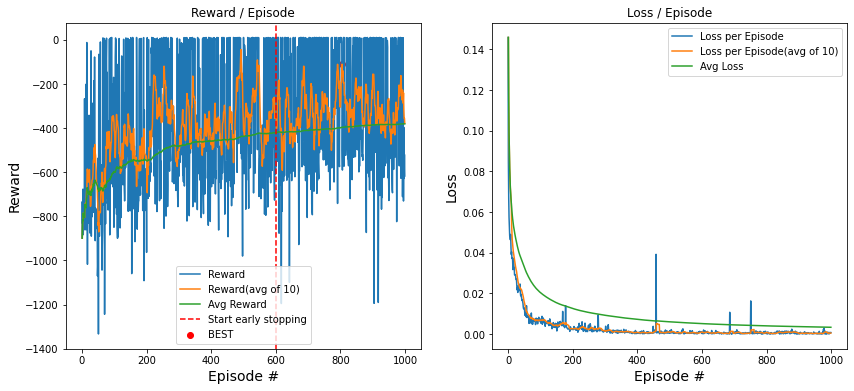

In [ ]:
Visualizer().plot_rewards_loss(trainer_dqn2)

Average results eps-greedy=0.00 on 100 evaluations:
	Reward=-491.37 | Steps=320.99 | Success Rate=36.00%
Average results eps-greedy=0.10 on 100 evaluations:
	Reward=-437.91 | Steps=334.83 | Success Rate=36.00%
Average results eps-greedy=0.20 on 100 evaluations:
	Reward=-401.52 | Steps=300.09 | Success Rate=42.00%
Average results eps-greedy=0.30 on 100 evaluations:
	Reward=-432.81 | Steps=306.29 | Success Rate=40.00%
Average results eps-greedy=0.40 on 100 evaluations:
	Reward=-363.03 | Steps=250.81 | Success Rate=55.00%
Average results eps-greedy=0.50 on 100 evaluations:
	Reward=-427.55 | Steps=292.56 | Success Rate=46.00%
Average results eps-greedy=0.60 on 100 evaluations:
	Reward=-456.96 | Steps=305.69 | Success Rate=46.00%
Average results eps-greedy=0.70 on 100 evaluations:
	Reward=-443.73 | Steps=291.22 | Success Rate=49.00%
Average results eps-greedy=0.80 on 100 evaluations:
	Reward=-407.70 | Steps=262.21 | Success Rate=56.00%
Average results eps-greedy=0.90 on 100 evaluations:
	Re

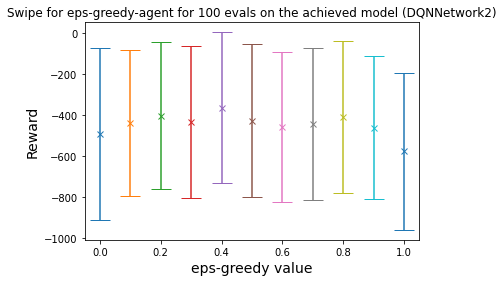

In [ ]:
eps_greedy_vals = np.arange(start=0, stop=1.01, step=0.1, dtype=float)
_ = Evaluator(trainer_dqn2).swipe_eps_greedy_agents(
    n_iterations=100,
    chart_title="Swipe for eps-greedy-agent for 100 evals on the achieved model (DQNNetwork2)",
    eps_greedy_vals=eps_greedy_vals
    )

Average results eps-greedy=0.00 on 100 evaluations:
	Reward=-484.61 | Steps=330.76 | Success Rate=34.00%
Average results eps-greedy=0.10 on 100 evaluations:
	Reward=-480.21 | Steps=362.54 | Success Rate=29.00%
Average results eps-greedy=0.20 on 100 evaluations:
	Reward=-483.69 | Steps=337.36 | Success Rate=34.00%
Average results eps-greedy=0.30 on 100 evaluations:
	Reward=-390.88 | Steps=293.62 | Success Rate=46.00%
Average results eps-greedy=0.40 on 100 evaluations:
	Reward=-355.47 | Steps=247.62 | Success Rate=55.00%
Average results eps-greedy=0.50 on 100 evaluations:
	Reward=-443.57 | Steps=298.43 | Success Rate=44.00%
Average results eps-greedy=0.60 on 100 evaluations:
	Reward=-407.32 | Steps=278.24 | Success Rate=52.00%
Average results eps-greedy=0.70 on 100 evaluations:
	Reward=-450.52 | Steps=294.43 | Success Rate=52.00%
Average results eps-greedy=0.80 on 100 evaluations:
	Reward=-485.18 | Steps=309.40 | Success Rate=51.00%
Average results eps-greedy=0.90 on 100 evaluations:
	Re

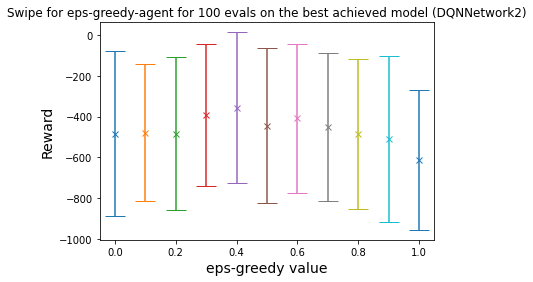

In [ ]:
eps_greedy_vals = np.arange(start=0, stop=1.01, step=0.1, dtype=float)
_ = Evaluator(trainer_dqn2).swipe_eps_greedy_agents(
    agent_name="BEST",
    n_iterations=100,
    chart_title="Swipe for eps-greedy-agent for 100 evals on the best achieved model (DQNNetwork2)",
    eps_greedy_vals=eps_greedy_vals
    )

This network hasn't improved our best results that we got with the above "Experiment1".

---

# Test Environment


## MUST RUN FIRST
Downloading the test environment models

In [ ]:
!gdown 1TixAzAIQvvKTqnoi88UEjPw8F02sbQtd
!unzip /content/results.zip

/usr/local/lib/python3.9/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1TixAzAIQvvKTqnoi88UEjPw8F02sbQtd
To: /content/results.zip
100% 26.2M/26.2M [00:00<00:00, 142MB/s] 
Archive:  /content/results.zip
   creating: results/ab9ebf82/
  inflating: results/ab9ebf82/10Precent.pt  
  inflating: results/ab9ebf82/30Precent.pt  
  inflating: results/ab9ebf82/action_buffer.pt  
  inflating: results/ab9ebf82/BEST.pt  
  inflating: results/ab9ebf82/done.pkl  
  inflating: results/ab9ebf82/done_buffer.pt  
  inflating: results/ab9ebf82/DQN.pt  
  inflating: results/ab9ebf82/DQN_TARGET.pt  
  inflating: results/ab9ebf82/eps.pkl  
  inflating: results/ab9ebf82/ex1_dqn_agent.mp4  
 extracting: results/ab9ebf82/last_episode.pkl  
  inflating: results/ab9ebf82/losses.pkl  
  inflating: results/ab9ebf82/MID.pt 

## EX1 Best Model

A *greedy DQN agent* with a **success rate of 100%** and completes a FIX board in an **average of 9 steps**.

In [ ]:
best_ex1_model = 'results/ab9ebf82'

In [ ]:
cfg = TrainingCfg.get_default_config()
cfg.random_scenario=False

best_ex1_trainer = DQNTrainer(random_scenario=False, config=cfg, pretrained=best_ex1_model, print_params=False)

Initializing DQNTrainer
Game mode: FIX
Initializing DQNTrainer, previous results will be loaded from results/ab9ebf82


In [ ]:
embed_mp4(Evaluator(best_ex1_trainer).evaluate_and_render('best_ex1_model_TEST_ENV', agent_name='BEST'))

load predictor:BEST
The agent solved Sokoban (FIX board) after 9 steps, reward=10.10


## EX2 Best Model

We are introducing two "best" agents. One is a DQN-based agent with ε-greedy policy and achieved the best results for EX2. The second is a DQN-based agent with greedy policy that achieved the best results from the greedy policy algorithms that we tried.

In [ ]:
best_ex2_model = 'results/cbac0e3e'

In [ ]:
cfg = TrainingCfg.get_default_config()
cfg.random_scenario=True

best_ex2_trainer = DQNTrainer(random_scenario=True, config=cfg, pretrained=best_ex2_model, print_params=False)

Initializing DQNTrainer
Game mode: RANDOM
Initializing DQNTrainer, previous results will be loaded from results/cbac0e3e


An *ε-Greedy DQN* agent with a success rate of 56% and completes a Random board in an average of 246 steps.

In [ ]:
embed_mp4(Evaluator(best_ex2_trainer).evaluate_and_render(
    'best_ex2_model_eps_greedy_TEST_ENV', # name of the output video
    agent_name='BEST',                    # agent taken from the best epoch during training
    eps_greedy=0.5                        # 0.5-greedy policy
    )
)

The agent solved Sokoban (RANDOM board) after 2 steps, reward=10.80


A *greedy DQN agent* with a **success rate of 39%** and completes a Random board in an **average of 306 steps**.

In [ ]:
embed_mp4(Evaluator(best_ex2_trainer).evaluate_and_render(
    'best_ex2_model_greedy_TEST_ENV', # name of the output video
    agent_name='BEST',                # agent taken from the best epoch during training
    eps_greedy=0.1                     # greedy policy
    )
)

The agent solved Sokoban (RANDOM board) after 14 steps, reward=9.60
